# Packages

In [1]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (10,7) 
import seaborn as sns
import numpy as np
import pandas as pd
import pwlf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
from statsmodels.tsa.seasonal import STL
import requests
import json
import numpy as np
import re
import plotly.express as ex
from airrship.create_repertoire import generate_sequence,load_data,get_genotype,create_allele_dict
import importlib
import plotly.io as pio
tqdm.pandas()
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os
from scipy.stats import entropy
import matplotlib as mpl
from collections import defaultdict

import numpy as np
import cv2

mpl.rcParams['figure.figsize'] = (20,11)
sns.set_context('poster')
tokenizer_dictionary = {
            "A": 1,
            "T": 2,
            "G": 3,
            "C": 4,
            "N": 5,
            "P": 0,  # pad token
        }
max_length=512

import pickle
from Levenshtein import distance,hamming
with open('E:/Immunobiology/AlignAIRR/V_Allele_F_dict.pkl','rb') as h:
    V_Alleles = pickle.load(h)
    
def _process_and_dpad(sequence, train=True):
    start, end = None, None
    trans_seq = [tokenizer_dictionary[i] for i in sequence]

    gap = max_length - len(trans_seq)
    iseven = gap % 2 == 0
    whole_half_gap = gap // 2

    if iseven:
        trans_seq = [0] * whole_half_gap + trans_seq + ([0] * whole_half_gap)
        if train:
            start, end = whole_half_gap, max_length - whole_half_gap - 1

    else:
        trans_seq = [0] * (whole_half_gap + 1) + trans_seq + ([0] * whole_half_gap)
        if train:
            start, end = (whole_half_gap + 1, max_length - whole_half_gap - 1)

    return trans_seq, start, end if iseven else (end + 1)

def process_sequences(self, data: pd.DataFrame, corrupt_beginning=False, verbose=False):
    padded_sequences = []
    v_start, v_end, d_start, d_end, j_start, j_end = [], [], [], [], [], []
    iterator = tqdm(data.itertuples(), total=len(data)) if verbose else data.itertuples()
    for row in iterator:
        seq = row.sequence
        padded_array, start, end = _process_and_dpad(seq, self.max_length)
        padded_sequences.append(padded_array)
        _adjust = start


        v_start.append(start)
        j_end.append(end)
        v_end.append(row.v_sequence_end + _adjust)
        d_start.append(row.d_sequence_start + _adjust)
        d_end.append(row.d_sequence_end + _adjust)
        j_start.append(row.j_sequence_start + _adjust)

    v_start = np.array(v_start)
    v_end = np.array(v_end)
    d_start = np.array(d_start)
    d_end = np.array(d_end)
    j_start = np.array(j_start)
    j_end = np.array(j_end)

    padded_sequences = np.vstack(padded_sequences)

    return v_start, v_end, d_start, d_end, j_start, j_end, padded_sequences
def global_genotype():
    try:
        path_to_data = importlib.resources.files(
            'airrship').joinpath("data")
    except AttributeError:
        with importlib.resources.path('airrship', 'data') as p:
            path_to_data = p
    v_alleles = create_allele_dict(
        f"{path_to_data}/imgt_human_IGHV.fasta")
    d_alleles = create_allele_dict(
        f"{path_to_data}/imgt_human_IGHD.fasta")
    j_alleles = create_allele_dict(
        f"{path_to_data}/imgt_human_IGHJ.fasta")

    vdj_allele_dicts = {"V": v_alleles,
                        "D": d_alleles,
                        "J": j_alleles}

    chromosome1, chromosome2 = defaultdict(list), defaultdict(list)
    for segment in ["V", "D", "J"]:
        allele_dict = vdj_allele_dicts[segment]
        for gene in allele_dict.values():
            for allele in gene:
                chromosome1[segment].append(allele)
                chromosome2[segment].append(allele)

    locus = [chromosome1, chromosome2]
    return locus


def decompose_call(call):
    family, G = call.split("-", 1)
    gene, allele = G.split("*")
    return family, gene, allele
locus = global_genotype()

v_dict = dict()
for call in ["V"]:
    for idx in range(2):
        for N in locus[idx][call]:
            if call == "V":
                family, G = N.name.split("-", 1)
                gene, allele = G.split("*")
                v_dict[N.name] = {
                    "family": family,
                    "gene": gene,
                    "allele": allele,
                }

v_families = sorted(set([v_dict[i]["family"] for i in v_dict]))
v_genes = sorted(set([v_dict[i]["gene"] for i in v_dict]))
v_alleles = sorted(set([v_dict[i]["allele"] for i in v_dict]))
v_family_call_ohe = {f: i for i, f in enumerate(v_families)}
v_gene_call_ohe = {f: i for i, f in enumerate(v_genes)}
v_allele_call_ohe = {f: i for i, f in enumerate(v_alleles)}


label_num_sub_classes_dict = {
    "V": {
        "family": v_family_call_ohe,
        "gene": v_gene_call_ohe,
        "allele": v_allele_call_ohe}
}

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from VDeepJUnbondedDataset import global_genotype

locus = global_genotype()
v_dict = {i.name: i.ungapped_seq.upper() for i in locus[0]['V']}
d_dict = {i.name: i.ungapped_seq.upper() for i in locus[0]['D']}
j_dict = {i.name: i.ungapped_seq.upper() for i in locus[0]['J']}
        
v_alleles = sorted(list(v_dict))
d_alleles = sorted(list(d_dict))
j_alleles = sorted(list(j_dict))

v_allele_count = len(v_alleles)
d_allele_count = len(d_alleles)
j_allele_count = len(j_alleles)


v_allele_call_ohe = {f: i for i, f in enumerate(v_alleles)}
d_allele_call_ohe = {f: i for i, f in enumerate(d_alleles)}
j_allele_call_ohe = {f: i for i, f in enumerate(j_alleles)}

v_allele_call_rev_ohe = {i: f for i, f in enumerate(v_alleles)}
d_allele_call_rev_ohe = {i: f for i, f in enumerate(d_alleles)}
j_allele_call_rev_ohe = {i: f for i, f in enumerate(j_alleles)}

def encode_igb_v_call(v_call):
    v = np.zeros(len(v_allele_call_rev_ohe))
    for i in v_call.split(','):
        v[v_allele_call_ohe[i]] = 1
    return v

In [537]:
type(locus[0]['V'][0])

airrship.create_repertoire.Allele

In [3]:
def allign_sequences(seqs):
    sequences = [
    SeqRecord(Seq(seq), id=f"seq{en}")
    for en,seq in enumerate(seqs)
    ]
    SeqIO.write(sequences, r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta", "fasta")

    # Define Clustal Omega command
    clustalomega_cline = ClustalOmegaCommandline(infile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta",
                                                 outfile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", verbose=True, auto=True,force=True)
    clustalomega_cline.program_name = r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\clustalo.exe"
    stdout, stderr = clustalomega_cline()

    alignment = AlignIO.read(r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", "fasta")
    return alignment

In [4]:
def log_threshold(prediction,th=0.4):
    ast = np.argsort(prediction)[::-1]
    R = [ast[0]]
    for ip in range(1,len(ast)):
        DIFF = np.log(prediction[ast[ip-1]]/prediction[ast[ip]])
        if DIFF<th:
            R.append(ast[ip])
        else:
            break
    return R
def exact_threshold(prediction,th=0.01):
    ast = np.argsort(prediction)[::-1]
    R = [ast[0]]
    for ip in range(1,len(ast)):
        if prediction[ast[ip]]>th:
            R.append(ast[ip])
        else:
            break
    return R

def otsu_threshold(predictions):
    # Convert predictions to a format suitable for cv2's threshold function
    predictions_255 = (predictions * 255).astype(np.uint8)
    
    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(predictions_255, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Convert back to original scale
    otsu_thresh = thresh / 255.0
    
    return otsu_thresh
def log_threshold_look_ahead(prediction, th=0.4, look_ahead=3):
    ast = np.argsort(prediction)[::-1]
    R = [ast[0]]
    
    ip = 1
    while ip < len(ast):
        DIFF = np.log(prediction[ast[ip-1]]/prediction[ast[ip]])
        
        if DIFF < th:
            R.append(ast[ip])
            ip += 1
        else:
            # Look ahead
            for j in range(1, look_ahead+1):
                if ip+j < len(ast):
                    DIFF_LOOK_AHEAD = np.log(prediction[ast[ip+j-1]]/prediction[ast[ip+j]])
                    if DIFF_LOOK_AHEAD < th:
                        R.append(ast[ip+j])
                    else:
                        break
            ip += j+1
            
    return R



In [6]:
import numpy as np

def compute_thresholds(matrix):
    """
    Compute thresholds for each label based on the mean probability.

    Parameters:
    - matrix (numpy array): A NxF matrix where N is the number of samples and F is the number of labels.

    Returns:
    - thresholds (list): A list of threshold values for each label.
    """
    return np.mean(matrix, axis=0)


# Loading The Data

In [7]:
def extract_prediction_alleles(probabilites,th=0.4):
    V_ratio = []
    for v_all in tqdm(probabilites):
        v_alleles  = log_threshold(v_all,th=th)
        V_ratio.append([v_allele_call_rev_ohe[i] for i in v_alleles])
    return V_ratio



In [27]:
# import pickle
# with open(r"E:\Immunobiology\AlignAIRR\experimental_v2_alignairr_predicted_TH_5.pkl",'rb') as h:
#     V,D,J,alignairr_predicted = pickle.load(h)

In [28]:
# import pickle
# with open(r'E:\Immunobiology\AlignAIRR\p1_p11_vdeepjexp_v3_V_PROCESSED.pkl','rb') as h:
#     V = pickle.load(h)
    
# with open(r'E:\Immunobiology\AlignAIRR\p1_p11_vdeepjexp_v3.pkl','rb') as h:
#     alignairr_predicted = pickle.load(h)

In [8]:
with open('E:/Immunobiology/AlignAIRR/2023_08_30_alignairr_results.pkl','rb') as h:
    predicted = pickle.load(h)
igb_predicted = pd.read_table(r"E:\Immunobiology\AlignAIRR\naive_sequences_clean.tsv",index_col=0)
alignairr_predicted = predicted

In [39]:
with open('E:/Immunobiology/AlignAIRR/vquest_allele_db.pkl','rb') as h:
    vquest = pickle.load(h)

In [9]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
with open('singlebeam_v2_calibrators.pkl','rb') as h:
    calibrators = pickle.load(h)

In [10]:

calibrated_probs = []
for i in tqdm(range(alignairr_predicted['v_allele'].shape[1])):
    lr = calibrators[v_allele_call_rev_ohe[i]]
    calibrated_prob = lr.transform(alignairr_predicted['v_allele'][:, i].reshape(-1, 1))
    calibrated_probs.append(calibrated_prob)
calibrated_probs = np.array(calibrated_probs).T

  0%|          | 0/280 [00:00<?, ?it/s]

In [18]:
V = extract_prediction_alleles(calibrated_probs,th=1)

  0%|          | 0/2759335 [00:00<?, ?it/s]

C:\Users\Tomas\AppData\Local\Temp\ipykernel_28996\3478466091.py:5: RuntimeWarning: divide by zero encountered in float_scalars
  DIFF = np.log(prediction[ast[ip-1]]/prediction[ast[ip]])


In [19]:
hits = [len( set(i.split(',')) &set(j)) > 0 for i,j in zip(igb_predicted.v_call,V)]
sum(hits)/len(hits)

0.9761348295875637

### Optimal Threshold

In [514]:
import numpy as np
from scipy.stats import ks_2samp



KS Statistic: 0.14545454545454545
P-value: 1.0


In [530]:
def kl_divergence(p, q):
    """
    Compute the Kullback-Leibler divergence between two probability distributions.
    
    Args:
    - p (np.array): First probability distribution.
    - q (np.array): Second probability distribution.

    Returns:
    - float: The KL divergence between p and q.
    """
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
def counts_to_probs(counts):
    """
    Convert a list of counts to probabilities.
    
    Args:
    - counts (list or np.array): List of counts.

    Returns:
    - np.array: Normalized probability distribution.
    """
    return np.array(counts) / np.sum(counts)
Q = list(map(len,igb_predicted.v_call.apply(lambda x:x.split(','))))

thses = np.linspace(0,2,50)
aggs = []
ks = []
for T in tqdm(thses):
    temp_V = extract_prediction_alleles(calibrated_probs,th=T)
    hits = [len( set(i.split(',')) &set(j)) > 0 for i,j in zip(igb_predicted.v_call,temp_V)]
    agg = sum(hits)/len(hits)
    aggs.append(agg)
    P = list(map(len,temp_V))
    
    ks_statistic, p_value = ks_2samp(Q, P)
    
    ks.append(ks_statistic)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

C:\Users\Tomas\AppData\Local\Temp\ipykernel_28996\3478466091.py:5: RuntimeWarning: divide by zero encountered in float_scalars
  DIFF = np.log(prediction[ast[ip-1]]/prediction[ast[ip]])


  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

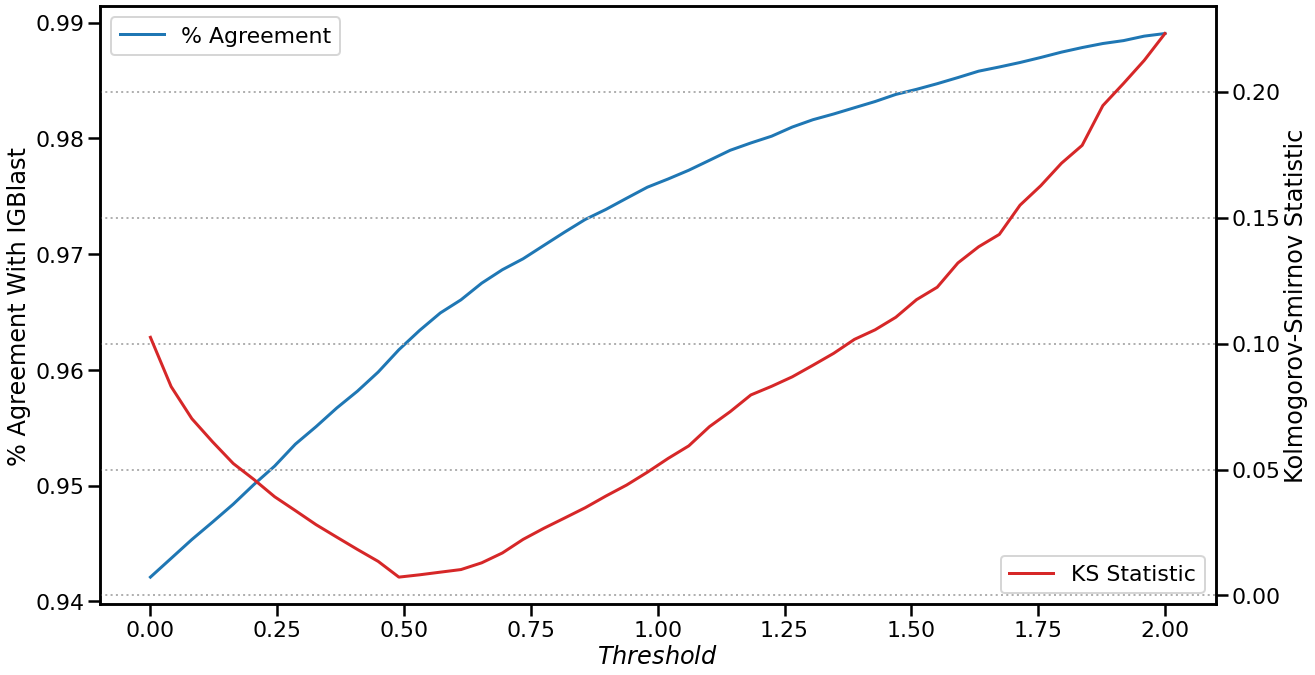

In [531]:
ax = sns.lineplot(x=thses,y=aggs,label='% Agreement')
ax2 = ax.twinx()

sns.lineplot(x=thses,y=ks,ax=ax2,color='tab:red',label='KS Statistic')
ax2.legend(loc='lower right')

ax.set_ylabel('% Agreement With IGBlast')
ax2.set_ylabel('Kolmogorov-Smirnov Statistic')
ax.set_xlabel(r'$Threshold$')
plt.grid(lw=2,ls=':')

In [447]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score,f1_score

def find_optimal_thresholds(y_true, y_pred_probs):
    thresholds = np.linspace(0, 1, 100)
    optimal_thresholds = np.zeros(y_pred_probs.shape[1])
    r_matrix = np.zeros((y_pred_probs.shape[1],100))
    
    for class_idx in tqdm(range(y_pred_probs.shape[1])):
        best_threshold = 0
        best_score = -1
        for en,threshold in tqdm(enumerate(thresholds),position=1,total=100):
            y_pred = (y_pred_probs[:, class_idx] > threshold).astype(int)
            score = f1_score(y_true[:, class_idx], y_pred)
            print(threshold,'->  ',score)
            r_matrix[class_idx,en] = score
            if score > best_score:
                best_score = score
                best_threshold = threshold
        optimal_thresholds[class_idx] = best_threshold
        
    return optimal_thresholds,r_matrix,thresholds


In [456]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

def find_optimal_thresholds(y_true, y_pred_probs, tolerance=1e-4):
    optimal_thresholds = np.zeros(y_pred_probs.shape[1])
    r_matrix = np.zeros((y_pred_probs.shape[1],100))
    itr = tqdm(range(y_pred_probs.shape[1]))
    vall = list(v_allele_call_ohe)
    
    for class_idx in itr:
        best_threshold = 0
        best_score = -1
        
        low, high = 0, 1
        while high - low > tolerance:
            mid = (high + low) / 2
            y_pred = (y_pred_probs[:, class_idx] > mid).astype(int)
            score = f1_score(y_true[:, class_idx], y_pred)
            
            #r_matrix[class_idx, :len(score)] = score 
            
            #print(mid, '->  ', score)
            itr.set_postfix({'Allele ': f'{vall[class_idx]}','TSH':mid,'f1 score': score})
            
            if score > best_score:
                best_score = score
                best_threshold = mid
                
                low = mid
            else:
                high = mid
        
        optimal_thresholds[class_idx] = best_threshold
        
    return optimal_thresholds, r_matrix


In [452]:
igb_v_call_encoded =  np.vstack([encode_igb_v_call(i) for i in igb_predicted.v_call])

In [ ]:
optimal_thresholds,r_matrix,thresholds = find_optimal_thresholds(igb_v_call_encoded,alignairr_predicted['v_allele'])

In [457]:
optimal_thresholds, r_matrix = find_optimal_thresholds(igb_v_call_encoded,alignairr_predicted['v_allele'])

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

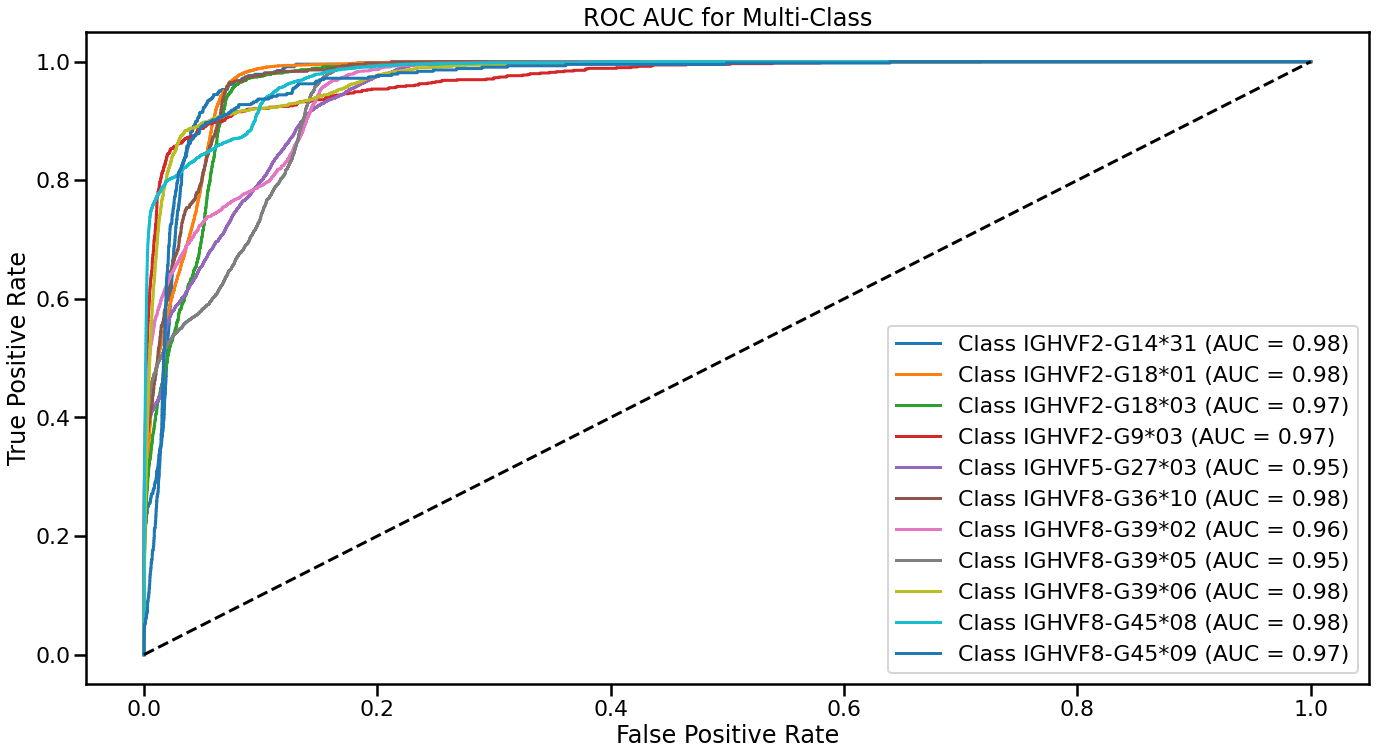

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc_auc(y_true, y_pred_probs, n_classes):
    plt.figure(figsize=(23, 12))
    for i in tqdm(range(n_classes)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        if np.round(roc_auc,3) < 0.98:
            plt.plot(fpr, tpr, label='Class %s (AUC = %0.2f)' % (v_allele_call_rev_ohe[i], roc_auc))
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC for Multi-Class')
    plt.legend(loc="best")
    plt.show()

plot_multiclass_roc_auc(igb_v_call_encoded, alignairr_predicted['v_allele'], 280)


In [107]:
# # Confusion Matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# cm = confusion_matrix(y_true.argmax(axis=1), y_pred_probs.argmax(axis=1))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()


In [105]:
from sklearn.metrics import classification_report

print(classification_report(y_true.argmax(axis=1), y_pred_probs.argmax(axis=1)))


C:\Users\Tomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2305
           1       0.85      0.55      0.67      3541
           2       0.56      1.00      0.71      1954
           3       0.36      0.10      0.16      3203
           4       0.01      0.23      0.01        13
           5       0.69      0.86      0.77      4437
           6       0.70      0.98      0.82      4156
           7       0.79      0.84      0.81      3462
           8       0.96      0.62      0.75      7974
           9       0.06      0.63      0.12        62
          10       0.63      0.46      0.53       109
          11       0.09      0.14      0.11       232
          12       0.80      0.56      0.66      5044
          13       0.87      0.91      0.89     16392
          14       0.12      0.71      0.21       241
          15       0.00      0.00      0.00       100
          16       0.00      0.00      0.00        26
          17       0.97    

C:\Users\Tomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
# from sklearn.calibration import calibration_curve
# y_pred_probs = alignairr_predicted['v_allele']
# y_true = igb_v_call_encoded

# fraction_of_positives, mean_predicted_value = calibration_curve(y_true.argmax(axis=1), y_pred_probs[:, 1], n_bins=10)

# plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibration")
# plt.plot([0, 1], [0, 1], '--', label="Perfectly calibrated")
# plt.legend()
# plt.show()


In [59]:
# Find Youden Statistic For Each Class
import numpy as np
from sklearn.metrics import roc_curve

def youden_statistic(y_true, y_score):
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]


yindex_threshold = dict()
for cidx in tqdm(range(280)):
    yt = igb_v_call_encoded[:,cidx]
    yp = alignairr_predicted['v_allele'][:,cidx]
    yindex_threshold[v_allele_call_rev_ohe[cidx]] = (cidx,youden_statistic(yt,yp))
    
yindex_threshold['IGHVF1-G1*01'][1]

  0%|          | 0/280 [00:00<?, ?it/s]

In [98]:
# from sklearn.metrics import f1_score
# import numpy as np

# def find_optimal_threshold_per_class(y_true, y_pred_probs):
#     optimal_thresholds = {}
    
#     n_classes = y_pred_probs.shape[1]
    
#     for class_idx in range(n_classes):
#         thresholds = np.linspace(0, 1, 25)
#         f1_scores = []
        
#         # Convert multiclass labels into binary labels for current class
#         y_true_binary = (y_true == class_idx).astype(int)
        
#         for threshold in thresholds:
#             y_pred_binary = (y_pred_probs[:, class_idx] > threshold).astype(int)
#             f1_scores.append(f1_score(y_true_binary, y_pred_binary))
        
#         # Get threshold with max F1 score
#         optimal_threshold = thresholds[np.argmax(f1_scores)]
#         optimal_thresholds[class_idx] = optimal_threshold
        
#     return optimal_thresholds

# y_true_labels = np.argmax(y_true, axis=1)
# optimal_thresholds_f1 = find_optimal_threshold_per_class(igb_v_call_encoded, alignairr_predicted['v_allele'])
# print(optimal_thresholds_f1)


In [717]:
def proportional_threshold(probs, proportion=0.005):
    return np.percentile(probs, 100 * (1 - proportion))
def std_dev_threshold(probs, factor=1):
    mean = np.mean(probs)
    std_dev = np.std(probs)
    return mean + factor * std_dev
def entropy_threshold(probs):
    entropy = -np.sum(probs * np.log2(probs))
    return 1 - (entropy / np.log2(len(probs)))

# from kneed import KneeLocator
# V = []
# x = range(0,280)
# for probas in tqdm(alignairr_predicted['v_allele']):
#     sorted_data_indices = np.argsort(probas)[::-1]
#     sorted_data = np.sort(probas)[::-1]
    
#     kn = KneeLocator(x, sorted_data, curve='convex', direction='decreasing')
#     selected_indices = (sorted_data_indices[:kn.knee])
    
#     V.append([v_allele_call_rev_ohe[i] for i in selected_indices])

# V = []
# for probas in tqdm(alignairr_predicted['v_allele']):
#     th = std_dev_threshold(probas,factor=3.5)
#     selected = np.where(probas>th)[0]
#     V.append([v_allele_call_rev_ohe[o] for  o in selected])
    
    
V = extract_prediction_alleles(predicted['v_allele'])

  0%|          | 0/2759335 [00:00<?, ?it/s]

<AxesSubplot:>

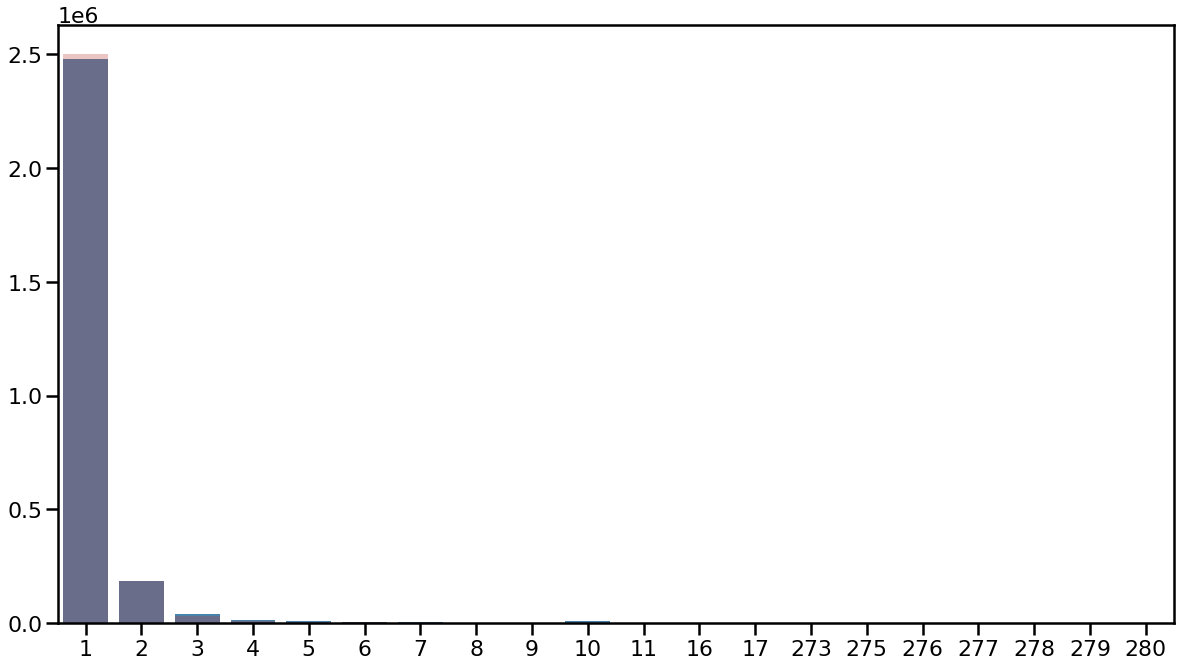

In [720]:
from scipy.special import rel_entr
P = pd.Series(list(map(len,V))).value_counts()
P = P.iloc[:20]
Q = pd.Series(list(map(len,igb_predicted.v_call.apply(lambda x: x.split(','))))).value_counts().sort_index()
sns.barplot(x=Q.index,y=Q,color='tab:blue',alpha=0.9)
sns.barplot(x=P.index,y=P,color='tab:red',alpha=0.3)

In [723]:
def kl_divergence(p, q):
    """
    Compute the Kullback-Leibler divergence between two probability distributions.
    
    Args:
    - p (np.array): First probability distribution.
    - q (np.array): Second probability distribution.

    Returns:
    - float: The KL divergence between p and q.
    """
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
def counts_to_probs(counts):
    """
    Convert a list of counts to probabilities.
    
    Args:
    - counts (list or np.array): List of counts.

    Returns:
    - np.array: Normalized probability distribution.
    """
    return np.array(counts) / np.sum(counts)
probs1 = counts_to_probs(list(map(len,V)))
probs2 = counts_to_probs(list(map(len,igb_predicted.v_call)))

kl = kl_divergence(probs1, probs2)
#print(f"KL Divergence between counts1 and counts2: {kl:.
kl

1.2805532902872367

In [724]:
hits = [len( set(i.split(',')) &set(j)) > 0 for i,j in zip(igb_predicted.v_call,V)]
sum(hits)/len(hits)

0.9584693413449255

In [714]:
len(V)

2759335

### Calibraton


In [37]:
from VDeepJModelExperimental import VDeepJAllignExperimentalV3,VDeepJAllignExperimentalSingleBeam2
from UnboundedTrainer import UnboundedTrainer, SingleBeamUnboundedTrainer
model = VDeepJAllignExperimentalSingleBeam2
trainer = SingleBeamUnboundedTrainer(model,epochs=10,steps_per_epoch=100,batch_size=32,verbose=True,batch_file_reader=True)
trainer.model.build({'tokenized_sequence':(512,1),'tokenized_sequence_for_masking':(512,1)})
#trainer.model.load_weights('E:\\Immunobiology\\AlignAIRR\\\\sf5_unbounded_experimentalv4_model')
trainer.model.load_weights('E:/Immunobiology/AlignAIRR/sf5_unbounded_experimental_mh_single_beam_model')


In [555]:

def predict_sample(sample):
    eval_dataset_ = trainer.train_dataset.tokenize_sequences([sample])
    padded_seqs_tensor = tf.convert_to_tensor(eval_dataset_, dtype=tf.int32)
    dataset_from_tensors = tf.data.Dataset.from_tensor_slices({
        'tokenized_sequence': padded_seqs_tensor,
        'tokenized_sequence_for_masking': padded_seqs_tensor
    })
    dataset = (
        dataset_from_tensors
        .batch(1)
        .prefetch(tf.data.AUTOTUNE)
    )

    predicted = trainer.model.predict(dataset, verbose=True)
    return predicted


In [38]:
from airrship.create_repertoire import generate_sequence_spesific
import random
train_sequences = []
N = 1500
N_ALL = len(locus[0]['V'])
y_train = np.zeros((N*N_ALL,N_ALL))
ax= 0
for _ in tqdm(range(N)):
    for _v in locus[0]['V']:
        _d = random.choice(locus[0]['D'])
        _j = random.choice(locus[0]['J'])
        seq = generate_sequence_spesific(_v,_d,_j,trainer.train_dataset.data_dict, mutate=trainer.train_dataset.mutate,
                                  mutation_rate=np.random.uniform(0, trainer.train_dataset.mutation_rate, 1).item(),
                                  shm_flat=trainer.train_dataset.shm_flat, flat_usage='allele')
        train_sequences.append(seq.mutated_seq)
        y_train[ax,v_allele_call_ohe[_v.name]] = 1
        ax+=1

  0%|          | 0/1500 [00:00<?, ?it/s]

In [40]:
from VDeepJUnbondedDataset import VDeepJUnbondedDatasetSingleBeam
vssds = VDeepJUnbondedDatasetSingleBeam()
X_train = vssds.tokenize_sequences(train_sequences)

In [42]:
# with open('calibration_set_1500_single_beam.pkl','wb') as h:
#     pickle.dump((X_train,y_train),h)

In [44]:
import tensorflow as tf
padded_seqs_tensor = tf.convert_to_tensor(X_train, dtype=tf.int32)
dataset_from_tensors = tf.data.Dataset.from_tensor_slices({
    'tokenized_sequence': padded_seqs_tensor,
    'tokenized_sequence_for_masking': padded_seqs_tensor
})
dataset = (
    dataset_from_tensors
    .batch(768)
    .prefetch(tf.data.AUTOTUNE)
)

raw_predictions = trainer.model.predict(dataset, verbose=True)

547/547 [==============================] - 259s 461ms/step


In [848]:
predicted_probs = raw_predictions['v_allele']
y_val = y_train

In [45]:
# with open('predicted_calibration_set_1500_single_beam.pkl','wb') as h:
#     pickle.dump((raw_predictions,y_train),h)

In [1661]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

calibrated_probs = []
calibrators = {}
for i in tqdm(range(y_val.shape[1])):
    #lr = LogisticRegression()
    #lr.fit(predicted_probs[:, i].reshape(-1, 1), y_val[:, i])
    lr = IsotonicRegression(y_min=0,y_max=1,out_of_bounds='clip',increasing= 'auto' )
    lr.fit(predicted_probs[:, i].reshape(-1, 1), y_val[:, i])
    #calibrated_prob = lr.predict_proba(alignairr_predicted['v_allele'][:, i].reshape(-1, 1))[:, 1]
    calibrators[v_allele_call_rev_ohe[i]] = lr
    calibrated_prob = lr.transform(alignairr_predicted['v_allele'][:, i].reshape(-1, 1))

    calibrated_probs.append(calibrated_prob)

calibrated_probs = np.array(calibrated_probs).T

  0%|          | 0/280 [00:00<?, ?it/s]

MemoryError: Unable to allocate 2.88 GiB for an array with shape (280, 2759335) and data type float32

In [46]:
# from sklearn.calibration import calibration_curve

# lbl=1
# x=alignairr_predicted['v_allele'][:,lbl]
# y=igb_v_call_encoded[:,lbl]
# sns.kdeplot((x[y==1]))
# #sns.kdeplot(np.log10(x[y==0]))

In [1135]:
# Calibrate probabilities using logistic regression
from sklearn.linear_model import LogisticRegression

calibrated_probs = []
for i in tqdm(range(y_val.shape[1])):
    #lr = LogisticRegression()
    #lr.fit(predicted_probs[:, i].reshape(-1, 1), y_val[:, i])
    lr = IsotonicRegression(y_min=0,y_max=1,out_of_bounds='clip',increasing= 'auto' )
    lr.fit(predicted_probs[:, i].reshape(-1, 1), y_val[:, i])
    #calibrated_prob = lr.predict_proba(alignairr_predicted['v_allele'][:, i].reshape(-1, 1))[:, 1]
    calibrated_prob = lr.transform(alignairr_predicted['v_allele'][:, i].reshape(-1, 1))

    calibrated_probs.append(calibrated_prob)

calibrated_probs = np.array(calibrated_probs).T

  0%|          | 0/280 [00:00<?, ?it/s]

In [1631]:
from scipy.optimize import minimize
from IPython.display import clear_output
class BetaCalibration:
    def __init__(self):
        self.params = None

    def _beta_function(self, p, a, b, m):
        return (1 - m) * (p ** (a - 1) * (1 - p) ** (b - 1))

    def _objective(self, params, p, y):
        a, b, m = params
        q = self._beta_function(p, a, b, m)
        return -np.sum(y * np.log(q) + (1 - y) * np.log(1 - q))

    def fit(self, p, y):
        initial_guess = [1, 1, 0.5]
        result = minimize(self._objective, initial_guess, args=(p, y), bounds=[(0.001, None), (0.001, None), (0, 1)])
        self.params = result.x

    def predict(self, p):
        if self.params is None:
            raise ValueError("Model is not fitted yet!")
        a, b, m = self.params
        return self._beta_function(p, a, b, m)

class TemperatureScaling:
    def __init__(self):
        self.temperature = 1.0

    def _scaled_probability(self, p, T):
        return p ** (1.0 / T)

    def _objective(self, T, p, y):
        q = self._scaled_probability(p, T[0])
        return -np.sum(y * np.log(q) + (1 - y) * np.log(1 - q))

    def fit(self, p, y):
        result = minimize(self._objective, [1.0], args=(p, y), bounds=[(0.001, None)])
        self.temperature = result.x[0]

    def predict(self, p):
        return self._scaled_probability(p, self.temperature)


class LabelOptimizer:
    def __init__(self, prob_matrix, igb_predicted_v_call):
        self.prob_matrix = prob_matrix
        self.igb_predicted_v_call = igb_predicted_v_call
        self.optimal_thresholds = None
        self.ax=0

    def _calculate_CV(self, thresholds):
        return (self.prob_matrix>=thresholds.reshape(1,-1)).astype(np.uint8)

    def _objective(self, thresholds):
        CV = self._calculate_CV(thresholds)
        hits = [len(set(np.where(i>0)[0])&set(np.where(j>0)[0])) > 0 for i,j in zip(CV,self.igb_predicted_v_call)]
        
        N_SELECTED = (CV>0).sum(axis=1).sum()
        #hits = [sum(i==j)>1 for i, j in zip(self.igb_predicted_v_call, CV)]
        # We want to maximize sum(hits)/len(hits) and minimize the number of selected labels
        # Since scipy's 'minimize' function minimizes, we return the negative value
        clear_output(wait=True)
        print(self.ax,sum(hits)/len(hits),N_SELECTED)
        print(thresholds)
        self.ax+=1
        return -sum(hits)/len(hits)# + 0.05 * N_SELECTED  # 0.01 is a regularization term

    def optimize(self, initial_thresholds=None):
        if initial_thresholds is None:
            initial_thresholds = [0.99] * self.prob_matrix.shape[1]
        result = minimize(self._objective, initial_thresholds, bounds=[(0, 1) for _ in initial_thresholds])
        self.optimal_thresholds = result.x
        return self.optimal_thresholds

    def get_optimal_labels(self):
        if self.optimal_thresholds is None:
            raise ValueError("You need to run the 'optimize' method first!")
        return self._calculate_CV(self.optimal_thresholds)
    
def detect_changepoints_without_threshold(signal):
    """Detect changepoint without using a threshold."""
    sorted_indices = np.argsort(signal)[::-1]
    sorted_signal = signal[sorted_indices]#[::-1]
    
    mean = np.mean(sorted_signal)
    cusum = np.cumsum(sorted_signal)
    
    # Find the index where the difference between consecutive values is maximized
    diff_cusum = np.diff(cusum)
    switchpoint = np.argmax(diff_cusum-mean)
    #plt.plot(np.log(cusum))
    #plt.plot(diff_cusum)
    
    original_indices_up_to_switchpoint = sorted_indices[:switchpoint]
    return original_indices_up_to_switchpoint

def sum_based(signal):
    sorted_indices = np.argsort(signal)[::-1]
    sorted_signal = signal[sorted_indices]

    S = np.sum(sorted_signal)
    ratio = sorted_signal[1]/sorted_signal[0]
    #print(ratio)
    #print(np.cumsum(sorted_signal))
    E = np.where(np.cumsum(sorted_signal)<=(S - ratio*0.5))[0]
    return [sorted_indices[i] for i in E]
            

def log_threshold_v2(prediction, th=0.4, prob_th=0.5):
    # Step 1: Select labels with probability above prob_th
    R = [i for i, p in enumerate(prediction) if p > prob_th]
    
    # If we already have labels from step 1, we can return them
    if len(R) > 0:
        return R
    
    # Step 2: Apply log ratio thresholding for the rest
    ast = np.argsort(prediction)[::-1]
    R.append(ast[0])
    for ip in range(1, len(ast)):
        DIFF = np.log(prediction[ast[ip-1]]/prediction[ast[ip]])
        if DIFF < th:
            R.append(ast[ip])
        else:
            break
    return R

def log_threshold_v3(prediction):
    ast = np.argsort(prediction)[::-1]
    R = [ast[0]]
    
    for ip in range(1, len(ast)):
        relative_diff = (prediction[ast[ip-1]] - prediction[ast[ip]]) / prediction[ast[ip-1]]
        
        # If the relative difference is more than 50%, stop including more labels
        if relative_diff > 0.5:
            break
        
        R.append(ast[ip])
    
    return R
def std_threshold(prediction):
    ast = np.argsort(prediction)[::-1]
    R = [ast[0]]
    std_dev = np.std(prediction)
    
    for ip in range(1, len(ast)):
        if prediction[ast[ip-1]] - prediction[ast[ip]] > std_dev:
            break
        R.append(ast[ip])
    
    return R
def mean_diff_threshold(prediction):
    ast = np.argsort(prediction)[::-1]
    R = [ast[0]]
    diffs = [prediction[ast[i]] - prediction[ast[i+1]] for i in range(len(ast)-1)]
    mean_diff = np.mean(diffs)
    
    for ip in range(1, len(ast)):
        if prediction[ast[ip-1]] - prediction[ast[ip]] > mean_diff:
            break
        R.append(ast[ip])
    
    return R
def median_ratio_threshold(prediction):
    ast = np.argsort(prediction)[::-1]
    R = [ast[0]]
    ratios = [prediction[ast[i]] / prediction[ast[i+1]] for i in range(len(ast)-1)]
    median_ratio = np.median(ratios)
    
    for ip in range(1, len(ast)):
        if prediction[ast[ip-1]] / prediction[ast[ip]] < median_ratio:
            break
        R.append(ast[ip])
    
    return R
def moving_average_ratio_threshold(prediction, window_size=3, ratio=0.5):
    # Sort the indices based on prediction values
    ast = np.argsort(prediction)[::-1]
    
    # Initialize the result with the highest probability label
    R = [ast[0]]
    
    # Start from the second highest probability
    for ip in range(1, len(ast)):
        # Calculate the moving average of the previous probabilities
        start_idx = max(0, ip - window_size)
        moving_avg = np.mean(prediction[ast[start_idx:ip]])
        
        # If the current probability is less than the specified ratio of the moving average, stop
        if prediction[ast[ip]] < ratio * moving_avg:
            break
        
        R.append(ast[ip])
    
    return R

     

# # Example usage:
# signal = calibrated_probs[0]
# changepoint = moving_average_ratio_threshold(signal)
# print(f"Detected changepoint at index: {changepoint}")

# Vcp = [ ]
# for signal in tqdm(calibrated_probs):
#     Vcp.append([v_allele_call_rev_ohe[i] for i  in detect_changepoints_without_threshold(signal) ] )
    

optimizer = LabelOptimizer(raw_predictions['v_allele'], y_val)
optimal_thresholds = optimizer.optimize()
optimal_labels = optimizer.get_optimal_labels()
print("Optimal Thresholds:", optimal_thresholds)
print("Optimal Labels:", optimal_labels)
    
# # Beta Calibration
# beta_calib = BetaCalibration()
# beta_calib.fit(predicted_probs, true_labels)
# calibrated_probs_beta = beta_calib.predict(alignairr_predicted['v_allele'])

# Temperature Scaling
# temp_scale = TemperatureScaling()
# temp_scale.fit(predicted_probs, true_labels)
# calibrated_probs_temp = temp_scale.predict(alignairr_predicted['v_allele'])


2 0.2639952380952381 111268
[0.99       0.99000001 0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0.99
 0.99       0.99       0.99       0.99       0.99       0

KeyboardInterrupt: 

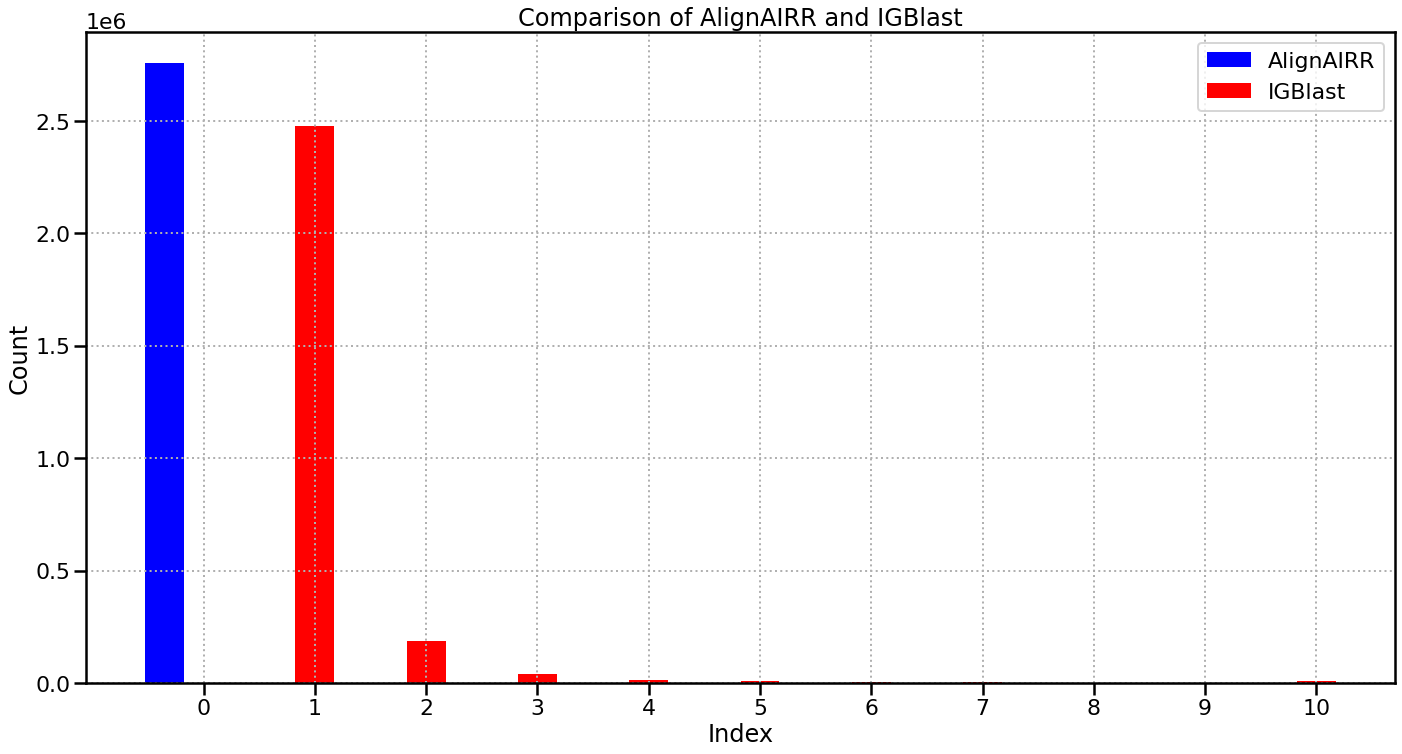

In [1600]:
Q = pd.Series(list(map(len,Vcp))).value_counts().iloc[:25]
P =  pd.Series(list(map(len,igb_predicted.v_call.apply(lambda x:x.split(','))))).value_counts()
#Q =Q.loc[P.index]
#Q
df = pd.concat([Q.to_frame().rename(columns={0:'AlignAIRR'}),P.to_frame().rename(columns={0:'IGBlast'})],axis=1).reset_index()#.melt()

#plt.barplot(data=kdf,x='variable',y='value')
bar_width = 0.35
index = df['index']
r1 = range(len(index))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, df['AlignAIRR'], width=bar_width, label='AlignAIRR', color='b')
plt.bar(r2, df['IGBlast'], width=bar_width, label='IGBlast', color='r')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Comparison of AlignAIRR and IGBlast')
plt.xticks([r + bar_width for r in range(len(df['index']))], df['index'])
plt.legend(loc='upper right')
plt.grid(lw=2,ls=':')
# Show the plot
plt.tight_layout()
plt.show()

In [1601]:
hits = [len( set(i.split(',')) &set(j)) > 0 for i,j in zip(igb_predicted.v_call,Vcp)]
sum(hits)/len(hits)

1.5221058697113615e-05

In [1548]:
CV = extract_prediction_alleles(calibrated_probs,th=0.8)

  0%|          | 0/2759335 [00:00<?, ?it/s]

C:\Users\Tomas\AppData\Local\Temp\ipykernel_8012\864131870.py:122: RuntimeWarning: divide by zero encountered in float_scalars
  DIFF = np.log(prediction[ast[ip-1]]/prediction[ast[ip]])


KeyboardInterrupt: 

In [1532]:
hits = [len( set(i.split(',')) &set(j)) > 0 for i,j in zip(igb_predicted.v_call,CV)]
sum(hits)/len(hits)

0.9714826217186388

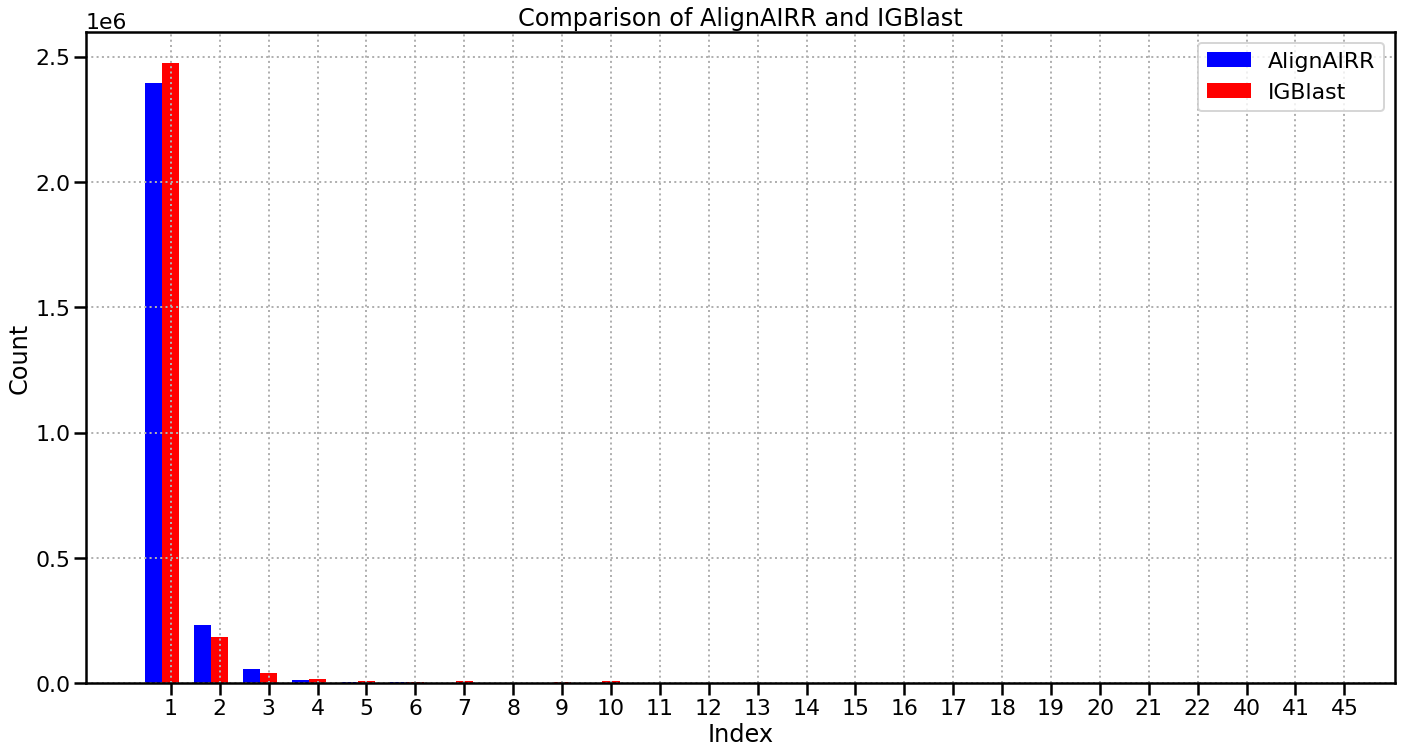

In [1161]:
Q = pd.Series(list(map(len,CV))).value_counts().iloc[:25]
P =  pd.Series(list(map(len,igb_predicted.v_call.apply(lambda x:x.split(','))))).value_counts()
#Q =Q.loc[P.index]
#Q
df = pd.concat([Q.to_frame().rename(columns={0:'AlignAIRR'}),P.to_frame().rename(columns={0:'IGBlast'})],axis=1).reset_index()#.melt()

#plt.barplot(data=kdf,x='variable',y='value')
bar_width = 0.35
index = df['index']
r1 = range(len(index))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, df['AlignAIRR'], width=bar_width, label='AlignAIRR', color='b')
plt.bar(r2, df['IGBlast'], width=bar_width, label='IGBlast', color='r')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Comparison of AlignAIRR and IGBlast')
plt.xticks([r + bar_width for r in range(len(df['index']))], df['index'])
plt.legend(loc='upper right')
plt.grid(lw=2,ls=':')
# Show the plot
plt.tight_layout()
plt.show()

In [1650]:
import numpy as np
from deap import base, creator, tools, algorithms
def custom_mutate(individual, mu, sigma, indpb):
    """Apply Gaussian mutation and clip values between 0 and 1."""
    for i in range(len(individual)):
        if np.random.rand() < indpb:
            individual[i] += np.random.normal(mu, sigma)
            individual[i] = np.clip(individual[i], 0, 1)
    return individual,

class LabelOptimizerGA:
    def __init__(self, prob_matrix, igb_predicted_v_call):
        self.prob_matrix = prob_matrix
        self.igb_predicted_v_call = igb_predicted_v_call

    def _calculate_CV(self, thresholds):
        return (self.prob_matrix >= thresholds).astype(np.uint8)

    def fitness(self, thresholds):
        CV = self._calculate_CV(thresholds)
        S = (CV+self.igb_predicted_v_call)>=2
        total = ((CV+self.igb_predicted_v_call)>0).sum(axis=1)
        S = S.sum(axis=1)
        #print(S)
        hits = S#[len(set(np.where(i > 0)[0]) & set(np.where(j > 0)[0])) > 0 for i, j in zip(CV, self.igb_predicted_v_call)]
        
        return (sum(hits) / len(hits)) + 0.1*(1-(sum(total)/len(hits))) ,

    def optimize(self, ngen=150, pop_size=100, cxpb=0.7, mutpb=0.2):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        toolbox.register("attr_float", np.random.rand)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=self.prob_matrix.shape[1])
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        toolbox.register("evaluate", self.fitness)
        toolbox.register("mate", tools.cxTwoPoint)
        #toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
        toolbox.register("mutate", custom_mutate, mu=0, sigma=0.4, indpb=0.2)

        toolbox.register("select", tools.selTournament, tournsize=3)

        pop = toolbox.population(n=pop_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=True)

        return hof[0]

    def get_optimal_labels(self, optimal_thresholds):
        return self._calculate_CV(optimal_thresholds)

    
optimizer = LabelOptimizerGA(raw_predictions['v_allele'], y_val)
optimal_thresholds = optimizer.optimize()
optimal_labels = optimizer.get_optimal_labels(optimal_thresholds)
    

KeyboardInterrupt: 

### Divide into Matches and Missmatches

In [26]:
def getting_padding_size(seq,max_length=512):
    start, end = None,None
    gap = max_length - len(seq)
    iseven = gap % 2 == 0
    whole_half_gap = gap // 2

    if iseven:
        start, end = whole_half_gap, whole_half_gap

    else:
        start, end = whole_half_gap + 1, whole_half_gap 
    return start,end

In [28]:
mismatch_df = igb_predicted[~np.array(hits)][['sequence','v_sequence_start','v_sequence_end','v_call']].copy()
# mm_gene_proba = alignairr_predicted['v_gene'][~np.array(hits)]
# mm_family_proba = alignairr_predicted['v_family'][~np.array(hits)]

mismatch_df['v_call'] = mismatch_df.v_call.apply(lambda x: x.split(','))
mismatch_df['v_call_ar'] = np.array(V)[~np.array(hits)]
mismatch_df['v_sequence_start_ar'] = alignairr_predicted['v_start'][~np.array(hits)]
mismatch_df['v_sequence_end_ar'] = alignairr_predicted['v_end'][~np.array(hits)]
mismatch_df['v_sequence_start_ar'] = mismatch_df['v_sequence_start_ar'].astype(int)
mismatch_df['v_sequence_end_ar'] = mismatch_df['v_sequence_end_ar'].astype(int)
mismatch_df_  = mismatch_df.copy()

# adjust for padding in prediction
starts,ends = [],[]
for _seq in tqdm(mismatch_df['sequence']):
    s,e = getting_padding_size(_seq)
    starts.append(s)
    ends.append(e)
    
mismatch_df['v_sequence_start_ar'] = mismatch_df['v_sequence_start_ar']-np.array(starts) #mismatch_df.progress_apply(lambda x: max(x['v_sequence_start_ar'] - ((512-len(x['sequence']))//2),0),axis=1)
mismatch_df['v_sequence_end_ar'] = mismatch_df['v_sequence_end_ar']-np.array(starts)# = mismatch_df.progress_apply(lambda x: max(x['v_sequence_end_ar'] - ((512-len(x['sequence']))//2),0),axis=1)

mm_allele_proba = calibrated_probs[~np.array(hits)]
mismatch_df['ar_allele_probabilites'] = list(map(lambda x: [x[0][v_allele_call_ohe[i]] for i in  x[1]],zip(mm_allele_proba,mismatch_df['v_call_ar'])))



C:\Users\Tomas\AppData\Local\Temp\ipykernel_28996\1034676447.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mismatch_df['v_call_ar'] = np.array(V)[~np.array(hits)]


  0%|          | 0/65852 [00:00<?, ?it/s]

In [33]:
mismatch_df

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites
154,GCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,151,244,"[IGHVF8-G45*04, IGHVF8-G45*07]","[IGHVF8-G45*08, IGHVF8-G45*06]",17,270,"[0.11764706, 0.11302211]"
158,GCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,93,389,[IGHVF8-G45*07],[IGHVF8-G45*05],95,394,[0.54385966]
195,GGTATCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,93,391,[IGHVF8-G45*04],[IGHVF8-G45*08],95,394,[0.54]
489,GAGTGACTCCTGTGCCCCACCACATGGAGCTTTACTCCACGCTTCT...,78,378,[IGHVF6-G33*02],[IGHVF6-G33*01],77,379,[0.877551]
565,GAGAGCACAGCTCCTCACCATGGACTGTACCTGGGGGATCCTCTTC...,77,369,"[IGHVF5-G29*03, IGHVF5-G29*05, IGHVF5-G29*06]",[IGHVF5-G25*03],76,374,[0.224]
...,...,...,...,...,...,...,...,...
4950878,GGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGC...,126,420,[IGHVF2-G11*01],[IGHVF2-G12*01],125,424,[0.9411765]
4950889,GAGCTCTGGGAGAGGAGCCCCAGCCTTGGGATTCCCAAGTGTTTTC...,140,432,[IGHVF2-G10*01],"[IGHVF2-G9*04, IGHVF2-G12*02, IGHVF2-G12*03]",139,437,"[0.01011378, 0.009917355, 0.0046904315]"
4950892,GGCACTGGAAGTCGCCGGTGTTTCCATTCGGTGATCAGCACTGAAC...,119,393,[IGHVF2-G14*13],[IGHVF2-G14*12],114,410,[0.5402299]
4950898,GGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCACTTGGT...,132,426,[IGHVF2-G18*02],[IGHVF2-G16*03],132,431,[0.04117647]


In [31]:
#mismatch_df.to_parquet('C:/Users/Tomas/Downloads/mismatches_single_beam_AlignAIRR.parquet')

In [29]:
match_df = igb_predicted[np.array(hits)][['sequence','v_sequence_start','v_sequence_end','v_call']].copy()
match_df['v_call'] = match_df.v_call.apply(lambda x: x.split(','))
match_df['v_call_ar'] = np.array(V)[np.array(hits)]
match_df['v_sequence_start_ar'] = alignairr_predicted['v_start'][np.array(hits)]
match_df['v_sequence_start_ar'] = match_df['v_sequence_start_ar'].astype(int)
match_df['v_sequence_end_ar'] = alignairr_predicted['v_end'][np.array(hits)]
match_df['v_sequence_end_ar'] = match_df['v_sequence_end_ar'].astype(int)

# adjust for padding in prediction
starts,ends = [],[]
for _seq in tqdm(match_df['sequence']):
    s,e = getting_padding_size(_seq)
    starts.append(s)
    ends.append(e)
    
match_df['v_sequence_start_ar'] = match_df['v_sequence_start_ar']-np.array(starts) #mismatch_df.progress_apply(lambda x: max(x['v_sequence_start_ar'] - ((512-len(x['sequence']))//2),0),axis=1)
match_df['v_sequence_end_ar'] = match_df['v_sequence_end_ar']-np.array(starts)# = mismatch_df.progress_apply(lambda x: max(x['v_sequence_end_ar'] - ((512-len(x['sequence']))//2),0),axis=1)


m_allele_proba = calibrated_probs[np.array(hits)]

match_df['ar_allele_probabilites'] = list(map(lambda x: [x[0][v_allele_call_ohe[i]] for i in  x[1]],zip(m_allele_proba,match_df['v_call_ar'])))


C:\Users\Tomas\AppData\Local\Temp\ipykernel_28996\3708098902.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  match_df['v_call_ar'] = np.array(V)[np.array(hits)]


  0%|          | 0/2693483 [00:00<?, ?it/s]

In [30]:
match_df

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites
0,GAGTGCTTTCTGAGAGTCATGGACCTCCTGCACAAGAACATGAAAC...,97,388,[IGHVF8-G39*03],[IGHVF8-G39*03],95,392,[0.9942693]
2,GCTCCTCTAAAGAAGCCCCTGGGAGCACAGCTCATCACCATGGACT...,97,389,[IGHVF5-G26*15],[IGHVF5-G26*15],96,393,[0.79464287]
4,GCTCTTTGTGGTGGCAGCAGCTACAGGTGTCCAGTCCCAGGTGCAG...,38,332,[IGHVF5-G26*15],[IGHVF5-G26*15],37,337,[0.8167539]
6,GAAAGCATCATCCAACAACCACATCCCTTCTCTACAGAAGCCTCTG...,122,416,[IGHVF5-G28*03],[IGHVF5-G28*03],120,420,[0.83760685]
8,ACCGAGGATTCACCATGGAACTGGGGCTCCGCTGGGTTTTCCTTGT...,72,367,[IGHVF2-G11*06],"[IGHVF2-G11*06, IGHVF2-G11*07, IGHVF2-G11*03]",72,370,"[0.46938777, 0.18243243, 0.12527964]"
...,...,...,...,...,...,...,...,...
4950907,GGAGCATCACCCAGCAACCACATCTGTCCTCTAGAGAATCCCCTGA...,122,416,[IGHVF5-G29*03],[IGHVF5-G29*03],120,419,[0.6]
4950908,GAGATCACCTTGAAGGAGTCTGGTCCTACGCTGGTGAAACCCACAC...,2,298,[IGHVF6-G33*03],[IGHVF6-G33*03],0,302,[1.0]
4950911,GGGTGATCAGGACTGAACAGAGAGAACTCACCATGGAGTTTGGGCT...,90,383,[IGHVF2-G18*02],[IGHVF2-G18*02],90,389,[0.9735099]
4950912,GGAGCATCACCCAGCAACCACATCTGTCCTCTAGAGAATCCCCTGA...,121,414,[IGHVF5-G29*03],[IGHVF5-G29*03],119,416,[0.9438503]


# Calibration Analysis

In [48]:
#raw_predictions,y_train
cset_v = raw_predictions['v_allele']

In [63]:
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovr = roc_auc_score(
    y_train,
    cset_v,
    multi_class="ovr",
    average="macro",
)

In [66]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_train.ravel(), cset_v.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00


In [71]:
for i in range(280):
    fpr[i], tpr[i], _ = roc_curve(y_train[:, i], cset_v[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(280):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 280

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
1.00


In [73]:
# from sklearn.metrics import RocCurveDisplay

# offset = 0
# for a in range(cset_v.shape[1]):
#     current = cset_v[offset:offset+1500,a]
#     offset+=1500
#     random_sample = np.random.choice(list(set(range(0,len(cset_v)))-set(range(offset,offset+1500))) ,size=1500,replace=False)
#     name = v_allele_call_rev_ohe[a]
    
#     RocCurveDisplay.from_predictions(
#     y_train[:, a],
#     cset_v[:, a],
#     name=f"{name} vs the rest",
#     #color="darkorange",
#     #plot_chance_level=True,
#     )
#     break

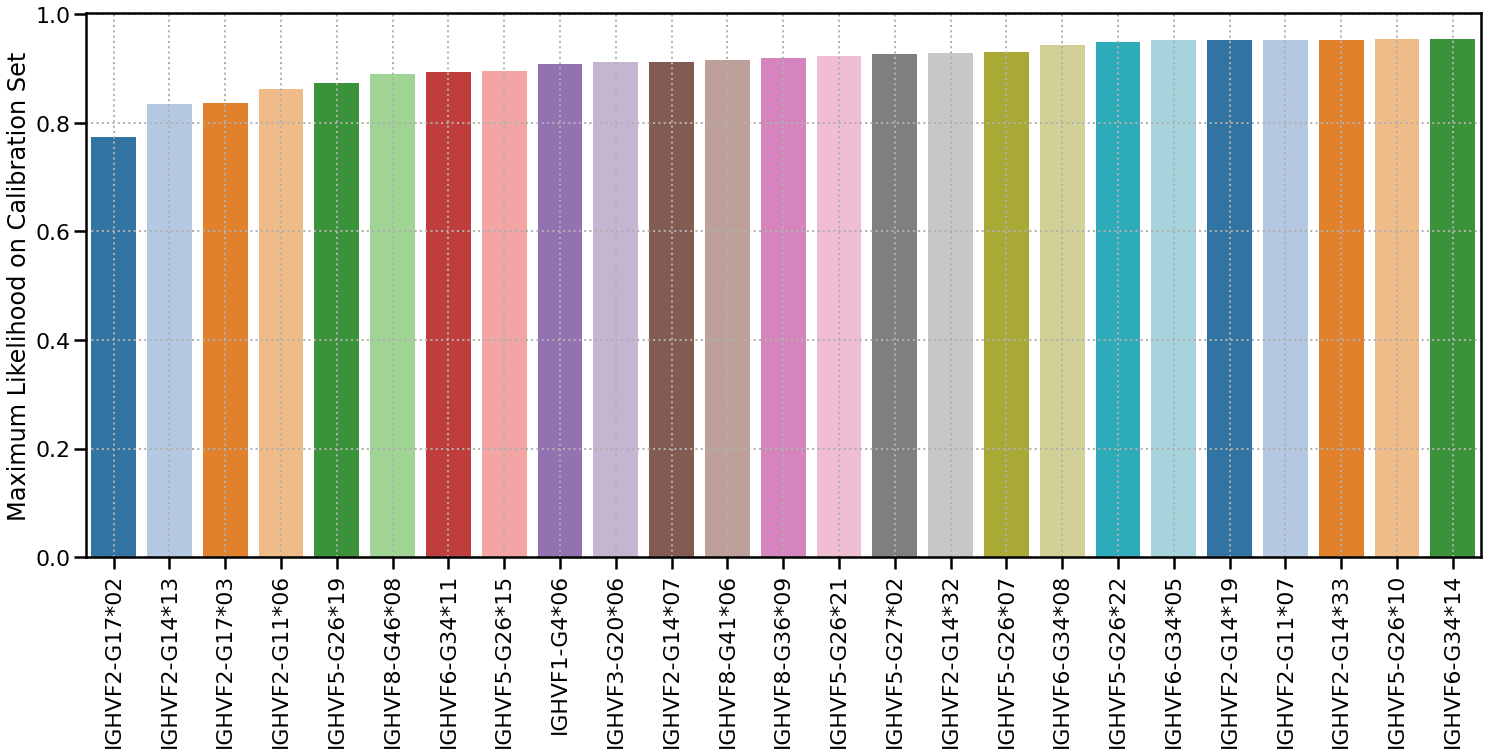

In [109]:
cdf = pd.Series(cset_v.max(axis=0),index=list(v_allele_call_ohe)).sort_values().iloc[:25]
plt.figure(figsize=(25,10))
sns.barplot(x=cdf.index,y=cdf,palette='tab20')
plt.xticks(rotation=90)
plt.grid(lw=2,ls=':')
plt.ylabel('Maximum Likelihood on Calibration Set')
plt.show()

# Mismatch Proability Difference In IGB Calls

In [110]:
missmatch_allele_probas = calibrated_probs[~np.array(hits)]

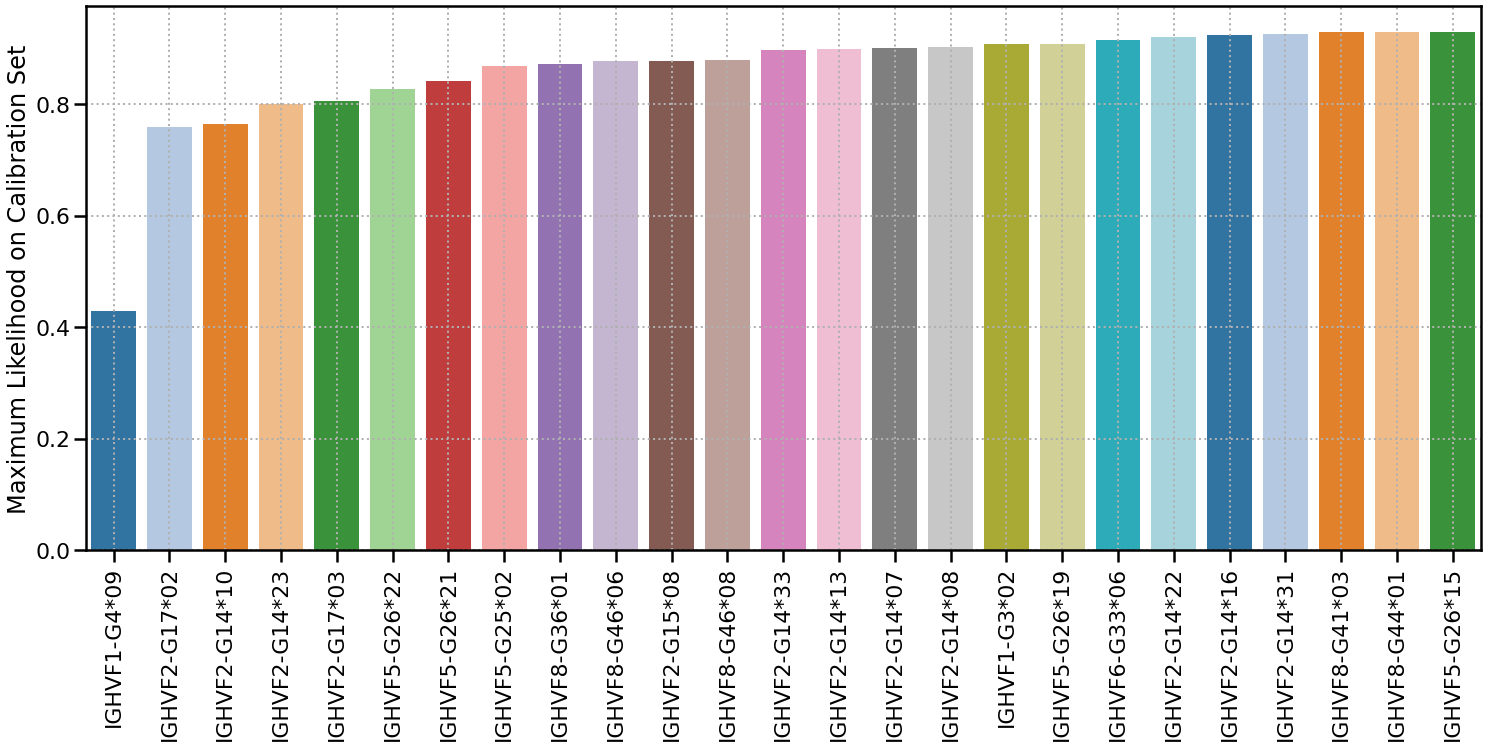

In [113]:
cdf = pd.Series(alignairr_predicted['v_allele'][np.array(hits)].max(axis=0),index=list(v_allele_call_ohe)).sort_values().iloc[:25]
plt.figure(figsize=(25,10))
sns.barplot(x=cdf.index,y=cdf,palette='tab20')
plt.xticks(rotation=90)
plt.grid(lw=2,ls=':')
plt.ylabel('Maximum Likelihood on Calibration Set')
plt.show()

In [1655]:
def get_proba_rank(probas,alleles):
    sorted_probas = np.argsort(probas)[::-1]
    ranks  = []
    for i in alleles:
        ranks.append(np.where(sorted_probas==v_allele_call_ohe[i])[0].item()+1)
    return ranks

mmp =mismatch_df.copy().reset_index(drop=True)
mmp['igb_probas'] = [[probas[v_allele_call_ohe[i]] for i in calls] for calls,probas in zip(mmp.v_call,missmatch_allele_probas)]
mmp['igb_proba_rank'] = [get_proba_rank(probas,calls) for calls,probas in zip(mmp.v_call,missmatch_allele_probas)]
mmp['ar_proba_rank'] = [get_proba_rank(probas,calls) for calls,probas in zip(mmp.v_call_ar,missmatch_allele_probas)]

In [1656]:
mmp

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites,igb_probas,igb_proba_rank,ar_proba_rank
0,GCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,151,244,"[IGHVF8-G45*04, IGHVF8-G45*07]","[IGHVF8-G45*08, IGHVF8-G45*06]",17,270,"[0.10928101, 0.13283767]","[0.0, 0.0]","[194, 182]","[183, 181]"
1,GCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,93,389,[IGHVF8-G45*07],[IGHVF8-G45*05],95,394,[0.415641],[0.0],[194],[196]
2,GGTATCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,93,391,[IGHVF8-G45*04],[IGHVF8-G45*08],95,394,[0.34832415],[0.0],[182],[193]
3,GAGTGACTCCTGTGCCCCACCACATGGAGCTTTACTCCACGCTTCT...,78,378,[IGHVF6-G33*02],[IGHVF6-G33*01],77,379,[0.8126092],[0.0],[268],[269]
4,GAGAGCACAGCTCCTCACCATGGACTGTACCTGGGGGATCCTCTTC...,77,369,"[IGHVF5-G29*03, IGHVF5-G29*05, IGHVF5-G29*06]",[IGHVF5-G25*03],76,374,[0.33252445],"[0.0, 0.0, 0.0]","[227, 246, 247]",[9]
...,...,...,...,...,...,...,...,...,...,...,...
78684,GGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGC...,126,420,[IGHVF2-G11*01],[IGHVF2-G12*01],125,424,[0.9445303],[0.0],[78],[85]
78685,GAGCTCTGGGAGAGGAGCCCCAGCCTTGGGATTCCCAAGTGTTTTC...,140,432,[IGHVF2-G10*01],"[IGHVF2-G9*04, IGHVF2-G12*02, IGHVF2-G12*03]",139,437,"[0.0076431073, 0.008655594, 0.0028505193]",[0.0],[91],"[72, 89, 90]"
78686,GGCACTGGAAGTCGCCGGTGTTTCCATTCGGTGATCAGCACTGAAC...,119,393,[IGHVF2-G14*13],[IGHVF2-G14*12],114,410,[0.55845326],[0.0],[132],[133]
78687,GGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCACTTGGT...,132,426,[IGHVF2-G18*02],[IGHVF2-G16*03],132,431,[0.057302423],[0.0],[14],[30]


In [1657]:
close_calls = mmp[mmp.apply(lambda x: (np.min(x.igb_proba_rank) - np.max(x.ar_proba_rank))==1 ,axis=1)]

In [1658]:
close_calls

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites,igb_probas,igb_proba_rank,ar_proba_rank
5,TGTTCTGCATGTTGGNTCGATACGGGGAGCTCTGAGAGAGGAGCCC...,101,195,"[IGHVF2-G18*02, IGHVF2-G18*04]",[IGHVF2-G18*01],5,207,[0.104677565],"[0.0, 0.0]","[9, 11]",[8]
12,GGTCTCTGTGTTTGCAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAG...,29,326,[IGHVF1-G4*06],[IGHVF1-G4*07],29,330,[0.74831486],[0.0],[94],[93]
15,CCATATCATAAAAACCATCTACGGGTTTCCTTTTCTGTCCTCCTCC...,92,167,"[IGHVF3-G19*02, IGHVF3-G19*03, IGHVF3-G19*04]",[IGHVF3-G19*01],4,234,[0.25852633],"[0.0, 0.0, 0.0]","[43, 44, 45]",[42]
22,GAGCTCTGAGAGCGGAGCCCCAGCCCCAGAATTCCCAGGTGTTTTC...,159,336,[IGHVF1-G1*01],[IGHVF5-G30*01],35,337,[0.4403939],[0.0],[280],[279]
35,GGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACC...,94,390,"[IGHVF8-G45*07, IGHVF8-G45*08]",[IGHVF8-G45*06],98,397,[0.9492672],"[0.0, 0.0]","[182, 183]",[181]
...,...,...,...,...,...,...,...,...,...,...,...
78658,GAGCTCTCAGAGAGGTGCCTTAGCCCTGGATTCCAAGGCATTTCCA...,138,432,[IGHVF2-G12*02],"[IGHVF2-G11*01, IGHVF2-G12*01]",138,436,"[0.49542227, 0.55168235]",[0.0],[87],"[79, 86]"
78659,GAGCTCTCAGAGAGGTGCCTTAGCCCTGGATTCCAAGGCATTTCCA...,138,373,[IGHVF2-G12*01],[IGHVF2-G12*02],150,453,[0.12412812],[0.0],[82],[81]
78660,GGGGAGAGGAGCCCCAGCCTTGGGATTCCCAAGTGTTTTCATTCAG...,133,427,[IGHVF1-G4*06],"[IGHVF1-G4*07, IGHVF2-G17*01]",133,432,"[0.27299786, 0.15693992]",[0.0],[94],"[93, 36]"
78666,GGAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAG...,126,420,[IGHVF2-G11*06],[IGHVF2-G11*07],127,425,[0.29481626],[0.0],[83],[82]


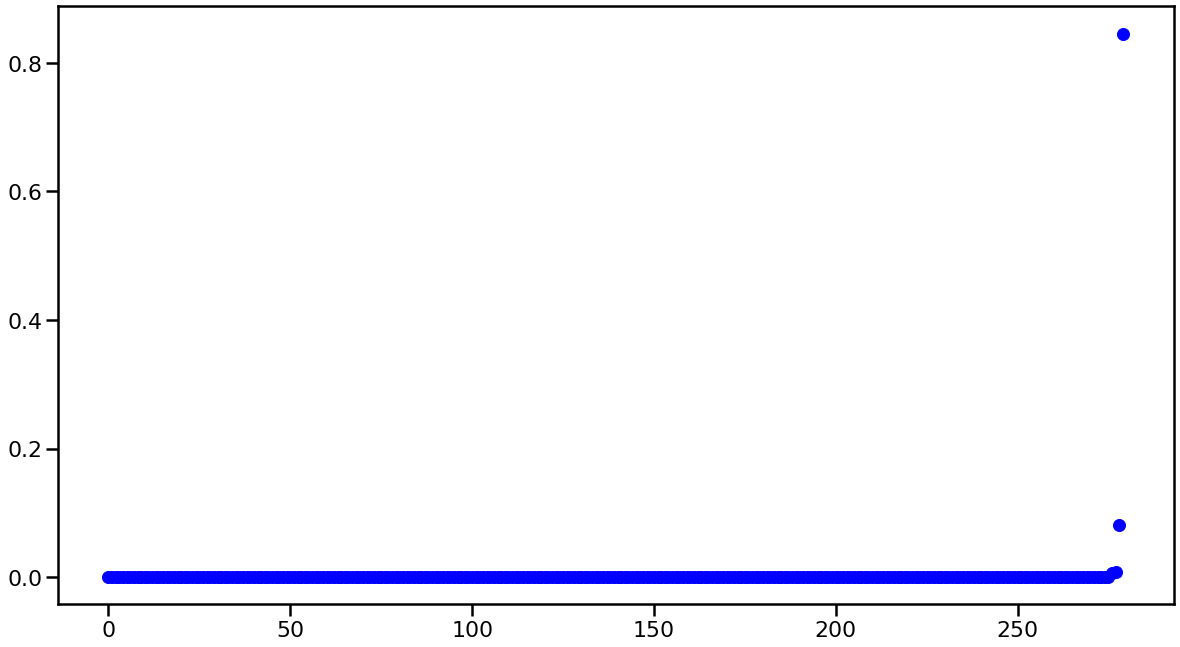

In [1586]:
plt.plot(np.sort(alignairr_predicted['v_allele'][5][::-1]),'bo')

In [1587]:
idx = 1435
sortedp = np.sort(missmatch_allele_probas[idx])[::-1]
args = np.argsort(missmatch_allele_probas[idx])[::-1]

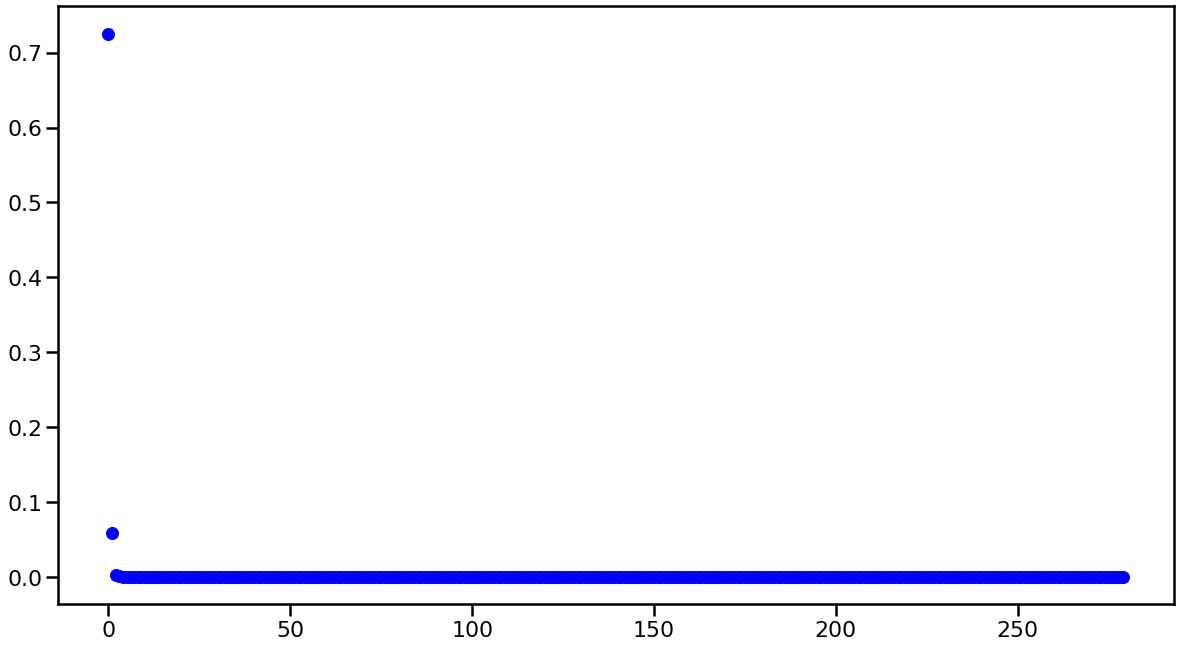

In [1610]:
x = np.arange(0,len(sortedp))
plt.plot(sortedp,'bo')


In [964]:
close_calls

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites,igb_probas,igb_proba_rank,ar_proba_rank
1,GGTATCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,93,391,[IGHVF8-G45*04],[IGHVF8-G45*08],95,394,[0.34832415],[0.14938799],[2],[1]
3,ACCATGGACTGTACCTGGGGGATCCTCTTCTTGGTGGCAGCTGCCA...,61,356,"[IGHVF5-G29*03, IGHVF5-G29*05, IGHVF5-G29*06]","[IGHVF5-G29*04, IGHVF5-G25*03]",75,373,"[0.14403006, 0.124536745]","[0.00016971568, 0.059406687, 0.044563416]","[22, 3, 4]","[1, 2]"
5,GAGTGACTCCTGTGCCCCACCACATGGAGCTTTACTCCACGCTTCT...,78,378,[IGHVF6-G33*02],[IGHVF6-G33*01],77,379,[0.8126092],[0.08071973],[2],[1]
6,GAGAGCACAGCTCCTCACCATGGACTGTACCTGGGGGATCCTCTTC...,77,369,"[IGHVF5-G29*03, IGHVF5-G29*05, IGHVF5-G29*06]",[IGHVF5-G25*03],76,374,[0.33252445],"[0.014902402, 0.019536134, 0.083717085]","[6, 3, 2]",[1]
7,ATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCAC...,88,333,[IGHVF8-G45*07],[IGHVF8-G45*04],39,336,[0.88376516],[0.05215052],[2],[1]
...,...,...,...,...,...,...,...,...,...,...,...
82612,GAGGTGTTTCCATTCAGTGATCAGCACTGAACACAGAGGACTCACC...,104,397,[IGHVF2-G7*03],[IGHVF2-G7*01],105,404,[0.34012276],[0.04378307],[2],[1]
82615,GGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGC...,126,420,[IGHVF2-G11*01],[IGHVF2-G12*01],125,424,[0.9445303],[0.31549892],[2],[1]
82616,GAGCTCTGGGAGAGGAGCCCCAGCCGTGAGATTCCCAGGAGTTTCC...,140,433,[IGHVF2-G10*02],[IGHVF2-G12*02],140,438,[0.15080576],[0.06442674],[2],[1]
82618,GGCACTGGAAGTCGCCGGTGTTTCCATTCGGTGATCAGCACTGAAC...,119,393,[IGHVF2-G14*13],[IGHVF2-G14*12],114,410,[0.55845326],[0.088284604],[2],[1]


# Call Probability Analysis

In [1175]:
single_call_ = mismatch_df.apply(lambda x: len(x['v_call']) == len(x['v_call_ar']) == 1 ,axis=1)
single_call = mismatch_df[single_call_].copy()
single_call.ar_allele_probabilites = single_call.ar_allele_probabilites.apply(lambda x: x[0])

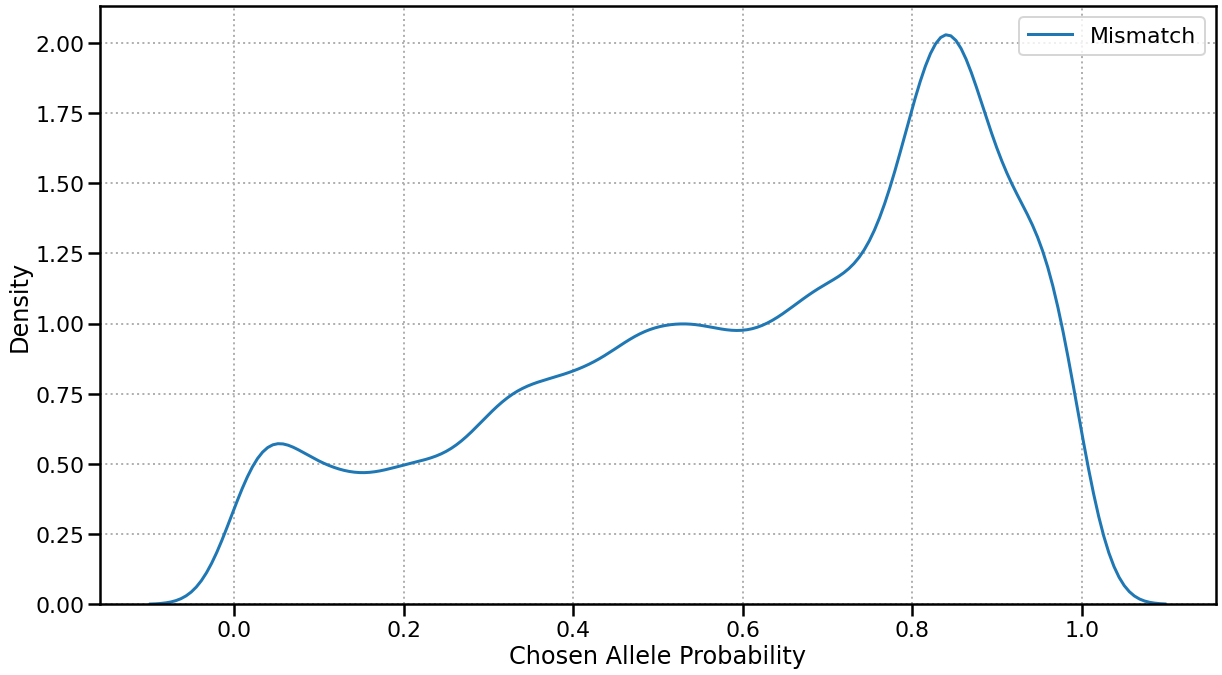

In [1176]:
sns.kdeplot(single_call.ar_allele_probabilites,label='Mismatch')
#sns.kdeplot(match_df.ar_allele_probabilites,label='Match')
plt.xlabel('Chosen Allele Probability')
plt.grid(lw=2,ls=':')
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'agg_score'

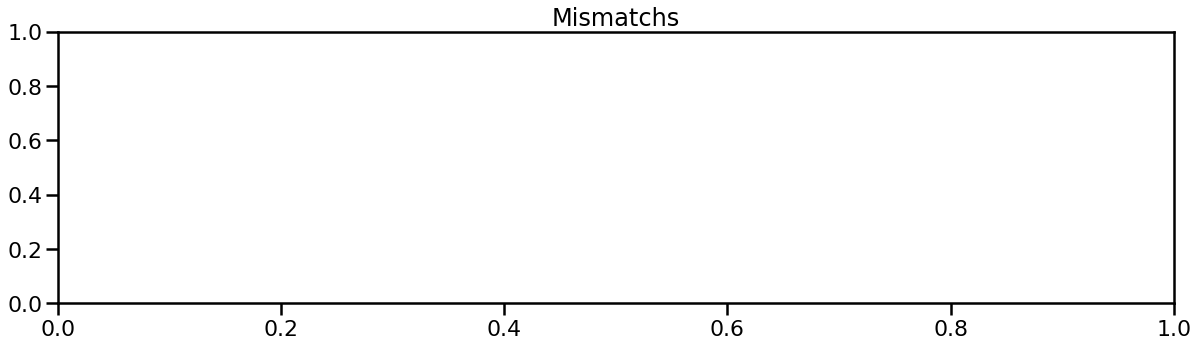

In [1174]:
plt.subplot(2,1,1)
plt.title('Mismatchs')
temp = pd.concat([mismatch_df.v_call_ar.apply(len),mismatch_df.agg_score],axis=1)
sns.boxplot(temp,x='v_call_ar',y='agg_score')
plt.ylabel('Likelihood Product')
plt.xlabel('Number of Calls')
plt.subplot(2,1,2)
plt.title('Matchs')
temp = pd.concat([match_df.v_call_ar.apply(len),match_df.agg_score],axis=1)
sns.boxplot(temp,x='v_call_ar',y='agg_score')
plt.xlabel('Number of Calls')
plt.ylabel('Likelihood Product')

plt.tight_layout()

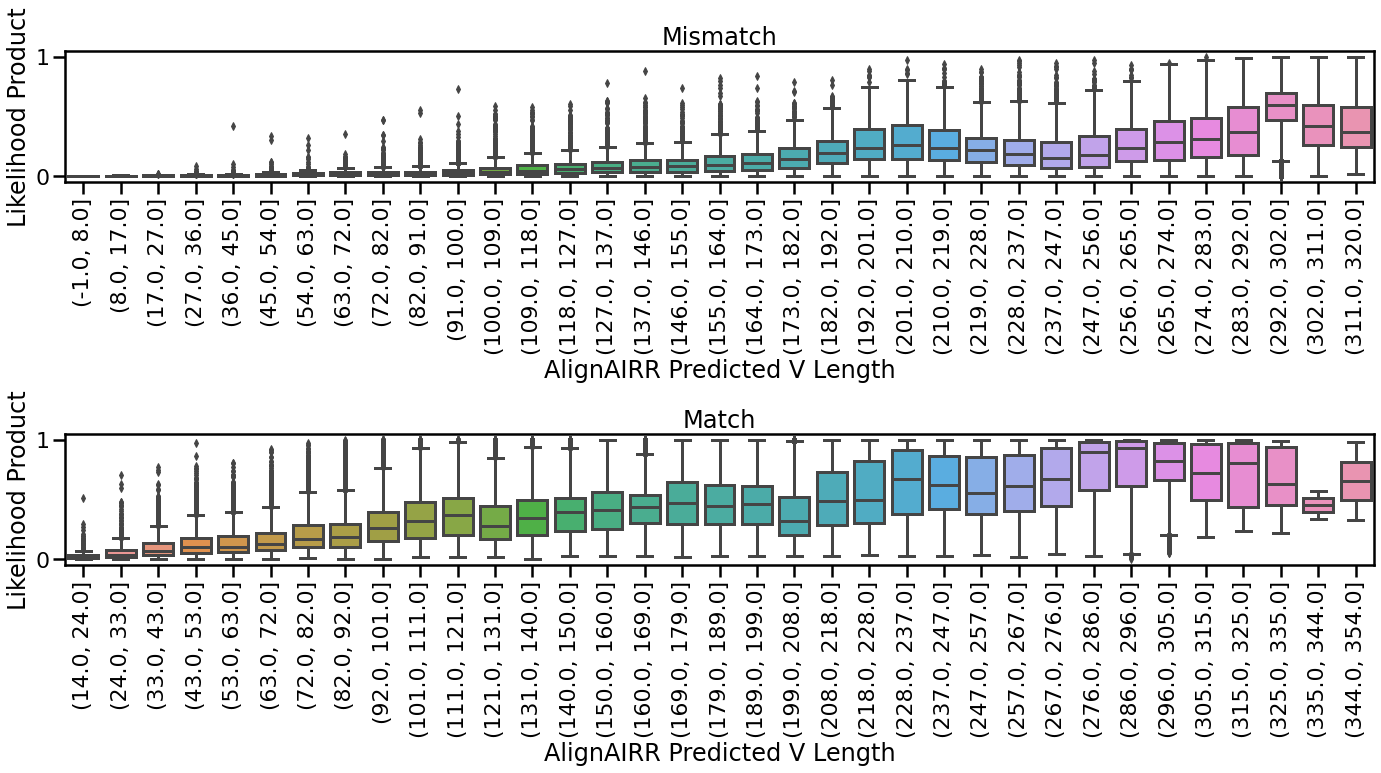

In [125]:
from scipy.stats import pearsonr
plt.subplot(2,1,1)
plt.title('Mismatch')
var_l = pd.cut(mismatch_df['v_sequence_end_ar']-mismatch_df['v_sequence_start_ar'],bins=35,precision=0)
sns.boxplot(x=var_l,y=mismatch_df.agg_score)
plt.xticks(rotation=90)
plt.xlabel('AlignAIRR Predicted V Length')
plt.ylabel("Likelihood Product")
plt.subplot(2,1,2)
plt.title('Match')
var_l = pd.cut(match_df['v_sequence_end']-match_df['v_sequence_start'],bins=35,precision=0)
sns.boxplot(x=var_l,y=match_df.agg_score)
plt.xticks(rotation=90)
plt.xlabel('AlignAIRR Predicted V Length')
plt.ylabel("Likelihood Product")

plt.tight_layout()
plt.show()


In [126]:
single_call.v_call = single_call.v_call.apply(lambda x: x[0])
single_call.v_call_ar = single_call.v_call_ar.apply(lambda x: x[0])

In [127]:
def cc(x):
    v_call = x['v_call']
    ar_call = x['v_call_ar']
    v_call = decompose_call(v_call)
    ar_call = decompose_call(ar_call)
    try:
        if v_call[0] ==ar_call[0] and v_call[1]==ar_call[1]:
            if int(v_call[2])+1 == int(ar_call[2]) or int(v_call[2])-1 == int(ar_call[2]):
                return True
            else:
                return False
        else:
            return False
    except:
        return False
single_call.apply(cc,axis=1).sum()/len(single_call)

0.7786004128995515

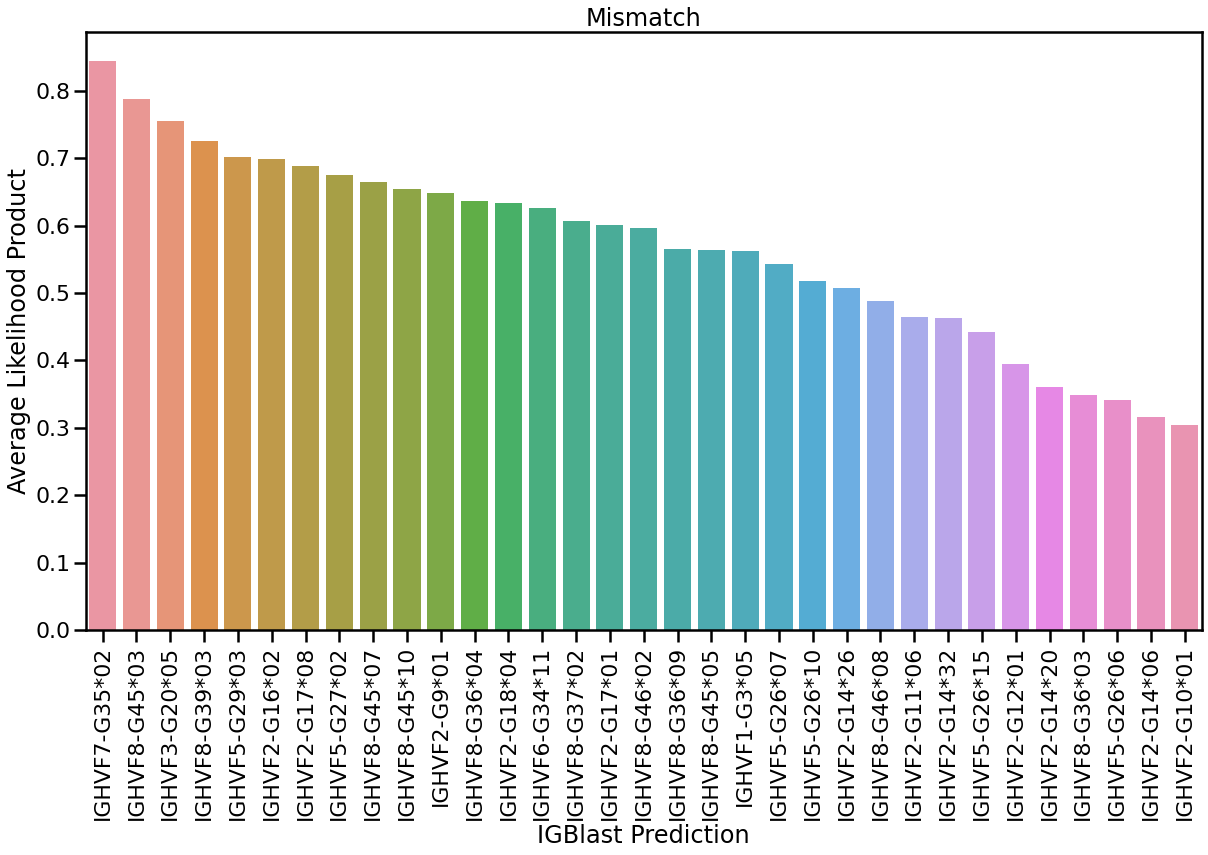

In [128]:
plt.title('Mismatch')
temp = single_call.groupby('v_call').agg(['mean','count'])['agg_score']
temp = temp[temp['count'] > 300].sort_values(by='mean',ascending=False)
sns.barplot(x=temp.index,y=temp['mean'])
plt.xticks(rotation=90)
plt.ylabel('Average Likelihood Product')
plt.xlabel('IGBlast Prediction')
plt.show()

# Add Remove Distributions

Text(0.5, 0, 'Number of Nucleotides')

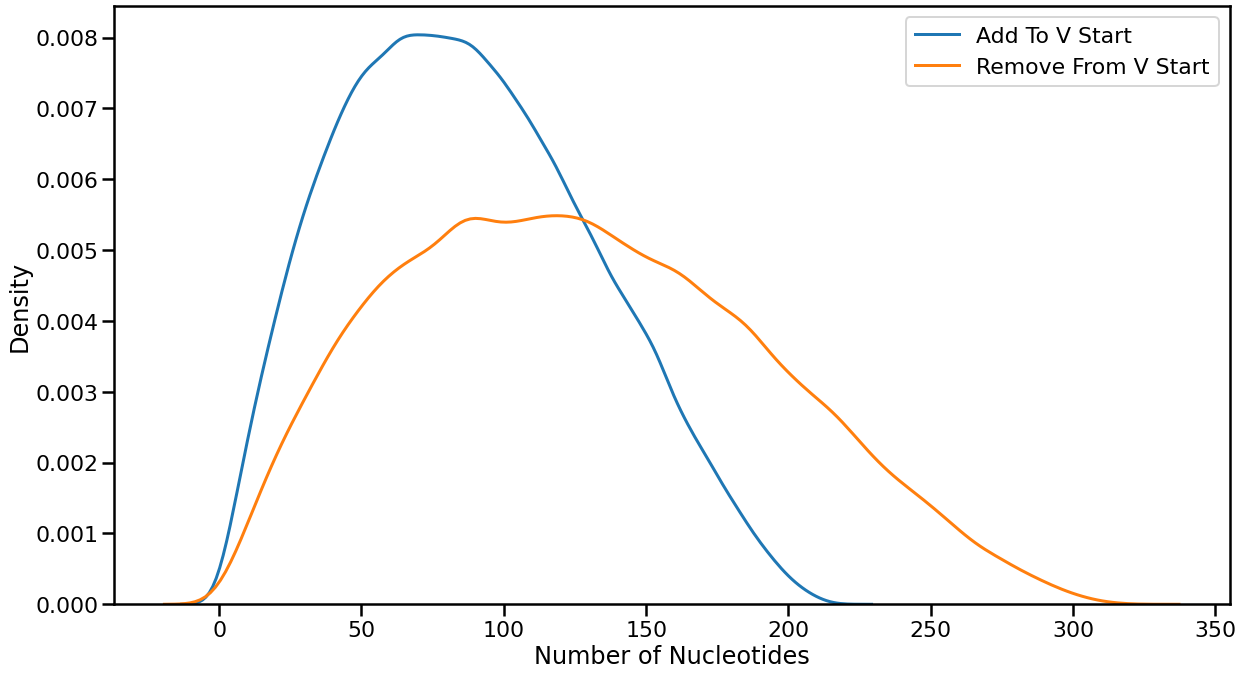

In [453]:
import scipy.stats as st
nucleotide_add_distribution = st.beta(2, 3)
nucleotide_remove_distribution = st.beta(2, 3)

sns.kdeplot((nucleotide_add_distribution.rvs(100000)*220).astype(int),label='Add To V Start')
sns.kdeplot((nucleotide_remove_distribution.rvs(100000)*320).astype(int),label='Remove From V Start')
plt.legend()
plt.xlabel('Number of Nucleotides')

# Call Distribution

In [23]:
AR_cp = pd.Series(list(map(len,V))).value_counts()
AR_cp /=AR_cp.sum()
IGB_cp = pd.Series(list(map(len,igb_predicted['v_call'].apply(lambda x: x.split(','))))).value_counts()/len(AR_cp)
IGB_cp/=IGB_cp.sum()

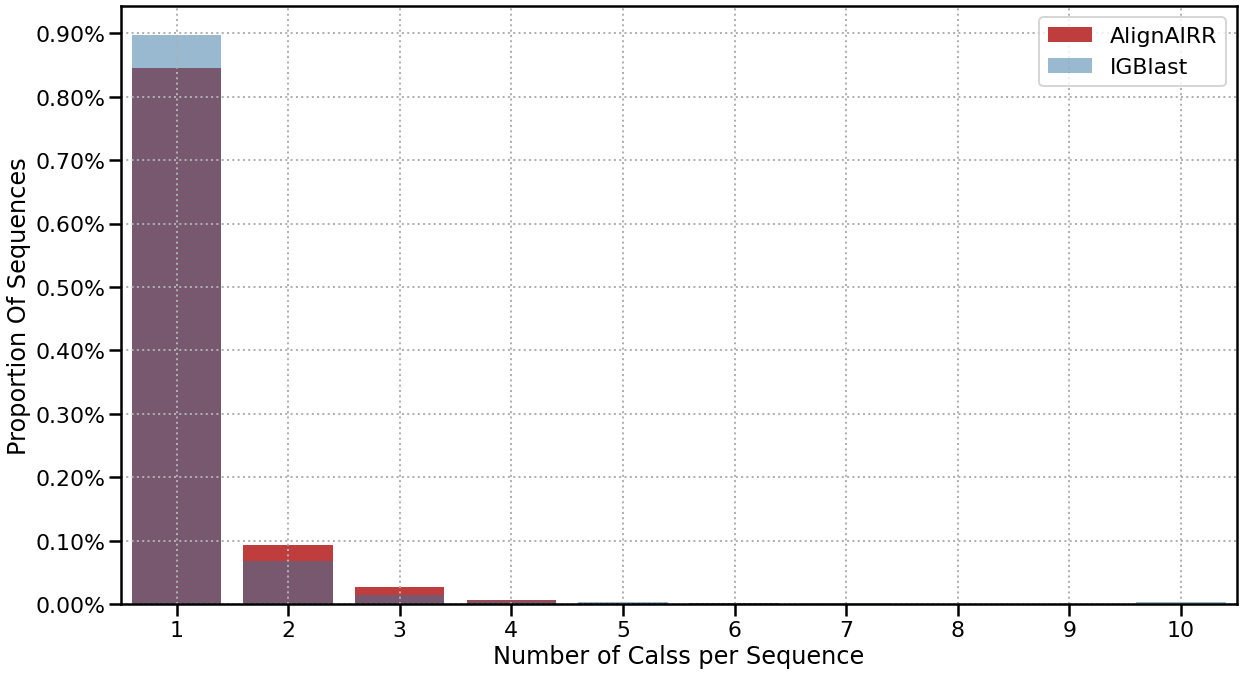

In [24]:
import matplotlib.ticker as mtick

sns.barplot(x=AR_cp.index,y=AR_cp,color='tab:red',label='AlignAIRR')
ax = sns.barplot(x=IGB_cp.index,y=IGB_cp,color='tab:blue',alpha=0.5,label='IGBlast')
plt.yticks(np.arange(0,1,0.1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Number of Calss per Sequence')
plt.ylabel('Proportion Of Sequences')
plt.legend()
plt.grid(lw=2,ls=':')

In [155]:
ths = np.linspace(0,1,100)
aggrement = []
c1_precentage = []
c2_precentage = []
c3_precentage = []
for i in tqdm(ths):
    Vtemp = extract_prediction_alleles(predicted['v_allele'],th=i)
    hits = [len(set(i.split(','))&set(j)) > 0 for i,j in zip(igb_predicted.v_call,Vtemp)]
    hratio = sum(hits)/len(hits)
    aggrement.append(hratio)
    vc = pd.Series(list(map(len,Vtemp))).value_counts()
    vc /=len(hits)
    c1_precentage.append(vc[1])
    c2_precentage.append(0 if 2 not in vc else vc[2])
    c3_precentage.append(0 if 3 not in vc else vc[3])


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2759335 [00:00<?, ?it/s]

KeyboardInterrupt: 

# V Start and End Position Prediction

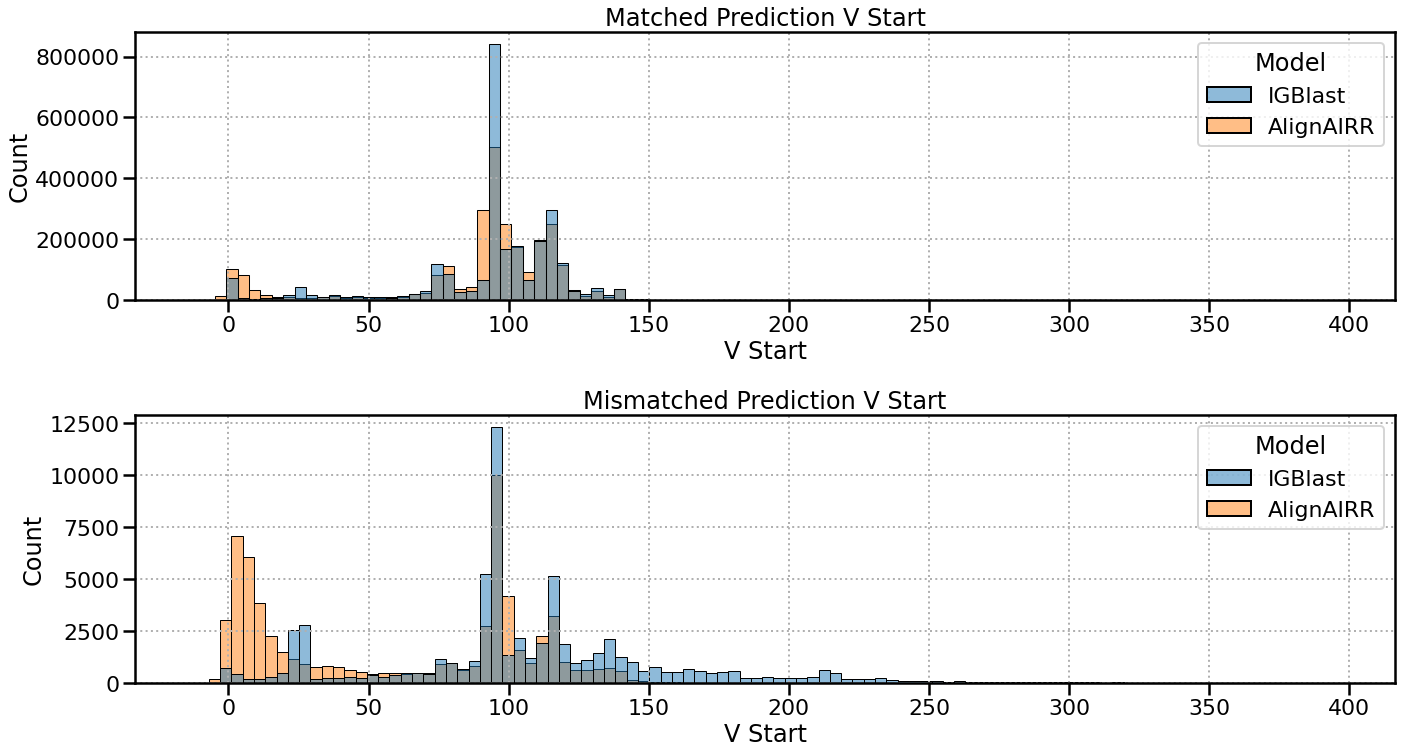

In [34]:
plt.subplot(2,1,1)
vstemp = pd.DataFrame({'V Start':match_df['v_sequence_start'].to_list()+match_df['v_sequence_start_ar'].to_list(),
                      'Model':['IGBlast']*len(match_df)+['AlignAIRR']*len(match_df)})
ax1 = sns.histplot(data=vstemp,x='V Start',hue='Model',bins=100)
plt.title('Matched Prediction V Start')
plt.xlabel('V Start')
plt.grid(lw=2,ls=':')
plt.subplot(2,1,2,sharex =ax1)
vstemp = pd.DataFrame({'V Start':mismatch_df['v_sequence_start'].to_list()+mismatch_df['v_sequence_start_ar'].to_list(),
                      'Model':['IGBlast']*len(mismatch_df)+['AlignAIRR']*len(mismatch_df)})
sns.histplot(data=vstemp,x='V Start',hue='Model',bins=100)
plt.title('Mismatched Prediction V Start')
plt.xlabel('V Start')
plt.grid(lw=2,ls=':')

plt.tight_layout()

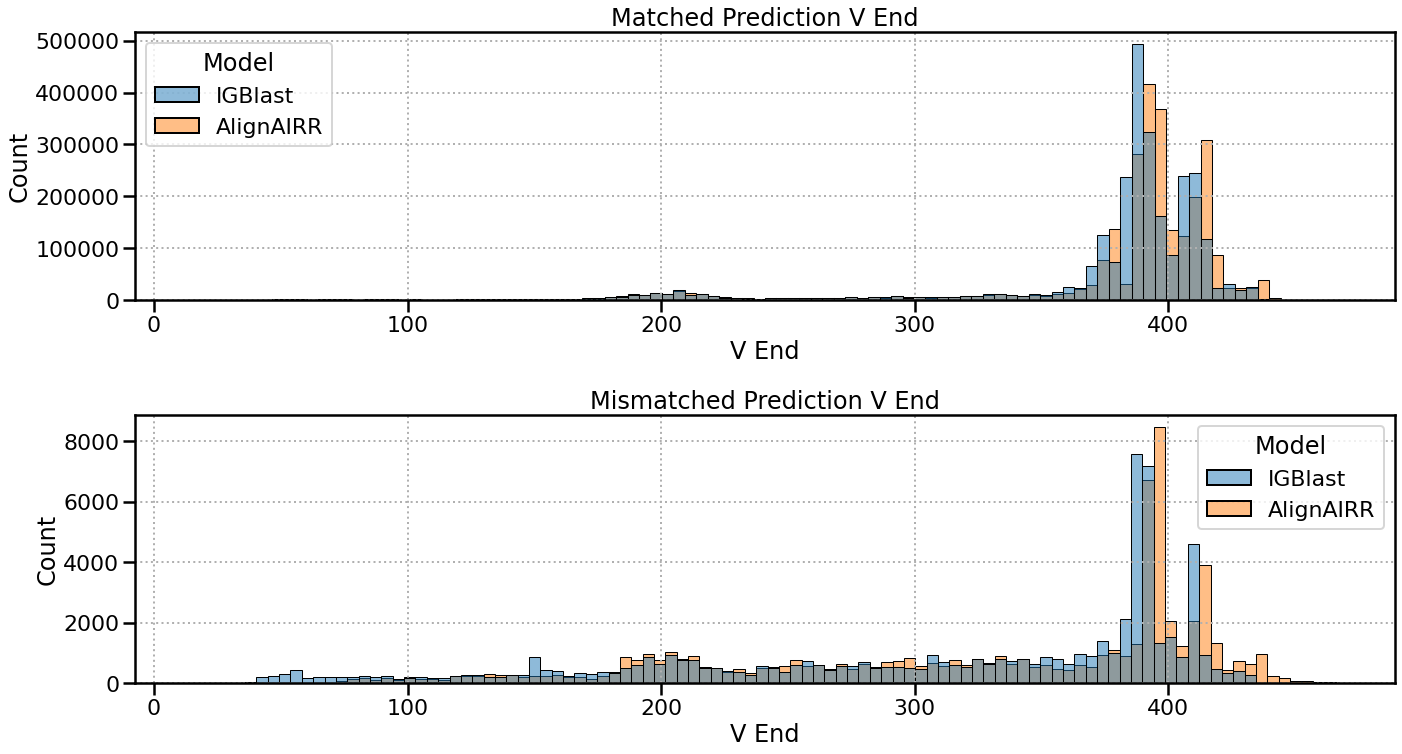

In [35]:
plt.subplot(2,1,1)
vstemp = pd.DataFrame({'V End':match_df['v_sequence_end'].to_list()+match_df['v_sequence_end_ar'].to_list(),
                      'Model':['IGBlast']*len(match_df)+['AlignAIRR']*len(match_df)})
ax1 = sns.histplot(data=vstemp,x='V End',hue='Model',bins=100)
plt.title('Matched Prediction V End')
plt.xlabel('V End')
plt.grid(lw=2,ls=':')
plt.subplot(2,1,2,sharex=ax1)
vstemp = pd.DataFrame({'V End':mismatch_df['v_sequence_end'].to_list()+mismatch_df['v_sequence_end_ar'].to_list(),
                      'Model':['IGBlast']*len(mismatch_df)+['AlignAIRR']*len(mismatch_df)})
sns.histplot(data=vstemp,x='V End',hue='Model',bins=100)
plt.title('Mismatched Prediction V End')
plt.xlabel('V End')
plt.grid(lw=2,ls=':')
plt.tight_layout()

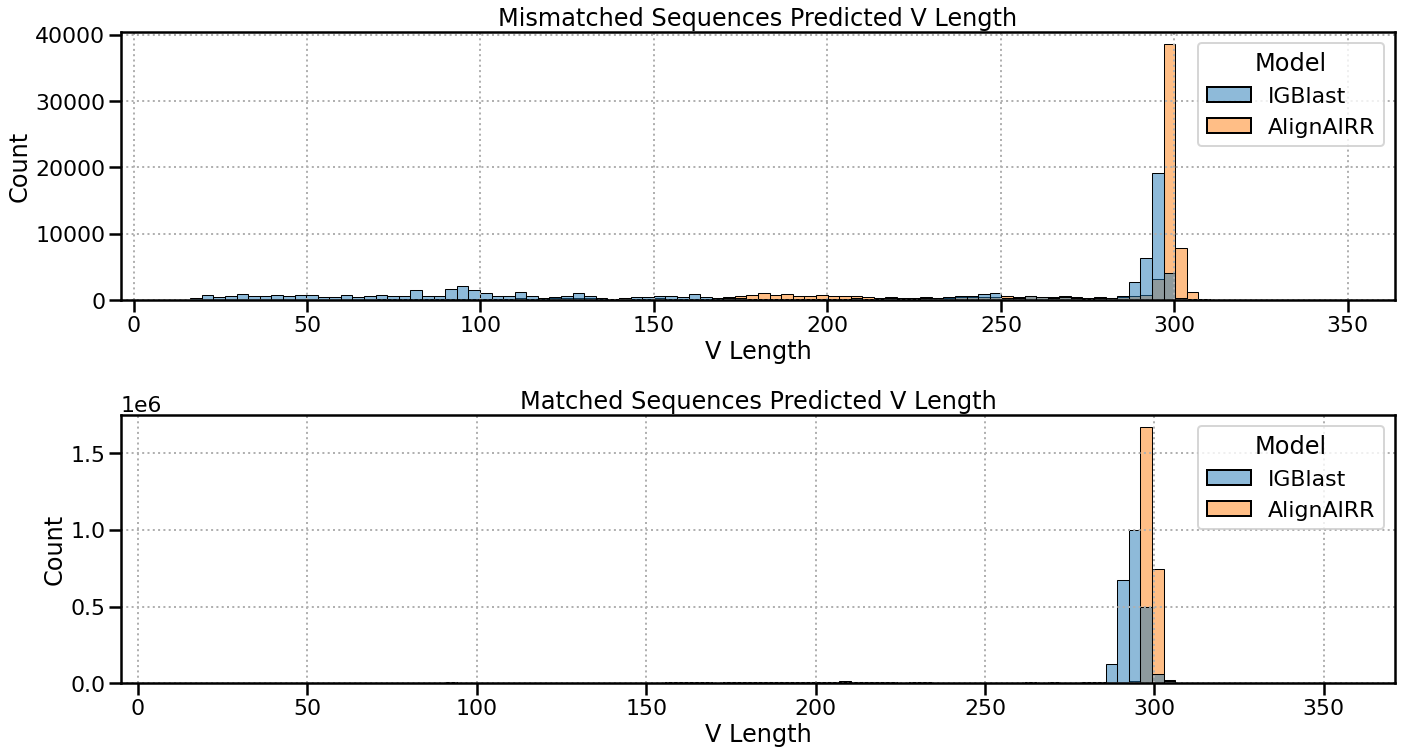

In [1185]:
plt.subplot(2,1,1)
ldf = pd.DataFrame({
    'V Length':(mismatch_df['v_sequence_end']-mismatch_df['v_sequence_start']).to_list()+(mismatch_df['v_sequence_end_ar']-mismatch_df['v_sequence_start_ar']).to_list(),
    'Model': ['IGBlast']*len(mismatch_df)+['AlignAIRR']*len(mismatch_df)
})

sns.histplot(data=ldf,x='V Length',hue='Model',bins=100)
plt.grid(lw=2,ls=':')
plt.title('Mismatched Sequences Predicted V Length')

plt.subplot(2,1,2)
ldf = pd.DataFrame({
    'V Length':(match_df['v_sequence_end']-match_df['v_sequence_start']).to_list()+(match_df['v_sequence_end_ar']-match_df['v_sequence_start_ar']).to_list(),
    'Model': ['IGBlast']*len(match_df)+['AlignAIRR']*len(match_df)
})

sns.histplot(data=ldf,x='V Length',hue='Model',bins=100)
plt.grid(lw=2,ls=':')
plt.title('Matched Sequences Predicted V Length')

plt.tight_layout()

In [1186]:
v_mismatch_df = mismatch_df.copy()

In [1187]:
v_mismatch_df['AlignAIRR_V'] = v_mismatch_df.apply(lambda x: x['sequence'][x['v_sequence_start_ar']:x['v_sequence_end_ar']],axis=1)
v_mismatch_df['IGBlast_V'] = v_mismatch_df.apply(lambda x: x['sequence'][x['v_sequence_start']:x['v_sequence_end']],axis=1)

In [1188]:
v_mismatch_df['IGBlast_V_Length'] = v_mismatch_df['IGBlast_V'].str.len()
v_mismatch_df['AlignAIRR_V_Length'] = v_mismatch_df['AlignAIRR_V'].str.len()
v_mismatch_df['Predicted_Length_Difference'] = np.abs(v_mismatch_df['AlignAIRR_V_Length']-v_mismatch_df['IGBlast_V_Length'])

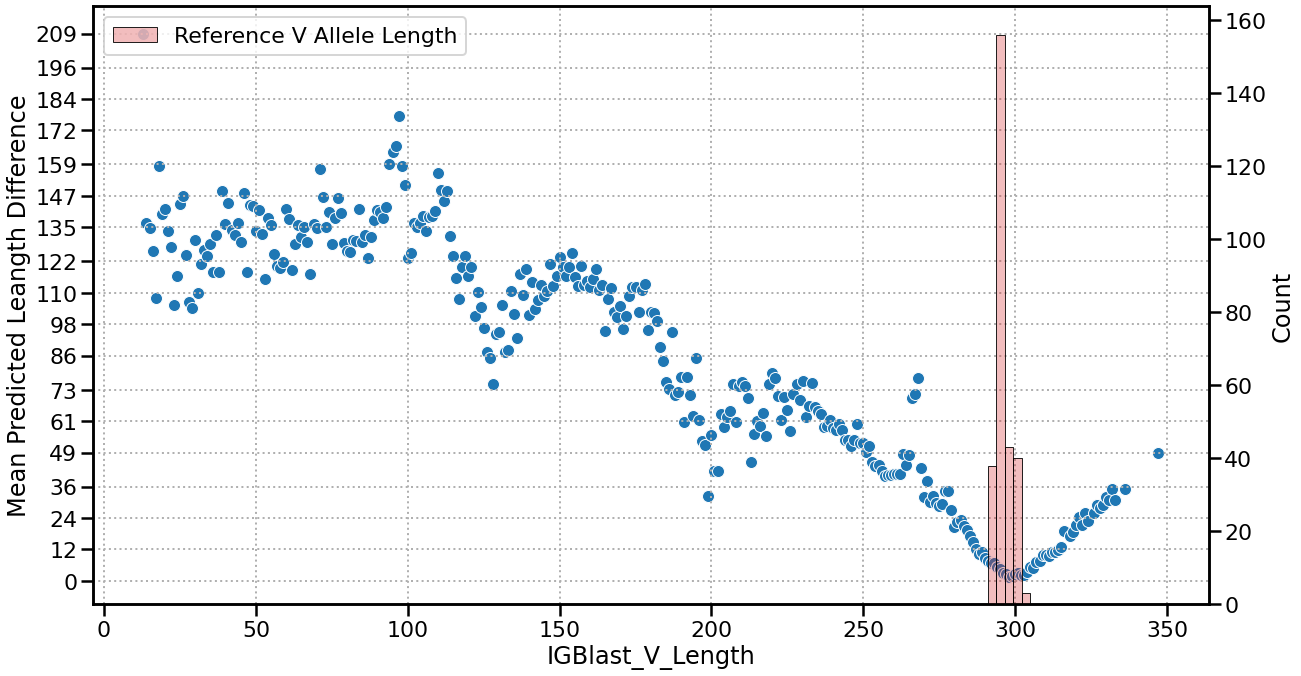

In [1189]:
igbvl = v_mismatch_df.groupby('IGBlast_V_Length').mean().reset_index()

ax = sns.scatterplot(x=igbvl.IGBlast_V_Length,y=igbvl.Predicted_Length_Difference)
plt.yticks(np.linspace(0,max(igbvl.Predicted_Length_Difference),18).astype(int))
plt.grid(lw=2,ls=':')
plt.ylabel('Mean Predicted Leangth Difference')
ax2 = ax.twinx()

#sns.histplot(other_metric_values, ax=ax2, color='r', alpha=0.5, bins=15)

sns.histplot(list(map(len,list(V_Alleles.values()))),ax=ax2,bins=5,color='tab:red',alpha=0.3,label='Reference V Allele Length')

plt.legend()

In [1190]:
v_mismatch_df['IGBlast_V_Length_Interval'] = pd.cut(v_mismatch_df['IGBlast_V_Length'],35,precision=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


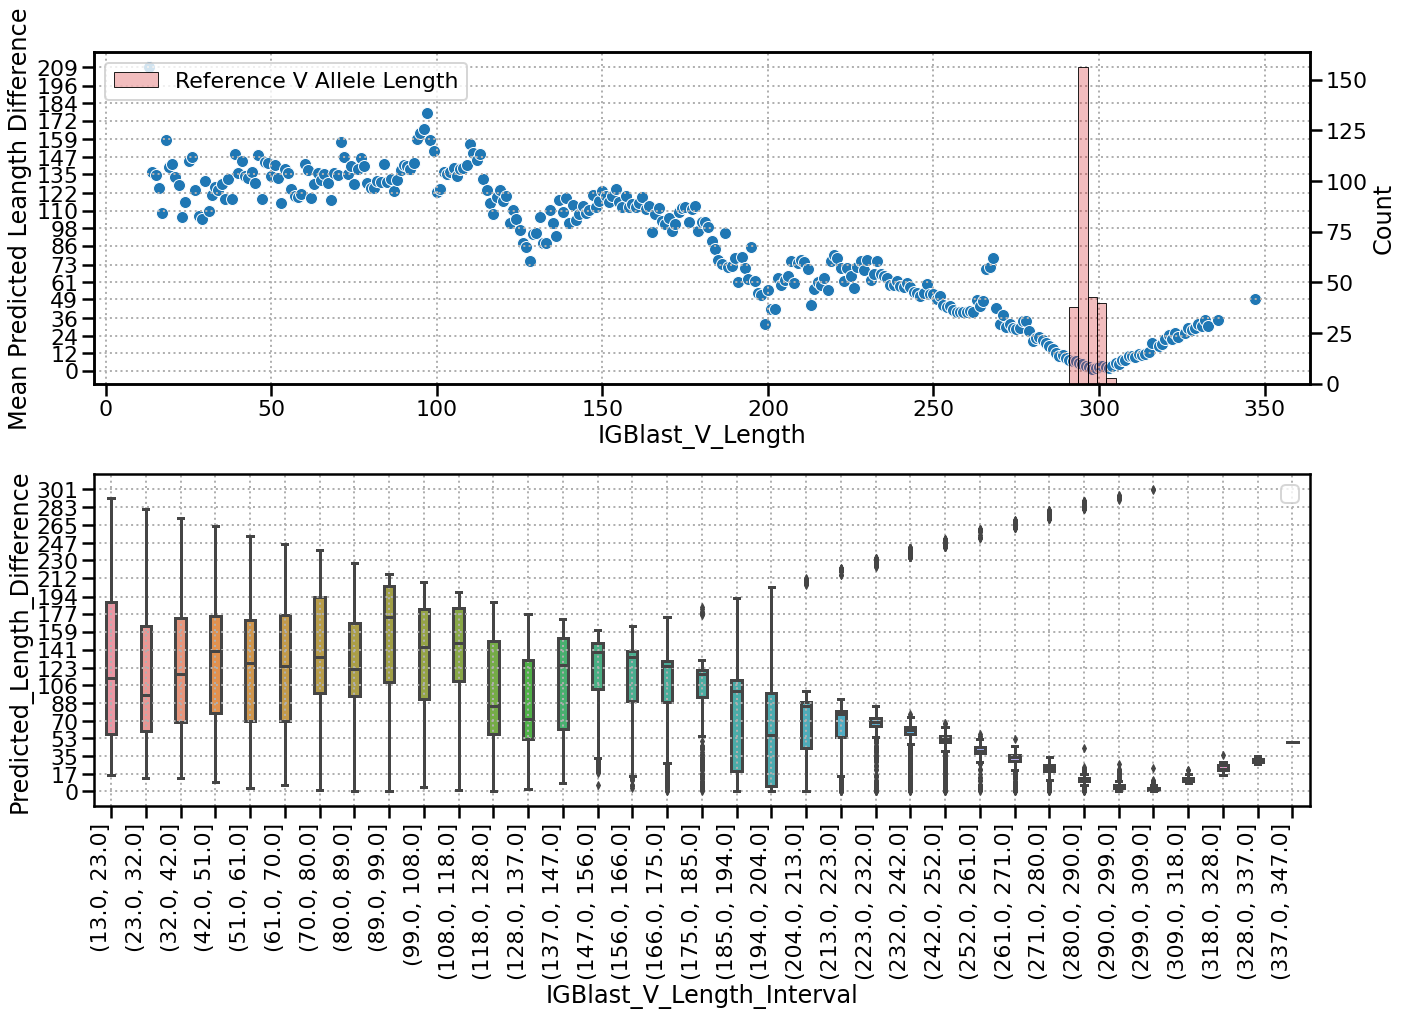

In [1191]:
plt.figure(figsize=(20,14))
plt.subplot(2,1,1)

igbvl = v_mismatch_df.groupby('IGBlast_V_Length').mean().reset_index()

ax = sns.scatterplot(x=igbvl.IGBlast_V_Length,y=igbvl.Predicted_Length_Difference)
plt.yticks(np.linspace(0,max(igbvl.Predicted_Length_Difference),18).astype(int))
plt.grid(lw=2,ls=':')
plt.ylabel('Mean Predicted Leangth Difference')
ax2 = ax.twinx()

#sns.histplot(other_metric_values, ax=ax2, color='r', alpha=0.5, bins=15)

sns.histplot(list(map(len,list(V_Alleles.values()))),ax=ax2,bins=5,color='tab:red',alpha=0.3,label='Reference V Allele Length')

plt.legend()

plt.subplot(2,1,2)
va = np.array(list(map(len,list(V_Alleles.values()))))

ax = sns.boxplot(data=v_mismatch_df,x='IGBlast_V_Length_Interval',y='Predicted_Length_Difference',width=0.3)
plt.yticks(np.linspace(0,max(v_mismatch_df.Predicted_Length_Difference),18).astype(int))
plt.grid(lw=2,ls=':')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
#ax.set_xticks(np.linspace(min(va),max(va),35),ax.get_xticklabels())
#ax2 = ax.twinx()

# #sns.histplot(other_metric_values, ax=ax2, color='r', alpha=0.5, bins=15)

#va  =  ((b-a)*((va-va.min())/(va.max()-va.min()))) + a

#sns.histplot(va,ax=ax,bins=15,color='tab:red',alpha=0.3,label='Reference V Allele Length',)
plt.tight_layout()
plt.legend()
plt.show()

In [1193]:
vreference_allingment = allign_sequences(list(V_Alleles.values()))
vadf = pd.DataFrame(data=[list(str(i.seq)) for i in vreference_allingment])
vadf


,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
0,C,A,G,G,T,G,C,A,G,C,...,G,C,G,A,G,A,G,A,-,-
1,C,A,G,G,T,G,C,A,G,C,...,G,C,G,A,G,A,G,A,-,-
2,C,A,G,G,T,G,C,A,G,C,...,G,C,G,A,G,A,G,A,-,-
3,C,A,G,G,T,G,C,A,G,C,...,G,C,G,A,G,A,G,A,-,-
4,C,A,G,G,T,G,C,A,G,C,...,G,C,G,A,G,A,G,A,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,C,A,G,G,T,A,C,A,G,C,...,G,C,A,A,G,A,-,-,-,-
276,C,A,G,G,T,G,C,A,G,C,...,G,C,G,A,G,A,G,A,-,-
277,C,A,G,G,T,G,C,A,G,C,...,G,C,G,A,G,A,G,A,-,-
278,C,A,G,G,T,G,C,A,G,C,...,G,C,G,A,G,A,G,A,-,-


# Global Mismatch Analysis

### Single Call

In [147]:
single_call_ = mismatch_df.apply(lambda x: len(x['v_call']) == len(x['v_call_ar']) == 1 ,axis=1)

In [148]:
single_call = mismatch_df[single_call_].copy()
single_call['v_call'] = single_call['v_call'].apply(lambda x: x[0])
single_call['v_call_ar'] = single_call['v_call_ar'].apply(lambda x: x[0])

In [149]:
all_unique_alleles = set(single_call.v_call_ar.unique())|set(single_call.v_call.unique())

In [150]:
confusion_df = pd.DataFrame(index=all_unique_alleles,columns=all_unique_alleles,data=0)
for igb,aair in tqdm(zip(single_call['v_call'],single_call['v_call_ar'])):
    confusion_df.loc[igb,aair] +=1

0it [00:00, ?it/s]

In [151]:
# axis = 1 -> IGB Predicted

In [303]:
confusion_df.sum(axis=1).sort_values()

IGHVF2-G8*04         0
IGHVF8-G42*02        0
IGHVF4-G21*04        0
IGHVF2-G14*03        0
IGHVF1-G4*05         0
                 ...  
IGHVF2-G9*01       707
IGHVF8-G39*03      727
IGHVF8-G45*10      870
IGHVF3-G20*05     5224
IGHVF8-G45*07    11879
Length: 279, dtype: int64

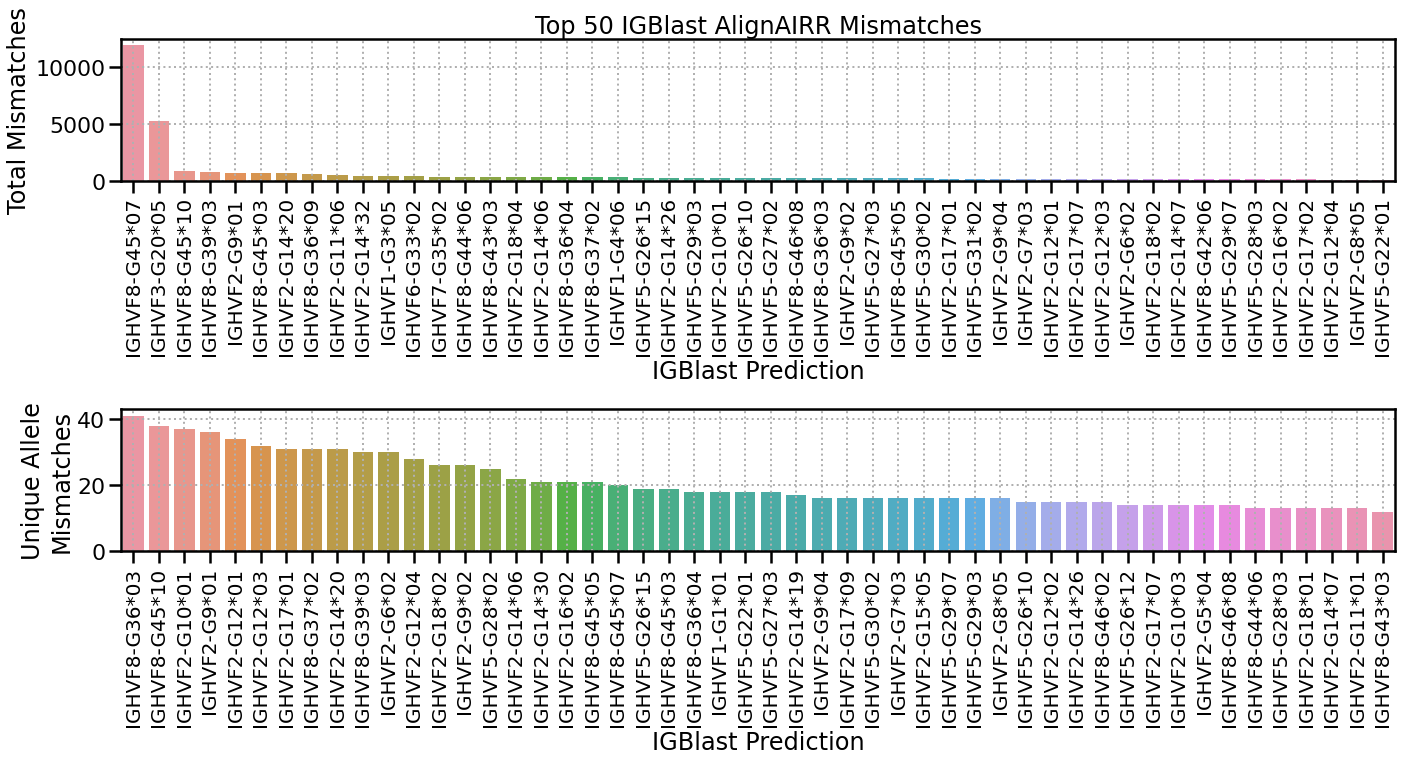

In [304]:
plt.subplot(2,1,1)
plt.title('Top 50 IGBlast AlignAIRR Mismatches')
alignairr_conf_p = confusion_df.sum(axis=1).sort_values(ascending=False).iloc[:50]
sns.barplot(x=alignairr_conf_p.index,y=alignairr_conf_p.values)
plt.xlabel('IGBlast Prediction')
plt.ylabel('Total Mismatches')
plt.xticks(rotation=90,fontsize=20)
plt.grid(lw=2,ls=':')
plt.subplot(2,1,2)
alignairr_conf_u = confusion_df.apply(lambda x: sum(x!=0),axis=1).sort_values(ascending=False).iloc[:50]
sns.barplot(x=alignairr_conf_u.index,y=alignairr_conf_u.values)
plt.ylabel('Unique Allele\nMismatches')
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('IGBlast Prediction')
plt.grid(lw=2,ls=':')

plt.tight_layout()
plt.show()


### Multi Call

In [248]:
multi_call_ = mismatch_df.apply(lambda x: len(x['v_call']) >1 or  len(x['v_call_ar']) > 1 ,axis=1)
multi_call = mismatch_df[multi_call_].copy()
multi_call['ar_v_length'] = multi_call['v_sequence_end_ar']-multi_call['v_sequence_start_ar']
multi_call['igb_v_length'] = multi_call['v_sequence_end']-multi_call['v_sequence_start']

multi_call['igb_v'] = multi_call.apply(lambda x: x['sequence'][x['v_sequence_start']:x['v_sequence_end']],axis=1)
multi_call['ar_v']= multi_call.apply(lambda x: x['sequence'][x['v_sequence_start_ar']:x['v_sequence_end_ar']],axis=1)

In [249]:
multi_call

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites,ar_v_length,igb_v_length,igb_v,ar_v
154,GCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,151,244,"[IGHVF8-G45*04, IGHVF8-G45*07]","[IGHVF8-G45*08, IGHVF8-G45*06]",17,270,"[0.11764706, 0.11302211]",253,93,CACCATATCCGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTG...,GATCTCATGTGCAAGAAAATGAAGCACCTGTGGTTCTTCCTCCTGC...
565,GAGAGCACAGCTCCTCACCATGGACTGTACCTGGGGGATCCTCTTC...,77,369,"[IGHVF5-G29*03, IGHVF5-G29*05, IGHVF5-G29*06]",[IGHVF5-G25*03],76,374,[0.224],298,292,AGGTTCAGCTGTTGCAGCCTGGGGCTGAGGTGAAGAAGCCTGCGTC...,CAGGTTCAGCTGTTGCAGCCTGGGGCTGAGGTGAAGAAGCCTGCGT...
1054,GACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACACC...,124,346,"[IGHVF8-G44*03, IGHVF8-G44*04, IGHVF8-G44*06]",[IGHVF8-G44*02],53,353,[1.0],300,222,TGGTGAAGCCTTCACAGTGGTGGTTACTACTGGAGCTGGATCCGCC...,CTTCCTCCTGCTGGTGGCAGCTCCCAGATGGGTCCTGTCCCAGGTG...
1152,GCTCCTTCACCACCCAGCTGGGATCTCAGGGCTTCCTTTTCTGTCC...,173,246,"[IGHVF3-G20*01, IGHVF3-G20*02, IGHVF3-G20*05]",[IGHVF3-G19*02],9,279,[0.06779661],270,73,CCATCAGCACTGCCTACCTGCAGTGGAGCAGCCTGAAGGCCTCGGA...,CCACCCAGCTGGGATCTCAGGGCTTCCTTTTCTGTCCTCCTCCAGG...
1464,GGCAGACGAGTGCTTAGTGGATCTACGGGCGCATAANTCTTTAACT...,124,222,"[IGHVF2-G15*07, IGHVF2-G15*09]",[IGHVF1-G3*02],7,278,[0.6231884],271,98,CAGTACAAAGAAGATTAACAGTCCTCAGAGACACTGTTCAGAAGAT...,GAGTGCTTAGTGGATCTACGGGCGCATAANTCTTTAACTCTTTTTT...
...,...,...,...,...,...,...,...,...,...,...,...,...
4949748,GGGGAGAGGAGCCCCAGCCTTGGGATTCCCAAGTGTTTTCATTCAG...,133,427,[IGHVF1-G4*06],"[IGHVF1-G4*07, IGHVF2-G17*01]",133,432,"[0.25274727, 0.18867925]",299,294,AGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTAAAGCCTGGGGG...,AGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTAAAGCCTGGGGG...
4949956,GACTCTGCTGAAGAAAACCAGCCCTGCAGCTCTGGGAGAGGAGCCC...,165,396,"[IGHVF2-G17*01, IGHVF2-G17*01_G319C, IGHVF2-G1...","[IGHVF5-G29*06, IGHVF2-G14*26, IGHVF2-G7*01, I...",65,369,"[0.052083332, 0.023880597, 0.020304568, 0.0109...",304,231,AGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGGG...,TGTTTCTGCTTGCTGATCAGGACTGCACACAGAGAACTCACCATGG...
4950096,GAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAGG...,125,416,[IGHVF2-G17*01_G319C],"[IGHVF2-G16*02, IGHVF2-G11*01, IGHVF2-G11*07, ...",124,422,"[0.026915114, 0.022702703, 0.017559262, 0.0154...",298,291,AGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTNCAGCCTGGGGG...,GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTNCAGCCTGGGG...
4950307,GGGGAGAGGAGCCCAGCACTGGGATTCCGAGGTGTTTCCATTCGGT...,132,422,"[IGHVF2-G17*07, IGHVF2-G17*08]",[IGHVF2-G17*06],132,431,[0.43037975],299,290,AGGTGCAGTTGGTGGAGNCTGGAGGAGGCTTGATCCAGCCGGGGGG...,AGGTGCAGTTGGTGGAGNCTGGAGGAGGCTTGATCCAGCCGGGGGG...


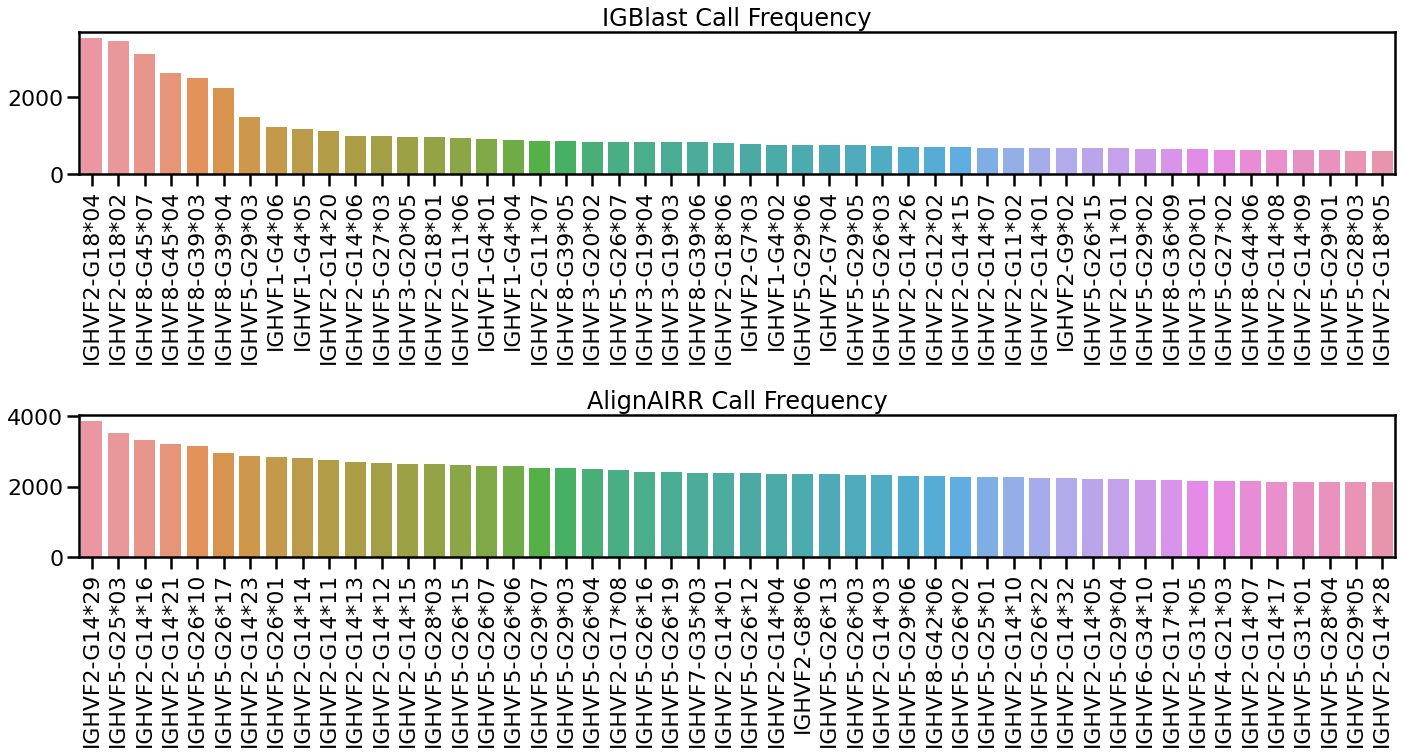

In [250]:
plt.subplot(2,1,1)
plt.title('IGBlast Call Frequency')
igbvc = pd.Series([i for j in multi_call.v_call for i in j]).value_counts().iloc[:50]
sns.barplot(x=igbvc.index,y=igbvc)
plt.xticks(rotation=90)
plt.subplot(2,1,2)
igbvc = pd.Series([i for j in multi_call.v_call_ar for i in j]).value_counts().iloc[:50]
plt.title('AlignAIRR Call Frequency')
sns.barplot(x=igbvc.index,y=igbvc)
plt.xticks(rotation=90)

plt.tight_layout()

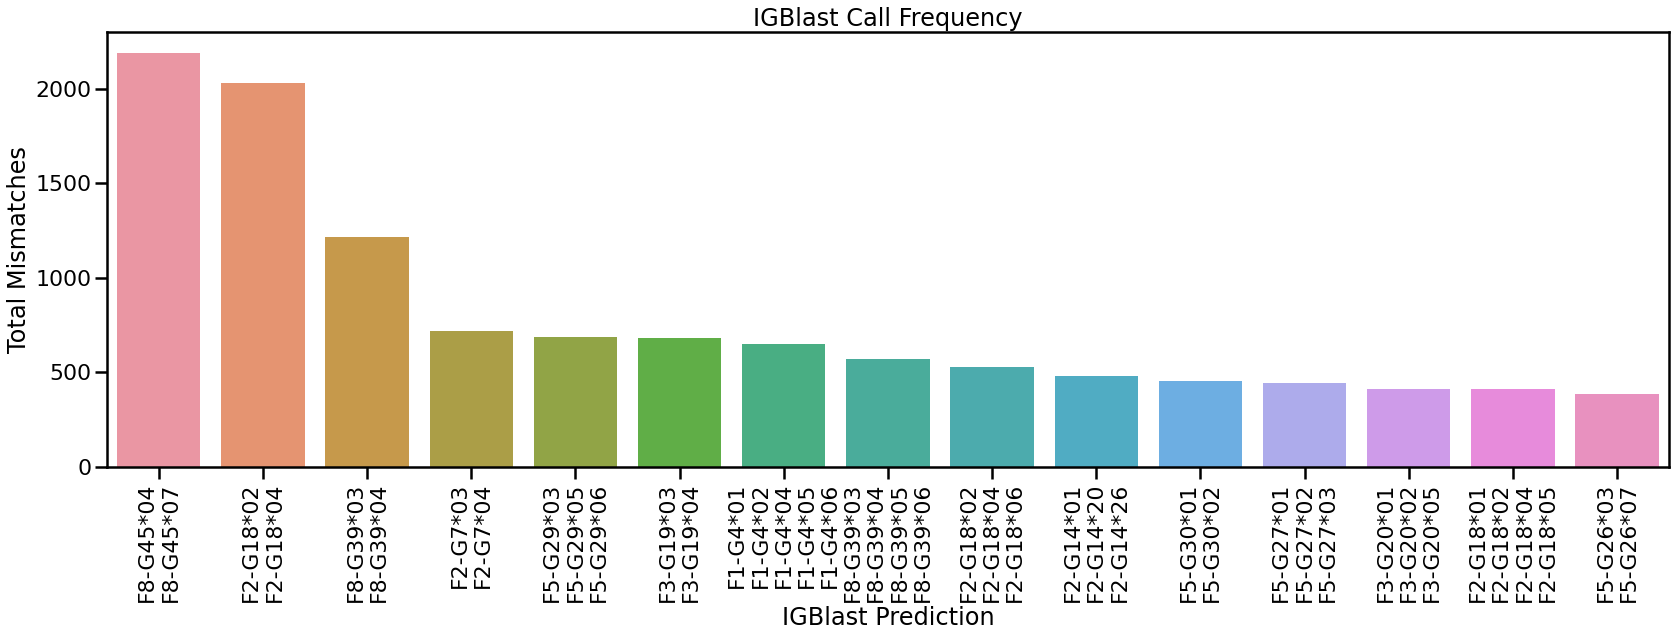

In [251]:
plt.figure(figsize=(28,8))
plt.title('IGBlast Call Frequency')
igbvc = multi_call.v_call.apply(lambda x:'\n'.join(x).replace('IGHV','')).value_counts().iloc[:15]
sns.barplot(x=igbvc.index,y=igbvc)
plt.xticks(rotation=90)
plt.xlabel('IGBlast Prediction')
plt.ylabel('Total Mismatches')
plt.show()

In [253]:
igb_dict = defaultdict(list)
for c in multi_call.v_call:
    for i in c:
        igb_dict[i].append(len(c)) 
igb_dict = dict(igb_dict)
ar_dict = defaultdict(list)
for c in multi_call.v_call_ar:
    for i in c:
        ar_dict[i].append(len(c)) 
ar_dict = dict(ar_dict)

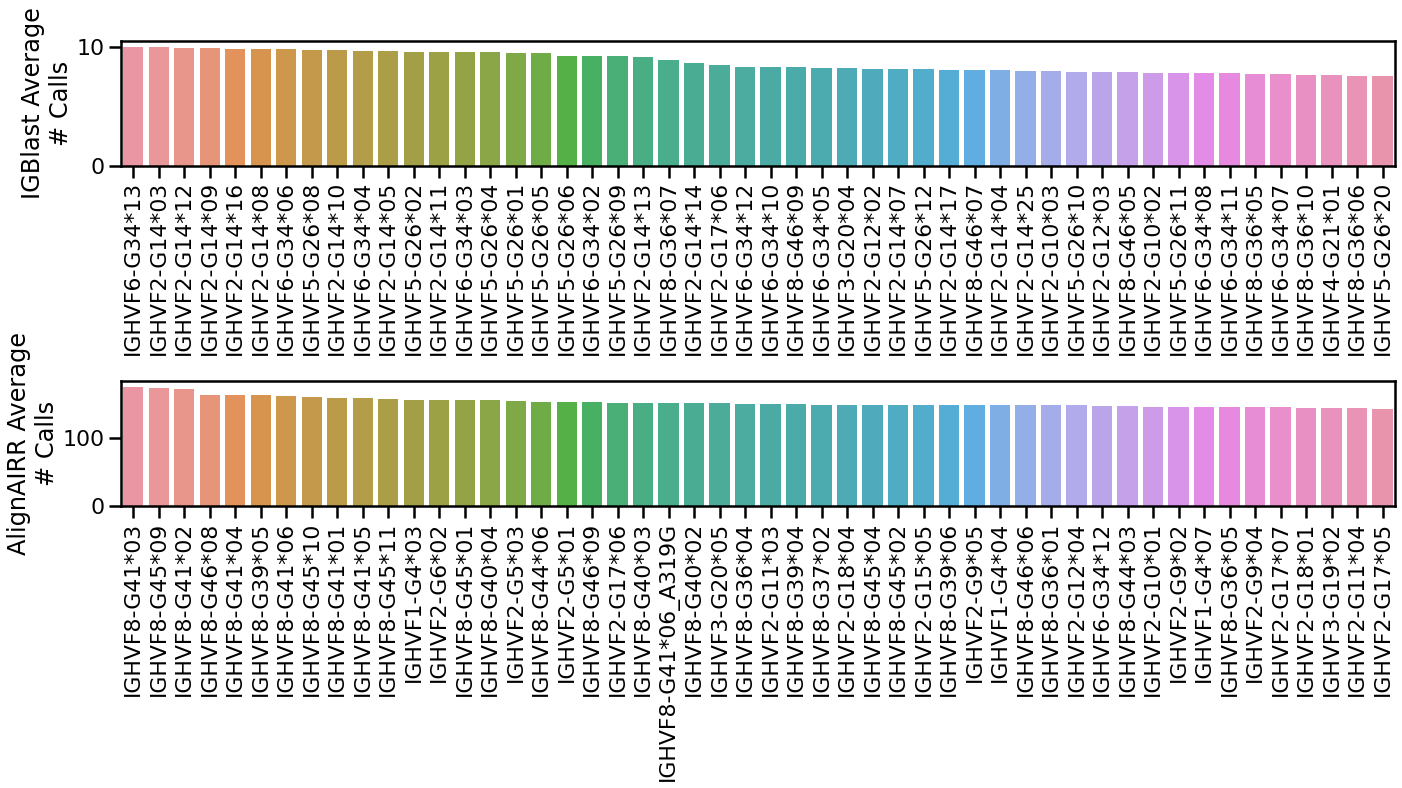

In [254]:
plt.subplot(2,1,1)
temp = pd.Series(igb_dict).apply(lambda x:np.mean(x)).sort_values(ascending=False).iloc[:50]
sns.barplot(x=temp.index,y=temp)
plt.xticks(rotation=90)
plt.ylabel('IGBlast Average\n# Calls')
plt.subplot(2,1,2)
temp = pd.Series(ar_dict).apply(lambda x:np.mean(x)).sort_values(ascending=False).iloc[:50]
sns.barplot(x=temp.index,y=temp)
plt.xticks(rotation=90)
plt.ylabel('AlignAIRR Average\n# Calls')
plt.tight_layout()
plt.show()

In [255]:
multi_call

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites,ar_v_length,igb_v_length,igb_v,ar_v
154,GCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,151,244,"[IGHVF8-G45*04, IGHVF8-G45*07]","[IGHVF8-G45*08, IGHVF8-G45*06]",17,270,"[0.11764706, 0.11302211]",253,93,CACCATATCCGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTG...,GATCTCATGTGCAAGAAAATGAAGCACCTGTGGTTCTTCCTCCTGC...
565,GAGAGCACAGCTCCTCACCATGGACTGTACCTGGGGGATCCTCTTC...,77,369,"[IGHVF5-G29*03, IGHVF5-G29*05, IGHVF5-G29*06]",[IGHVF5-G25*03],76,374,[0.224],298,292,AGGTTCAGCTGTTGCAGCCTGGGGCTGAGGTGAAGAAGCCTGCGTC...,CAGGTTCAGCTGTTGCAGCCTGGGGCTGAGGTGAAGAAGCCTGCGT...
1054,GACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACACC...,124,346,"[IGHVF8-G44*03, IGHVF8-G44*04, IGHVF8-G44*06]",[IGHVF8-G44*02],53,353,[1.0],300,222,TGGTGAAGCCTTCACAGTGGTGGTTACTACTGGAGCTGGATCCGCC...,CTTCCTCCTGCTGGTGGCAGCTCCCAGATGGGTCCTGTCCCAGGTG...
1152,GCTCCTTCACCACCCAGCTGGGATCTCAGGGCTTCCTTTTCTGTCC...,173,246,"[IGHVF3-G20*01, IGHVF3-G20*02, IGHVF3-G20*05]",[IGHVF3-G19*02],9,279,[0.06779661],270,73,CCATCAGCACTGCCTACCTGCAGTGGAGCAGCCTGAAGGCCTCGGA...,CCACCCAGCTGGGATCTCAGGGCTTCCTTTTCTGTCCTCCTCCAGG...
1464,GGCAGACGAGTGCTTAGTGGATCTACGGGCGCATAANTCTTTAACT...,124,222,"[IGHVF2-G15*07, IGHVF2-G15*09]",[IGHVF1-G3*02],7,278,[0.6231884],271,98,CAGTACAAAGAAGATTAACAGTCCTCAGAGACACTGTTCAGAAGAT...,GAGTGCTTAGTGGATCTACGGGCGCATAANTCTTTAACTCTTTTTT...
...,...,...,...,...,...,...,...,...,...,...,...,...
4949748,GGGGAGAGGAGCCCCAGCCTTGGGATTCCCAAGTGTTTTCATTCAG...,133,427,[IGHVF1-G4*06],"[IGHVF1-G4*07, IGHVF2-G17*01]",133,432,"[0.25274727, 0.18867925]",299,294,AGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTAAAGCCTGGGGG...,AGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTAAAGCCTGGGGG...
4949956,GACTCTGCTGAAGAAAACCAGCCCTGCAGCTCTGGGAGAGGAGCCC...,165,396,"[IGHVF2-G17*01, IGHVF2-G17*01_G319C, IGHVF2-G1...","[IGHVF5-G29*06, IGHVF2-G14*26, IGHVF2-G7*01, I...",65,369,"[0.052083332, 0.023880597, 0.020304568, 0.0109...",304,231,AGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGGG...,TGTTTCTGCTTGCTGATCAGGACTGCACACAGAGAACTCACCATGG...
4950096,GAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAGG...,125,416,[IGHVF2-G17*01_G319C],"[IGHVF2-G16*02, IGHVF2-G11*01, IGHVF2-G11*07, ...",124,422,"[0.026915114, 0.022702703, 0.017559262, 0.0154...",298,291,AGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTNCAGCCTGGGGG...,GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTNCAGCCTGGGG...
4950307,GGGGAGAGGAGCCCAGCACTGGGATTCCGAGGTGTTTCCATTCGGT...,132,422,"[IGHVF2-G17*07, IGHVF2-G17*08]",[IGHVF2-G17*06],132,431,[0.43037975],299,290,AGGTGCAGTTGGTGGAGNCTGGAGGAGGCTTGATCCAGCCGGGGGG...,AGGTGCAGTTGGTGGAGNCTGGAGGAGGCTTGATCCAGCCGGGGGG...


In [1076]:
from minineedle import needle, smith, core
def get_a_score(seq):
    scores = []
    for i in tqdm(V_Alleles):
        alignment = smith.SmithWaterman(seq, V_Alleles[i])
        alignment.align()
        scores.append(alignment.get_score())
    return scores



In [1077]:
sample = multi_call.iloc[5]
A_score_ar = get_a_score(sample.ar_v)
A_score_igb = get_a_score(sample.igb_v)

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

In [1080]:
Adf = pd.concat([
    pd.Series(A_score_ar,index=list(V_Alleles),name='AR'),
    pd.Series(A_score_igb,index=list(V_Alleles),name='IGB')
],axis=1)
Adf.IGB.idxmax()


'IGHVF2-G11*03'

In [1081]:
Adf.AR.idxmax()

'IGHVF2-G11*03'

In [1082]:
sample

sequence               GGCAGACGAGTGCTTAGTGGATCTACGGGCGCATAANTCTTTAACT...
v_sequence_start                                                     124
v_sequence_end                                                       222
v_call                                    [IGHVF2-G15*07, IGHVF2-G15*09]
v_call_ar                                                [IGHVF2-G15*01]
v_sequence_start_ar                                                    0
v_sequence_end_ar                                                    250
ar_allele_proba                                               [0.669054]
ar_gene_proba                                                [0.2783048]
ar_family_proba                                              [0.9973814]
agg_score                                                       0.185713
ar_v_length                                                          250
igb_v_length                                                          98
igb_v                  CAGTACAAAGAAGATTAACAGTCCTCAG

In [1093]:
sample = multi_call.iloc[5]
sample[['v_call','v_call_ar']]

v_call       [IGHVF2-G15*07, IGHVF2-G15*09]
v_call_ar                   [IGHVF2-G15*01]
Name: 1464, dtype: object

In [1098]:
R = pd.DataFrame({'AR':[distance(sample.ar_v,V_Alleles[i]) for i in V_Alleles],
             'IGB':[distance(sample.igb_v,V_Alleles[i]) for i in V_Alleles]},index=list(V_Alleles))
R.sort_values(by='AR')

,AR,IGB
IGHVF2-G15*08,142,202
IGHVF2-G15*06,143,203
IGHVF2-G15*09,143,203
IGHVF2-G15*05,143,202
IGHVF2-G15*07,143,202
...,...,...
IGHVF6-G33*06,160,206
IGHVF6-G33*03,160,206
IGHVF6-G33*02,160,206
IGHVF6-G33*04,160,207


# Individual Mismatch Analysis

In [305]:
import pickle
from Levenshtein import distance,hamming
with open('E:/Immunobiology/AlignAIRR/V_Allele_F_dict.pkl','rb') as h:
    V_Alleles = pickle.load(h)

In [365]:
allele = confusion_df.sum(axis=1).sort_values().index[-2] # the AR prediction with most confusion
allele_2 = confusion_df.loc[allele,:].sort_values().index[-1]
print(allele,allele_2)

IGHVF3-G20*05 IGHVF3-G20*06


In [366]:
confusion_df.loc[allele,:].sort_values()

IGHVF8-G40*01       0
IGHVF1-G2*01        0
IGHVF2-G14*24       0
IGHVF5-G29*04       0
IGHVF2-G12*02       0
                 ... 
IGHVF3-G19*02       9
IGHVF3-G20*03      17
IGHVF3-G20*02      59
IGHVF3-G20*01      90
IGHVF3-G20*06    5040
Name: IGHVF3-G20*05, Length: 279, dtype: int64

In [367]:
confusion_df.loc[allele,:].sum()

5224

In [368]:
print(f'Length Difference Between Alleles: {abs(len(V_Alleles[allele])-len(V_Alleles[allele_2]))}')
if abs(len(V_Alleles[allele])-len(V_Alleles[allele_2])) != 0:
    print(f'Levenstain Distance: {distance(V_Alleles[allele],V_Alleles[allele_2])}')
else:
    print(f'Hamming Distance: {hamming(V_Alleles[allele],V_Alleles[allele_2])}')
    
print('Poisition ')

Length Difference Between Alleles: 2
Levenstain Distance: 3
Poisition 


In [369]:
a1 = list(vquest[allele]['sequence'])
a2 = list(vquest[allele_2]['sequence'])
if len(a1)>len(a2):
    a2+=['.']*(len(a1)-len(a2))
else:
    a1+=['.']*(len(a2)-len(a1))
    
mdf = pd.DataFrame({allele:a1,allele_2:a2})
mdf[mdf.iloc[:,0] != mdf.iloc[:,1]]

,IGHVF3-G20*05,IGHVF3-G20*06
44,C,G
318,C,.
319,A,.


In [363]:
vquest[allele]

{'sequence': 'CAGCTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGC......AGTAGTAGTTACTACTGGGGCTGGATCCGCCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATTATAGT.........GGGAGCACCTACTACAACCCGTCCCTCAAG...AGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCGGACACGGCCGTGTATTACTGTGCGAGAGA',
 'imgt_allele': 'IGHV4-39*07',
 'F': 'F',
 'pos': '1..299',
 'ungapped_length': 299,
 'length_summary': '299+21=320'}

In [457]:
allele

'IGHVF3-G20*05'

In [364]:
vquest[allele_2]

{'sequence': 'CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCACTGTCTCTGGTTACTCCATCAGC.........AGTGGTTACTACTGGGGCTGGATCCGGCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATCATAGT.........GGGAGCACCTACTACAACCCGTCCCTCAAG...AGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGAGAGA',
 'imgt_allele': 'IGHV4-38-2*02',
 'F': 'F',
 'pos': '41583..41878',
 'ungapped_length': 296,
 'length_summary': '296+24=320'}

In [456]:
allele_2

'IGHVF3-G20*06'

In [370]:
tseqs = mismatch_df[(mismatch_df.v_call.apply(lambda x: x ==  [allele] ) & (mismatch_df.v_call_ar.apply(lambda x: x ==  [allele_2] )))]

In [386]:
igb_seqs = tseqs.apply(lambda x:x['sequence'][x['v_sequence_start']:x['v_sequence_end']] ,axis=1)
ar_seqs = tseqs.apply(lambda x:x['sequence'][x['v_sequence_start_ar']:x['v_sequence_end_ar']] ,axis=1)
ar_seqs= ar_seqs[ar_seqs.str.len() > 0]

In [432]:
aligned = allign_sequences([vquest[allele]['sequence']]+igb_seqs.to_list())

In [433]:
adf = pd.DataFrame(data=[list(str(i.seq)) for i in aligned])


In [434]:
''.join(adf.iloc[0,:])

'GAGGTGCAGCTGGTGCAGTCTGGAGCA---GAGGTGAAAA--AGCCCGGGGAGTCTCTGAAGATCTCCTGTAAGGGTTCTGGATACAGCTTT------------ACCAGCTACTGGATCGGCTGGGTGCGCCAGATGCC-CGGGAAAGGCCTGGAGTGGAT-GGGGATCATCTATCCTGGT------GACTCTGATACCAGATACAGCCCGTCCTTCCAA---GGCCAGGTCACCATCTCAGCCGACAAGTCCA-TCAGCACCGCCTACCTGCAGTGGAGCAGCCTGAA--GGCCTCGGA-CACCGCCATGTATTACTGTGCGAGACA-'

In [435]:
allele

'IGHVF3-G20*05'

In [441]:
ptr = vquest[allele]['sequence'][44:77]
ptr

'CGGGGAGTCTCTGAAGATCTCCTGTAAGGGTTC'

In [442]:
import re
re.search(ptr,''.join(adf.iloc[0,:]))

<re.Match object; span=(46, 79), match='CGGGGAGTCTCTGAAGATCTCCTGTAAGGGTTC'>

<AxesSubplot:title={'center':'IGBlast V-cut, Aliinged, Position 44'}, ylabel='46'>

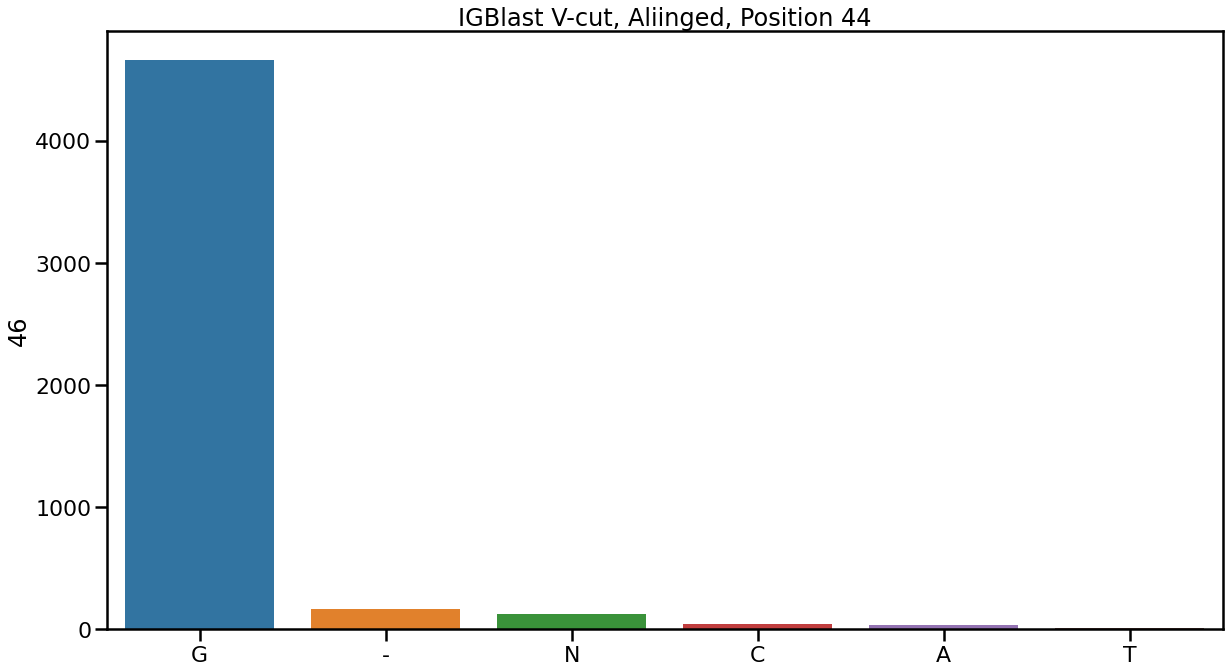

In [444]:
plt.title('IGBlast V-cut, Aliinged, Position 44')
dst = adf.iloc[:,46].value_counts()
sns.barplot(x=dst.index,y=dst)

In [459]:
igb_seqs.str.len().value_counts()

295    4415
294     217
293      92
296      75
292      24
       ... 
263       1
285       1
194       1
284       1
287       1
Length: 76, dtype: int64

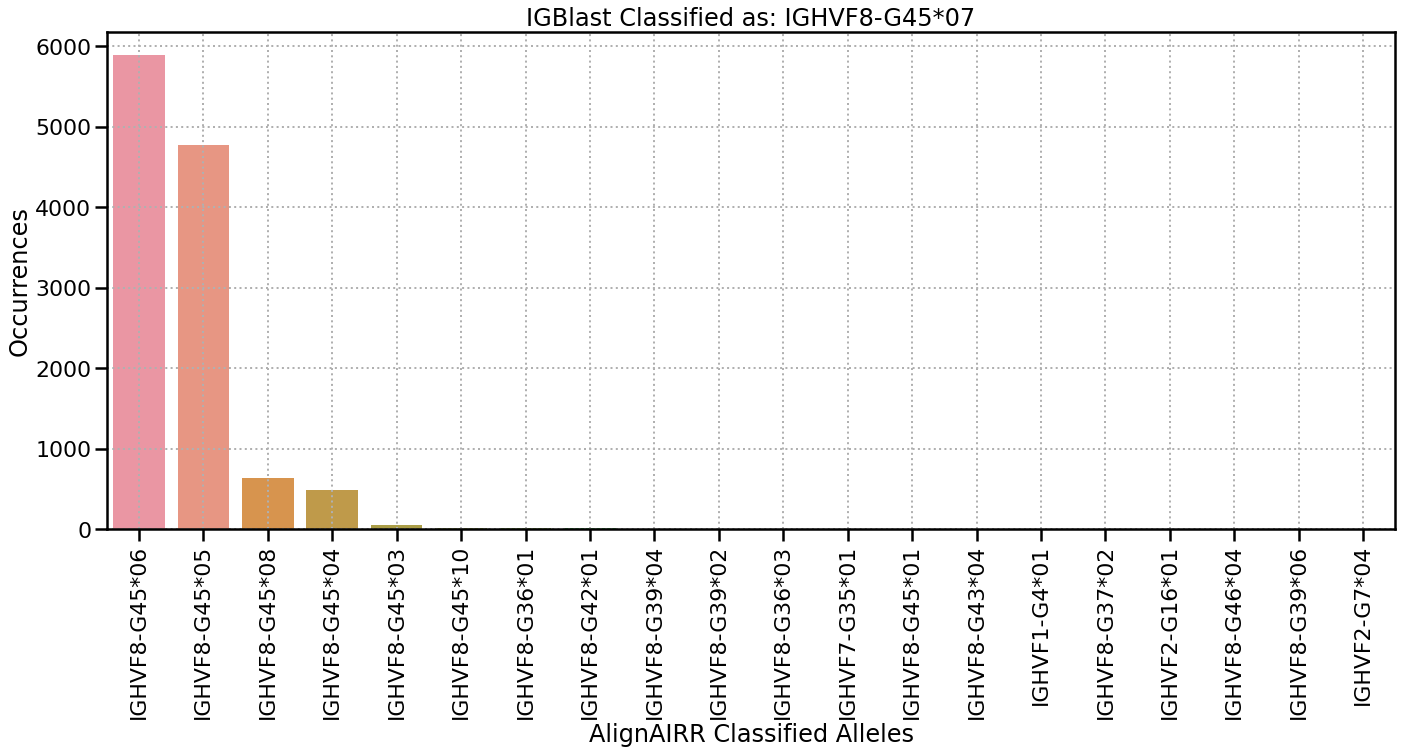

In [296]:
alignairsort_conf_u = confusion_df.apply(lambda x: sum(x!=0),axis=1).sort_values(ascending=False)
temp = confusion_df[alignairr_conf_u.index]

sample = temp.loc[allele,:]
sample = sample[sample>0].sort_values(ascending=False).iloc[:25]
plt.title('IGBlast Classified as: '+allele)
sns.barplot(x=sample.index,y=sample.values)
plt.xticks(rotation = 90)
plt.grid(lw=2,ls=':')
plt.ylabel('Occurrences')
plt.xlabel('AlignAIRR Classified Alleles')
plt.tight_layout()

Text(0.5, 0, 'V Sequence Length')

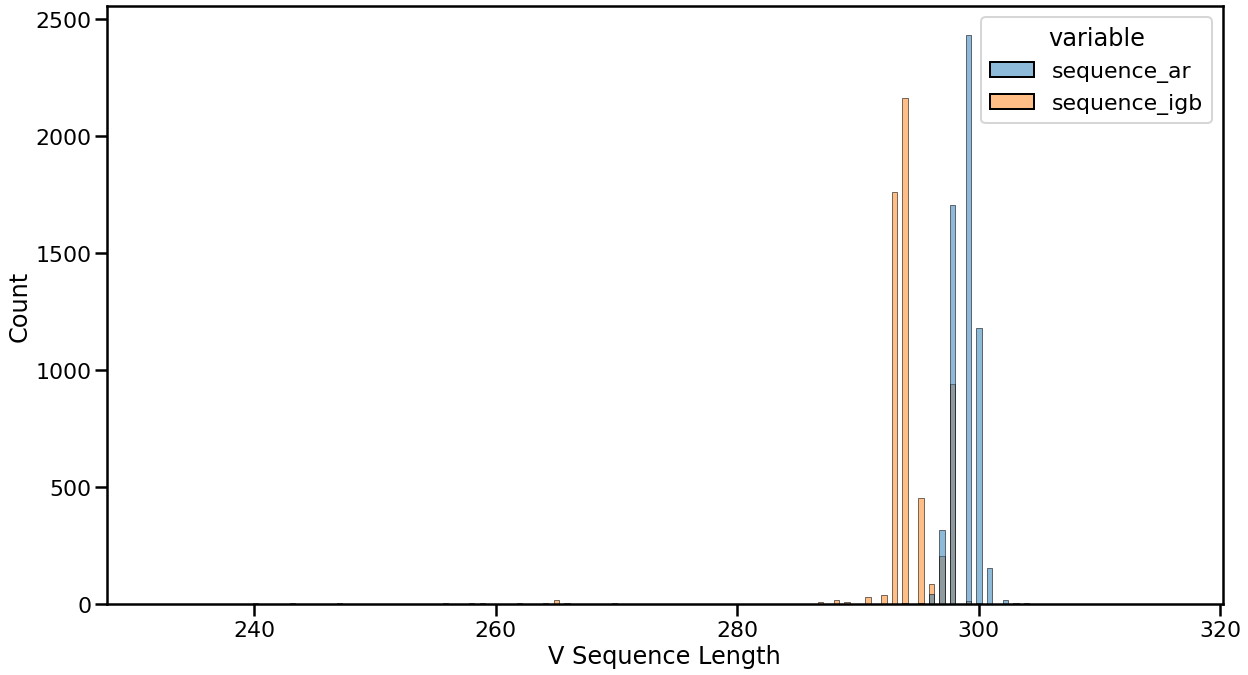

In [299]:
single_call_mss = single_call.copy()
S = single_call_mss[(single_call_mss.v_call_ar == allele_2) &(single_call_mss.v_call == allele) ].copy()
S.loc[:,'sequence_igb'] = S.apply(lambda x: x['sequence'][(x['v_sequence_start']-1):(x['v_sequence_end']-1)],axis=1)
S.loc[:,'sequence_ar'] = S.apply(lambda x: x['sequence'][(x['v_sequence_start_ar']):(x['v_sequence_end_ar'])],axis=1)
S = S[['sequence_ar','sequence_igb','v_call','v_call_ar']]
S = S[S.sequence_ar.str.len() > 1]

sns.histplot(data= S[['sequence_ar','sequence_igb']].agg(lambda x: x.str.len(),axis=0).melt(),x='value',hue='variable')
plt.xlabel('V Sequence Length')

In [323]:
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os
from scipy.stats import entropy

def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)


def igb_conf_anaysis(allele,allele_2,alignby = 'ar'):
    alignairr_conf_u = confusion_df.apply(lambda x: sum(x!=0),axis=1).sort_values(ascending=False)
    temp = confusion_df[alignairr_conf_u.index]

    sample = temp.loc[allele,:]
    sample = sample[sample>0].sort_values(ascending=False).iloc[:25]
   
    single_call_mss = single_call.copy()
    S = single_call_mss[(single_call_mss.v_call_ar == allele_2) &(single_call_mss.v_call == allele) ].copy()
    S.loc[:,'sequence_igb'] = S.apply(lambda x: x['sequence'][(x['v_sequence_start']-1):(x['v_sequence_end']-1)],axis=1)
    S.loc[:,'sequence_ar'] = S.apply(lambda x: x['sequence'][(x['v_sequence_start_ar']):(x['v_sequence_end_ar'])],axis=1)
    S = S[['sequence_ar','sequence_igb','v_call','v_call_ar']]
    S = S[S.sequence_ar.str.len() > 1]

    # Write sequences to a FASTA file
    if alignby == 'ar':
        sequences = [
            SeqRecord(Seq(seq), id=f"seq{en}")
            for en,seq in enumerate(S.sequence_ar)
        ]
        SeqIO.write(sequences, r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta", "fasta")
    else:
        sequences = [
            SeqRecord(Seq(seq), id=f"seq{en}")
            for en,seq in enumerate(S.sequence_igb)
        ]
        SeqIO.write(sequences, r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta", "fasta")

    # Define Clustal Omega command
    clustalomega_cline = ClustalOmegaCommandline(infile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta",
                                                 outfile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", verbose=True, auto=True,force=True)
    clustalomega_cline.program_name = r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\clustalo.exe"
    stdout, stderr = clustalomega_cline()

    alignment = AlignIO.read(r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", "fasta")
    S['alligned']  = pd.Series(map(lambda x: str(x.seq),alignment)).values
    adf = pd.DataFrame(data=[list(str(i.seq)) for i in alignment])
    unique_n_in_pos = adf.apply(lambda x: len(np.unique(x)), axis=0)
    maxlen = len(adf.columns)+1
    

    fdf = adf.apply(lambda x: x.value_counts(),axis=0).T.fillna(0)

    ax = fdf.plot(kind='bar',stacked=True,figsize=(35,10),color = ["#FF0000", "#008000", "#0000FF", "#FFFF00", "#800080", "#00FFFF"])
    plt.xticks(np.arange(0,maxlen,5),rotation=90)
    plt.title(f"{len(adf)} Aligned Sequences Using Clustal Omega\n"+r"$\bf{AlignAIRR:}$"+f"{allele}\n"+r"$\bf{IGBlast:}$"+f" {allele_2}")
    ax.set_facecolor('white')
    plt.savefig(f"C:/Users/Tomas/Downloads/Alignemnt_simlified_logochart_{allele.replace('*','-')}_ALIGNAIRR_{allele_2.replace('*','-')}_IGB.png",dpi=200,facecolor='white')
    
    fdfn = fdf.apply(lambda x: x/x.sum(),axis=1)
    
   

    plt.figure(figsize=(35,10))
    ent = fdfn.apply(lambda x: entropy(x[x!='-']),axis=1)
    plt.title(f"{len(adf)} Aligned Sequences Using Clustal Omega\n"+r"$\bf{AlignAIRR:}$"+f"{allele}\n"+r"$\bf{IGBlast:}$"+f" {allele_2}")
    sns.barplot(x=ent.index,y=ent,palette=colors_from_values(ent,'icefire'))
    plt.xticks(np.arange(0,maxlen,5),rotation=90)
    plt.xlabel('Position')
    plt.ylabel('Entropy')
    plt.savefig(f"C:/Users/Tomas/Downloads/Aligment_Entropy_{allele.replace('*','-')}_ALIGNAIRR_{allele_2.replace('*','-')}_IGB.png",dpi=200,facecolor='white')        
    #SeqIO.write(sequences, r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta", "fasta")



In [324]:
single_call_mss = single_call.copy()
S = single_call_mss[(single_call_mss.v_call_ar == allele_2) &(single_call_mss.v_call == allele) ].copy()
S.loc[:,'sequence_igb'] = S.apply(lambda x: x['sequence'][(x['v_sequence_start']-1):(x['v_sequence_end']-1)],axis=1)
S.loc[:,'sequence_ar'] = S.apply(lambda x: x['sequence'][(x['v_sequence_start_ar']):(x['v_sequence_end_ar'])],axis=1)
S = S[['sequence_ar','sequence_igb','v_call','v_call_ar']]
S = S[S.sequence_ar.str.len() > 1]


In [325]:
S

,sequence_ar,sequence_igb,v_call,v_call_ar
1835,AGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4109,CTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
6315,GCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
7312,CTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
8015,TGCAGCTGCAGGAGTCGGGCCCAGGACTGGTNAAGCCTTCGGAGAC...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTNAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
...,...,...,...,...
4934297,CTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4934645,GCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4934646,GCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4934718,TCCCAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTT...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06


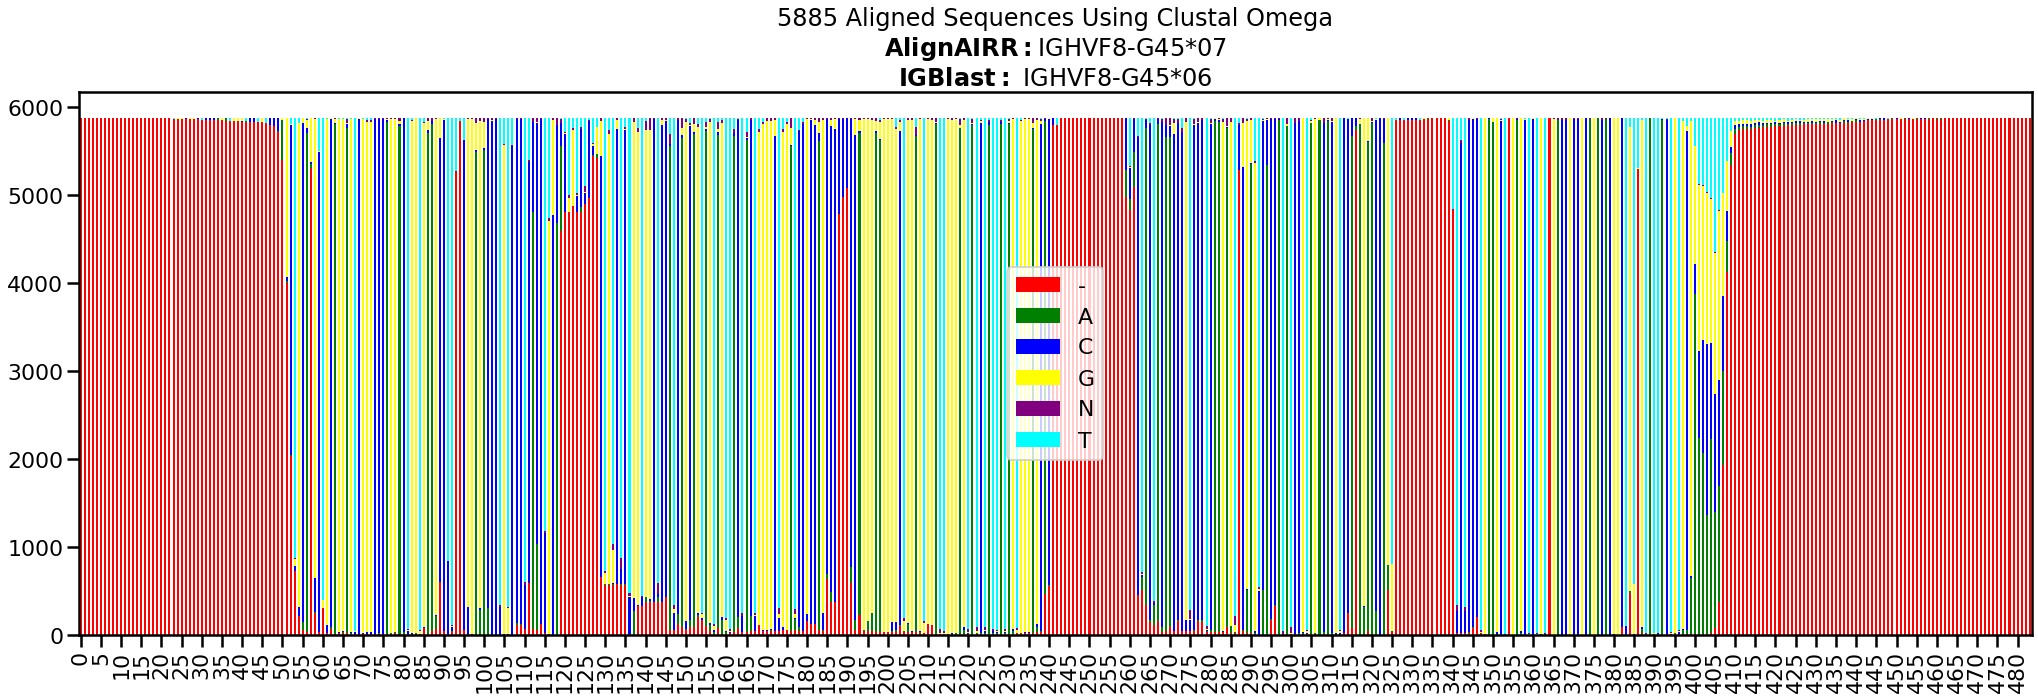

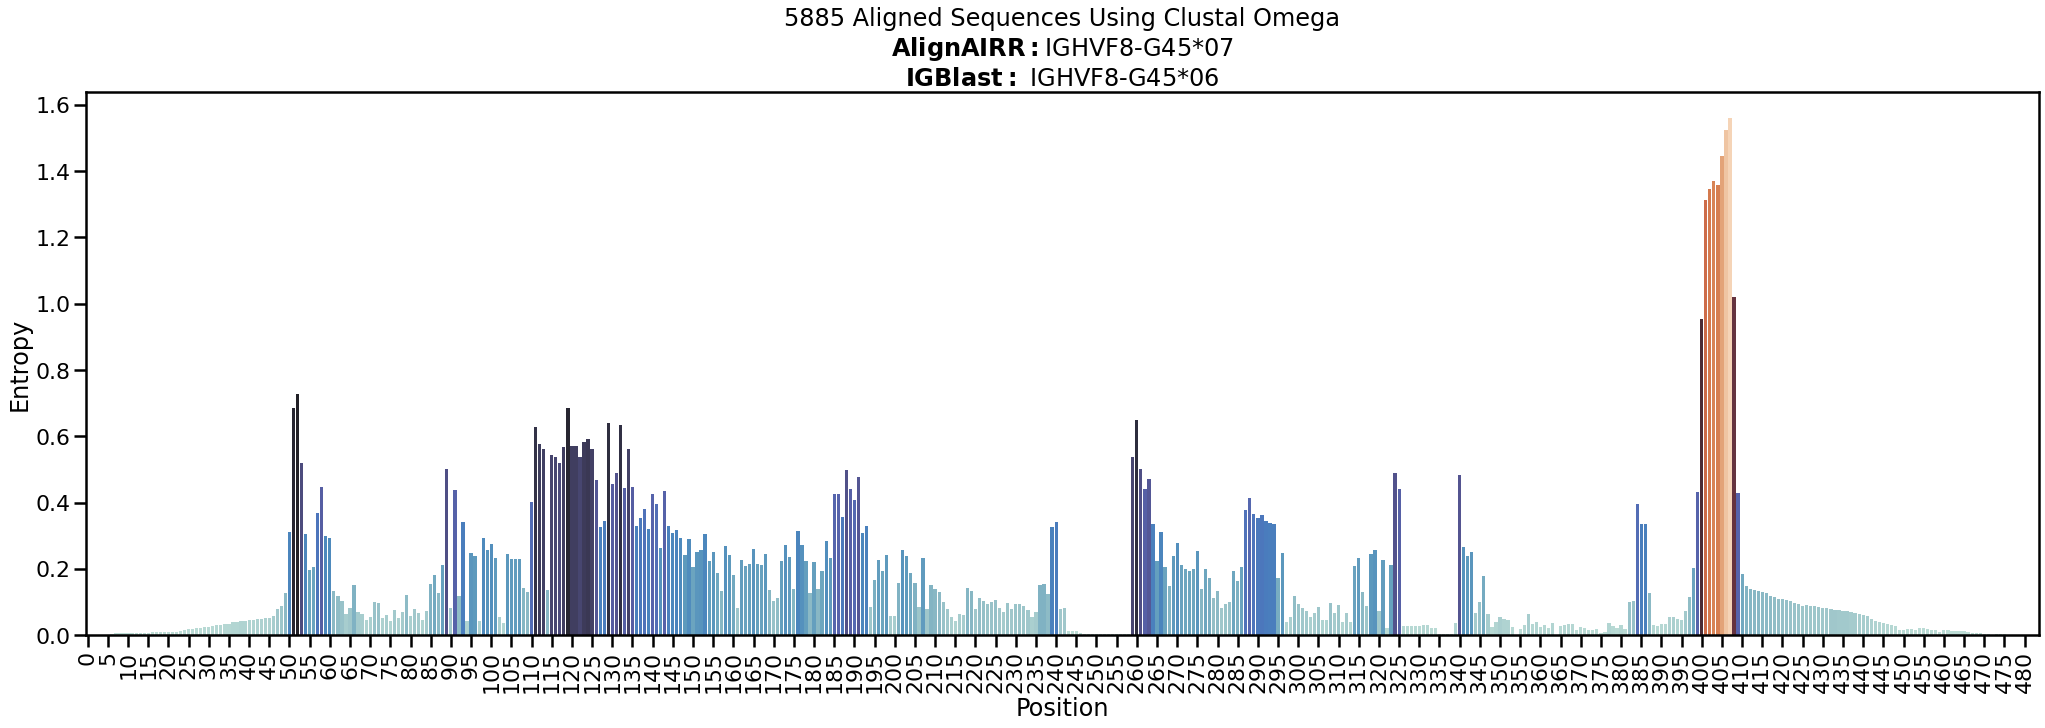

In [328]:
igb_conf_anaysis(allele,allele_2,alignby='ar')

In [353]:
notaligned = pd.DataFrame(S['sequence_ar'].apply(lambda x: list(x)).to_list()).fillna('.')
for col in notaligned.columns:
    notaligned.loc[:,col] = notaligned.loc[:,col].map({"-":0,'A':1,'T':2,'G':3,'C':4,'.':5})


<AxesSubplot:>

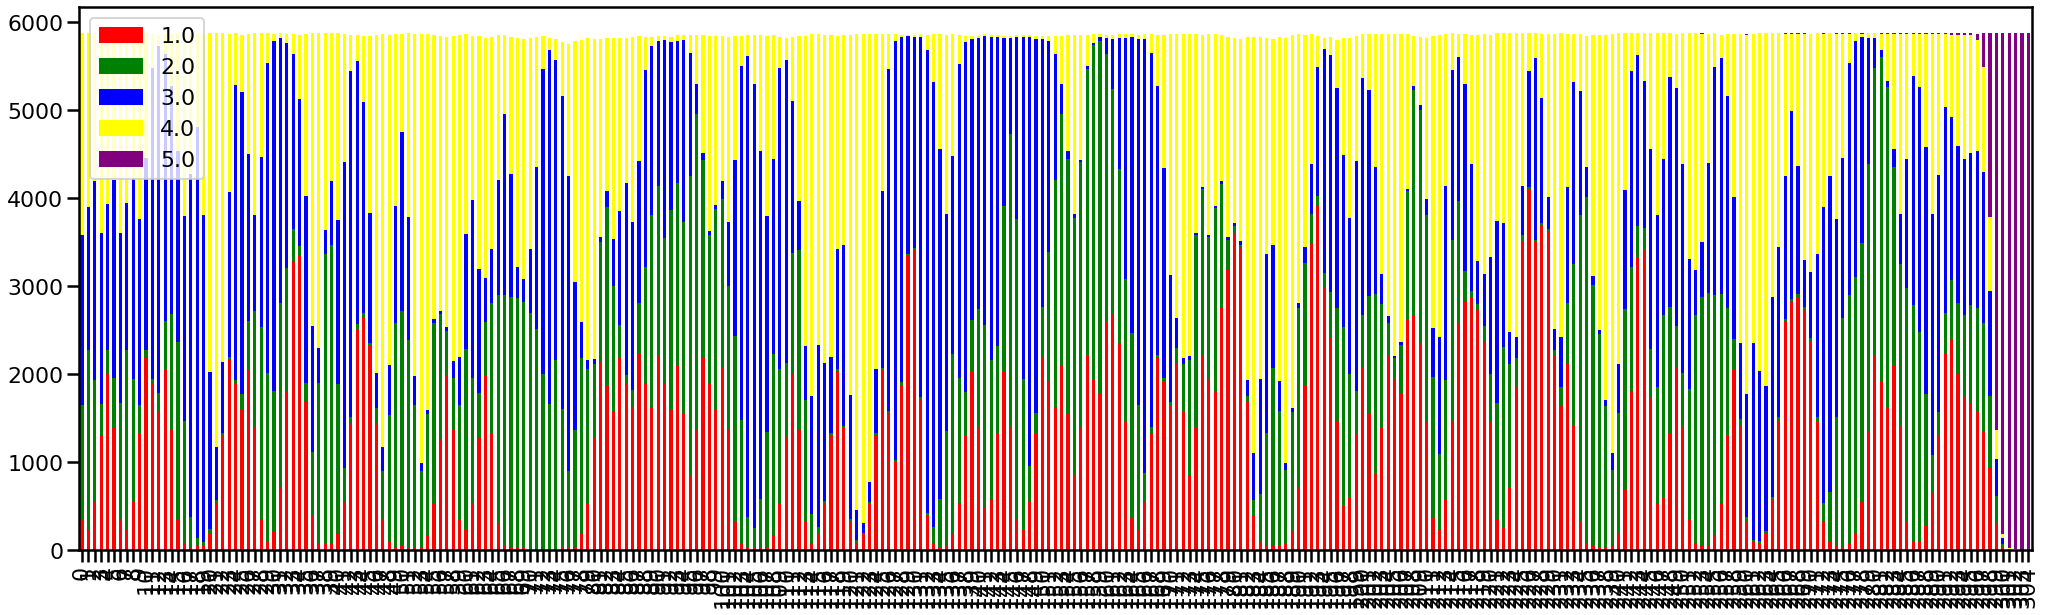

In [354]:
fdf = notaligned.apply(lambda x: x.value_counts(),axis=0).T.fillna(0)
fdf.plot(kind='bar',stacked=True,figsize=(35,10),color = ["#FF0000", "#008000", "#0000FF", "#FFFF00", "#800080", "#00FFFF"])
#plt.xticks(np.arange(0,maxlen,5),rotation=90)

In [1261]:
idx = 322

S.iloc[idx,:]

sequence_ar     TGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGNC...
sequence_igb    CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...
v_call                                              IGHVF8-G45*07
v_call_ar                                           IGHVF8-G45*06
Name: 279432, dtype: object

In [1262]:

S.iloc[idx,:]['sequence_igb']

'CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGNCCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGCAGTAGTAGTTACTACTGGGGCTGGATCCGCCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATTATAGTGGGAGCACCTACTACAACCCGTCCCTCAAGAGTCGAGTCACCATATCCGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCTGTGTATTACTGTGCGA'

In [1263]:
from difflib import context_diff,diff_bytes,ndiff

a = S.iloc[idx,:]['sequence_ar']
b = S.iloc[idx,:]['sequence_igb']

igbvc = V_Alleles[S.iloc[idx,:]['v_call']]
arvc = V_Alleles[S.iloc[idx,:]['v_call_ar']]

# for i in ndiff(a,b):
#     print(i)

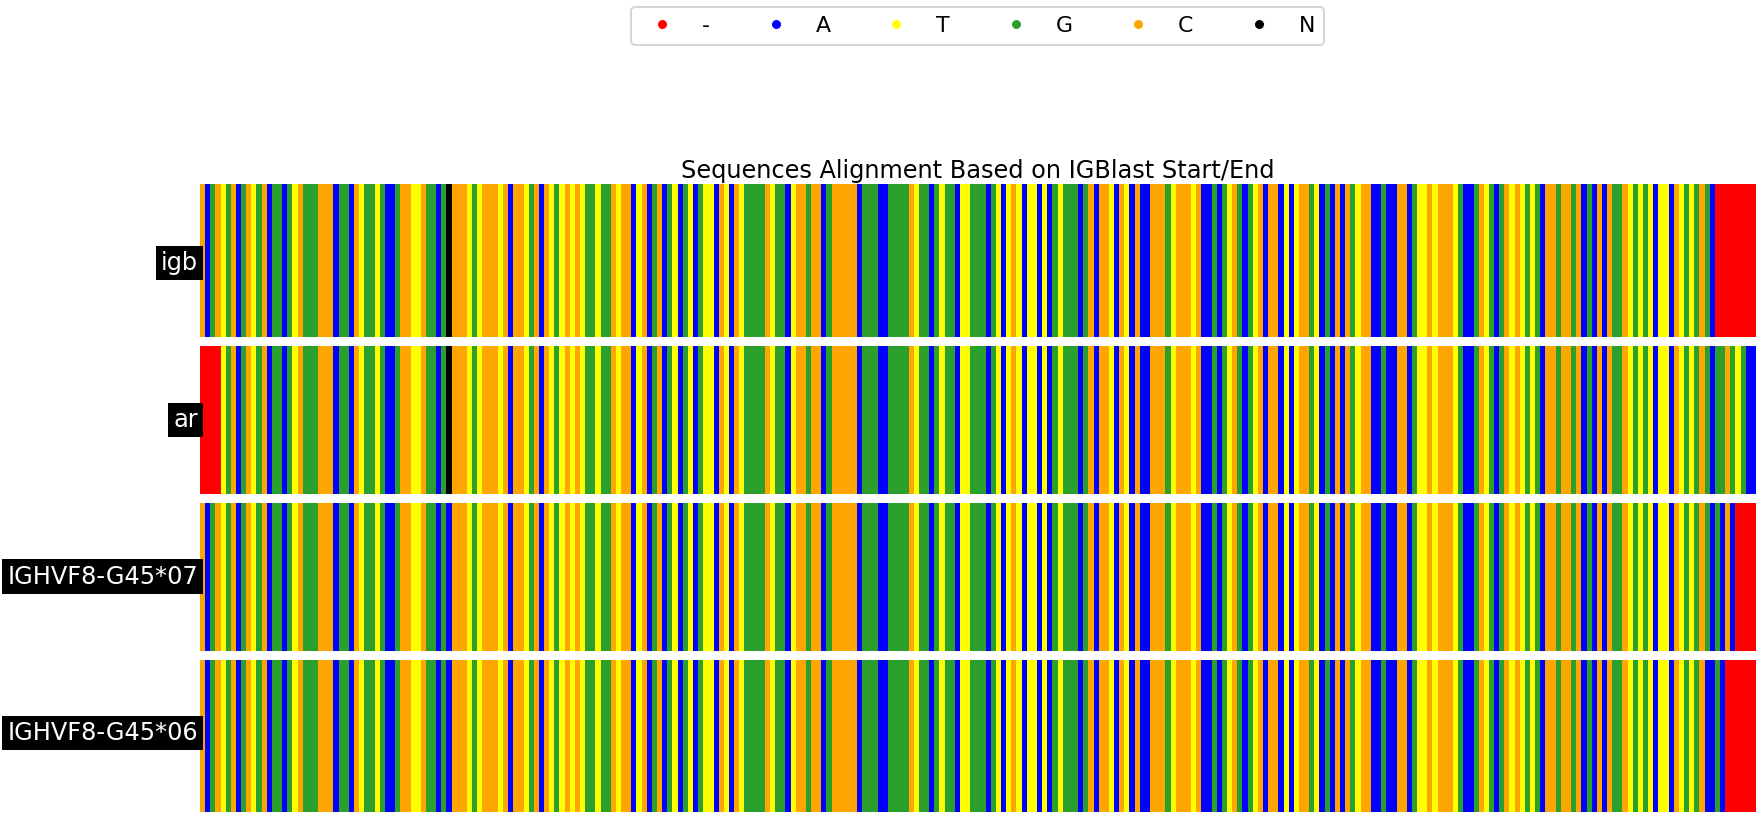

In [1264]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def align_and_plot(sequences,labels):
    """
    Plot the DNA alignment of sequences using different colors for each base.
    :param sequences: List of sequence objects with 'seq' attribute.
    """
    
    # Convert sequences to DataFrame format
    allingment = allign_sequences(sequences)
    adf = pd.DataFrame(data=[list(str(i.seq)) for i in allingment])
    for col in adf.columns:
        adf.loc[:,col] = adf.loc[:,col].map({"-":0,'A':1,'T':2,'G':3,'C':4,'N':5})
    aligned_df = adf

    # Define custom colormap
    custom_colors = ['red', 'blue', 'yellow', 'tab:green', 'orange', 'black']
    cmap = ListedColormap(custom_colors)
    
    fig, ax = plt.subplots(figsize=(25, 12))

    # Display aligned sequences
    ax.imshow(aligned_df, cmap=cmap, aspect="auto")
    ax.set_title('Sequences Alignment Based on IGBlast Start/End')

    # Add horizontal lines and label each line with its corresponding sequence name
    for i, seq in enumerate(sequences):
        if i != 0:
            ax.axhline(i - 0.5, color='white', linewidth=9)
        ax.text(-0.9, i, labels[i], va='center', ha='right', color='white', backgroundcolor='black')
    
    ax.axis('off')
    
    # Add legend
    labels = ['-', 'A', 'T', 'G', 'C', 'N']
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(custom_colors, labels)]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(labels))
    
    plt.tight_layout()
    plt.show()

# Assuming you have your sequence objects in a list called sequences
align_and_plot([b, a, igbvc,arvc],['igb','ar',S.iloc[idx,:]['v_call'],S.iloc[idx,:]['v_call_ar']])


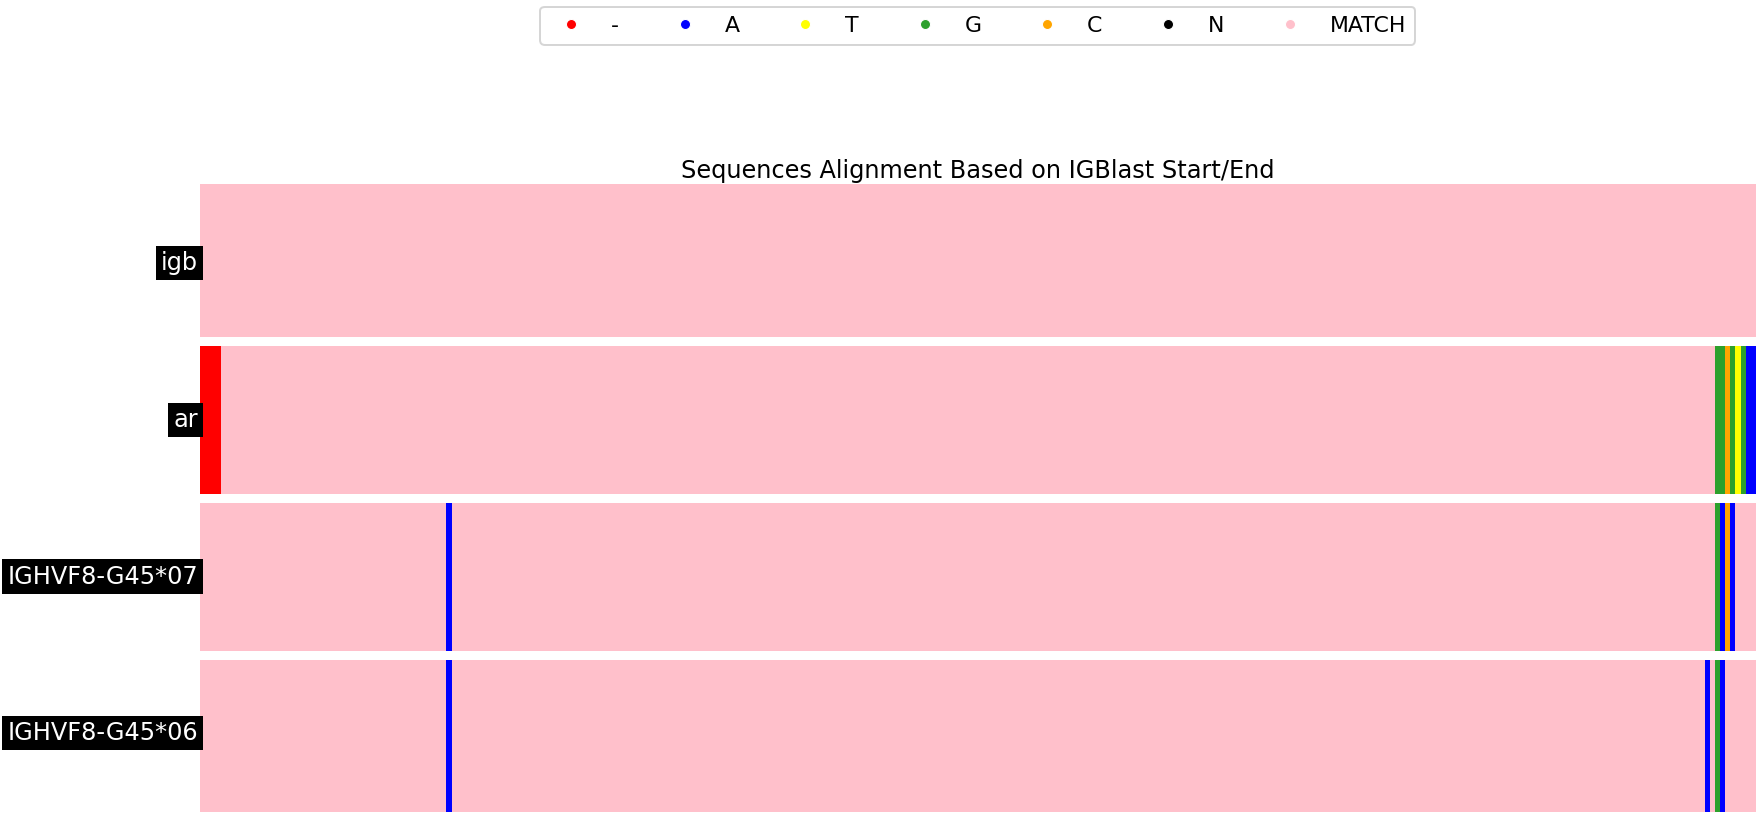

In [1265]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def align_and_plot_S(sequences, labels):
    """
    Plot the DNA alignment of sequences using different colors for each base.
    :param sequences: List of sequence objects with 'seq' attribute.
    :param labels: List of labels for each sequence.
    """
    
    # Convert sequences to DataFrame format
    alignment = allign_sequences(sequences)
    adf = pd.DataFrame(data=[list(str(i.seq)) for i in alignment])

    # Color matching positions with PINK and mismatches with their respective colors
    ref_seq = adf.iloc[0]
    for col in adf.columns:
        adf[col] = adf.apply(lambda row: 'PINK' if row[col] == ref_seq[col] else row[col], axis=1)
    
    # Map bases and PINK to numbers for coloring
    base_to_num = {"PINK": 6, "-": 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4, 'N': 5}
    for col in adf.columns:
        adf[col] = adf[col].map(base_to_num)
    aligned_df = adf

    # Define custom colormap (adding PINK for matching bases)
    custom_colors = ['red', 'blue', 'yellow', 'tab:green', 'orange', 'black', 'pink']
    cmap = ListedColormap(custom_colors)
    
    fig, ax = plt.subplots(figsize=(25, 12))

    # Display aligned sequences
    ax.imshow(aligned_df, cmap=cmap, aspect="auto")
    ax.set_title('Sequences Alignment Based on IGBlast Start/End')

    # Add horizontal lines and label each line with its corresponding sequence name
    for i, label in enumerate(labels):
        if i != 0:
            ax.axhline(i - 0.5, color='white', linewidth=9)
        ax.text(-0.9, i, label, va='center', ha='right', color='white', backgroundcolor='black')
    
    ax.axis('off')
    
    # Add legend
    labels = ['-', 'A', 'T', 'G', 'C', 'N', 'MATCH']
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(custom_colors, labels)]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(labels))
    
    plt.tight_layout()
    plt.show()
align_and_plot_S([b, a, igbvc,arvc],['igb','ar',S.iloc[idx,:]['v_call'],S.iloc[idx,:]['v_call_ar']])


In [1237]:
S

,sequence_ar,sequence_igb,v_call,v_call_ar
1835,AGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4109,CTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4505,TGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGAC...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
6315,GCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
7312,CTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
...,...,...,...,...
4934297,CTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4934645,GCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4934646,GCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4934718,TCCCAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTT...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06


In [326]:
match_df[[allele in i for i in match_df.v_call]]

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites
41,ATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCAC...,95,385,"[IGHVF8-G45*06, IGHVF8-G45*07]",[IGHVF8-G45*06],97,395,[0.8485866]
480,GGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACC...,94,384,"[IGHVF8-G45*06, IGHVF8-G45*07]",[IGHVF8-G45*06],96,395,[0.9357961]
617,GGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACC...,94,385,"[IGHVF8-G45*06, IGHVF8-G45*07]",[IGHVF8-G45*06],97,396,[0.94749576]
682,GATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCA...,96,388,"[IGHVF8-G45*06, IGHVF8-G45*07]",[IGHVF8-G45*06],98,398,[0.9646113]
1019,GGCTTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCAC...,95,388,[IGHVF8-G45*06],[IGHVF8-G45*06],99,397,[0.9073384]
...,...,...,...,...,...,...,...,...
4934781,GATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCA...,96,386,"[IGHVF8-G45*06, IGHVF8-G45*07]",[IGHVF8-G45*06],97,396,[0.66724443]
4934796,GGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACC...,94,386,"[IGHVF8-G45*06, IGHVF8-G45*07]",[IGHVF8-G45*06],96,395,[0.84028727]
4934799,GATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCA...,96,388,"[IGHVF8-G45*06, IGHVF8-G45*07]",[IGHVF8-G45*06],97,398,[0.89911586]
4934802,GATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGNAAATGAAGCA...,96,375,"[IGHVF8-G45*06, IGHVF8-G45*07]",[IGHVF8-G45*07],98,398,[0.3547893]


In [256]:
allele_2

'IGHVF8-G45*07'

In [257]:
mismatch_df[[allele_2 in i for i in mismatch_df.v_call_ar]]

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,ar_allele_probabilites
3537,AATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCA...,96,394,[IGHVF8-G45*05],"[IGHVF8-G45*06, IGHVF8-G45*07]",99,399,"[0.49820805, 0.33914912]"
26368,GCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,93,388,[IGHVF8-G45*05],[IGHVF8-G45*07],95,393,[0.4275504]
30553,GGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACC...,83,381,[IGHVF8-G45*05],"[IGHVF8-G45*06, IGHVF8-G45*07]",86,384,"[0.21711774, 0.16437696]"
45999,GCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCACCT...,93,391,[IGHVF8-G45*05],[IGHVF8-G45*07],95,393,[0.56299335]
121362,GGCTTTCTGAGAGTCATGGACCTCCTGTGCAAGAACATGAAGCACC...,94,391,[IGHVF8-G45*10],[IGHVF8-G45*07],95,393,[0.40766582]
...,...,...,...,...,...,...,...,...
4928974,GTTATGTGGCATCTTGGGGGACATGGGAAGTGCTTTCTGAGAGTCA...,124,413,[IGHVF8-G36*04],"[IGHVF8-G45*03, IGHVF8-G45*07]",122,420,"[0.0123934, 0.009913128]"
4932535,GATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCA...,96,385,[IGHVF8-G45*10],[IGHVF8-G45*07],95,394,[0.054485366]
4933229,GATGCTTTCTGAGAGTCATGGATCTCATGTGCAAGAAAATGAAGCA...,96,393,[IGHVF8-G45*10],[IGHVF8-G45*07],98,398,[0.14205931]
4934681,GAACTCATAAGGGAAATGCTTTCTGAGAGTCATGGATCTCATGTGC...,110,405,[IGHVF8-G45*10],[IGHVF8-G45*07],112,410,[0.28086647]


# Double Alignment

In [188]:
sequences = [
    SeqRecord(Seq(seq), id=f"seq{en}")
    for en,seq in enumerate(S.sequence_igb.to_list()+S.sequence_ar.to_list())
]
SeqIO.write(sequences, r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta", "fasta")
# Define Clustal Omega command
clustalomega_cline = ClustalOmegaCommandline(infile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta",
                                             outfile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", verbose=True, auto=True,force=True)
clustalomega_cline.program_name = r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\clustalo.exe"
stdout, stderr = clustalomega_cline()


alignment = AlignIO.read(r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", "fasta")

In [189]:
# with open('C:/Users/Tomas/Downloads/double_allingment.pkl','wb') as h:
#     pickle.dump((alignment,S),h)

In [190]:
adf = pd.DataFrame(data=[list(str(i.seq)) for i in alignment])

In [191]:
for col in adf.columns:
    adf.loc[:,col] = adf.loc[:,col].map({"-":0,'A':1,'T':2,'G':3,'C':4,'N':5})

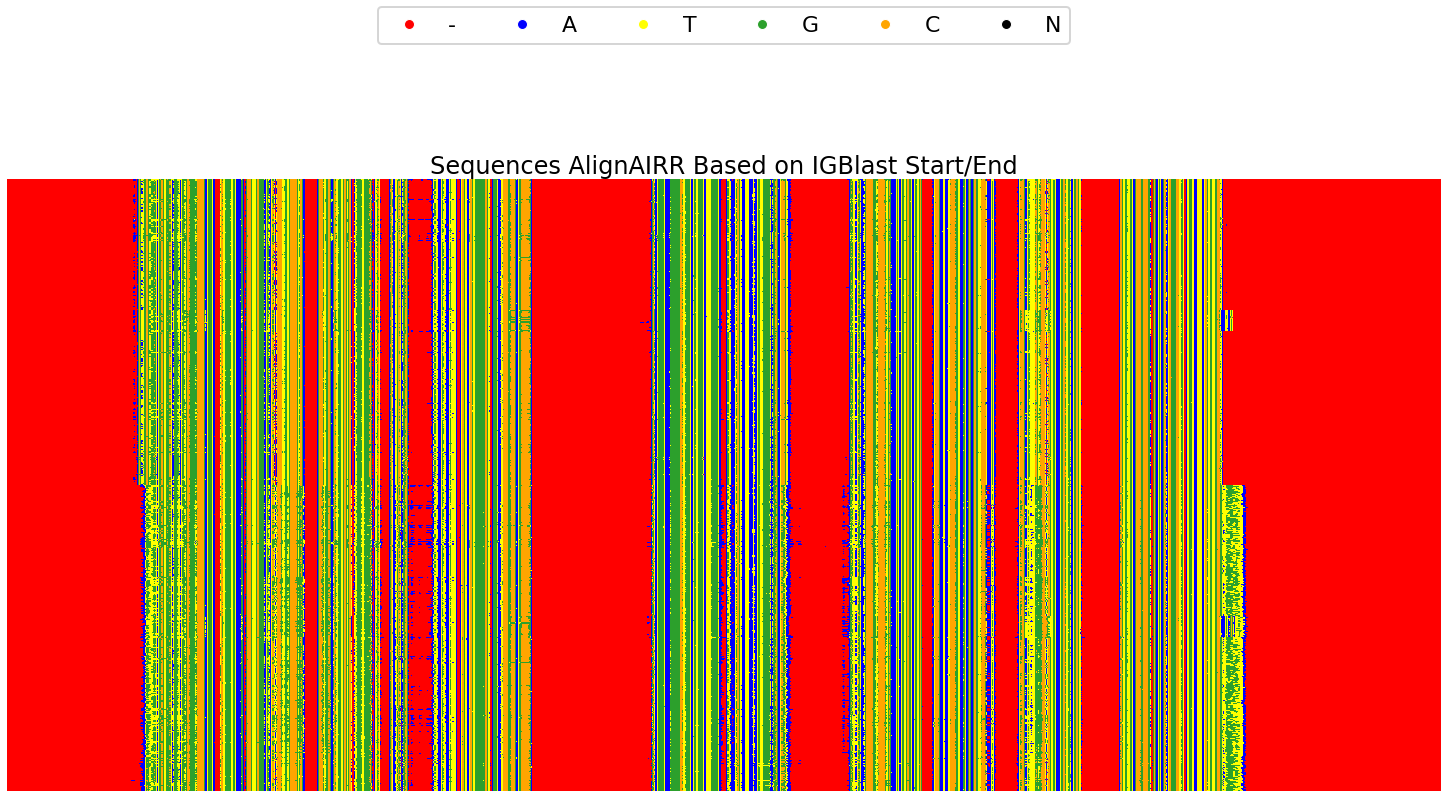

In [192]:

from matplotlib.colors import ListedColormap

# Define the custom colormap based on the given dictionary
custom_colors = ['red', 'blue', 'yellow', 'tab:green', 'orange','black']
cmap = ListedColormap(custom_colors)


fig = plt.figure(layout="constrained")


ax_dict = fig.subplot_mosaic("""AA
                                AA
                                AA
                              """)



colors = custom_colors

im0 = ax_dict['A'].imshow(adf,cmap=cmap, aspect="auto")
ax_dict['A'].set_title('Sequences AlignAIRR Based on IGBlast Start/End')
#im1 = ax_dict['B'].imshow(np.stack([m1.values]*30),cmap='coolwarm', aspect="auto")
#im2 = ax_dict['C'].imshow(np.stack([m2.values]*30),cmap='coolwarm', aspect="auto")
ax_dict['A'].axis('off')
#ax_dict['C'].axis('off')
#ax_dict['B'].axis('off')
#ax_dict['B'].set_title(f'Match Count - {list(add_ref)[1]}')
#ax_dict['C'].set_title(f'Match Count - {list(add_ref)[0]}')

#fig.colorbar(im2, cax=ax_dict['D'], orientation='horizontal',label='Number of Global Matches');


labels = ['-', 'A', 'T', 'G', 'C','N']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, labels)]
ax_dict['A'].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(labels))


In [197]:
S.iloc[0,:]['sequence_ar']

'AGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCACTGTCNCTGGTGGCTCCATCNGCAGTAGTAGTTACTACTGGGGCTGGATCCGCCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATTATAGTGGGAGCACCTACTACAACCCGTCCCTCAAGAGTCGAGTCACCATATCCGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCTGTGTATTACTGTGCGAACGGGGC'

# Oclusion Analysis

In [17]:
from VDeepJModel import VDeepJAllign
from UnboundedTrainer import UnboundedTrainer
from Trainer import Trainer
import tensorflow as tf

In [50]:
utrainer = Trainer(VDeepJAllign,5,512,train_dataset="E:\Immunobiology\AlignAIRR\sim_data_1M_asc_s5f_rate_001.tsv")

In [51]:
utrainer._compile_model()

In [55]:
utrainer.model.load_weights('s5f_after_additional_noiseVDeepJModel_c9e2559e-d45e-40b1-899a-d032986c0b6c_weights')
#utrainer.rebuild_model()
#utrainer.model.v_start_mid.get_weights()

In [1100]:
#utrainer.model.v_start_mid.get_weights()

In [141]:
def get_modeL_eval(seqs,_family,_gene,_allele):
    eval_dataset_ = utrainer.train_dataset.tokenize_sequences(seqs)
    predicted = utrainer.model.predict(
        {'tokenized_sequence': eval_dataset_, 'tokenized_sequence_for_masking': eval_dataset_}
        , batch_size=utrainer.batch_size, verbose=utrainer.verbose)

    predicted['v_start'] = np.round(np.array(list(map(lambda x: max(x),zip(predicted['v_start'].flatten() - (512-np.array(list(map(len,seqs))) )//2,np.array([0]*len(seqs))))))).astype(int)
    predicted['v_end'] = np.round(np.array(list(map(lambda x: max(x),zip(predicted['v_end'].flatten() - (512-np.array(list(map(len,seqs))) )//2,np.array([0]*len(seqs))))))).astype(int)
    v_family_proba = np.array([i[label_num_sub_classes_dict['V']['family'][_family]] for i in predicted['v_family']])
    v_gene_proba = np.array([i[label_num_sub_classes_dict['V']['gene'][_gene]] for i in predicted['v_gene']])
    v_allele_proba = np.array([i[label_num_sub_classes_dict['V']['allele'][_allele]] for i in predicted['v_allele']])
    
    return predicted,v_family_proba,v_gene_proba,v_allele_proba

In [171]:
import random

#### Simple Beggining Corruption

In [946]:
allele_name = random.choice(list(V_Alleles))
_family,_gene,_allele = decompose_call(allele_name)
allele = V_Alleles[allele_name]
#rseq = generate_sequence(locus,load_data())
#rseq = allele+rseq.ungapped_seq[rseq.v_seq_end:]
all_vs = []
for i in range(0,len(allele)-1):
    all_vs.append(allele[i:]+rseq.ungapped_seq[rseq.v_seq_end:])


In [947]:
predicted,v_family_proba,v_gene_proba,v_allele_proba = get_modeL_eval(all_vs,_family,_gene,_allele)

Text(0, 0.5, 'Equaly Distanced Alleles')

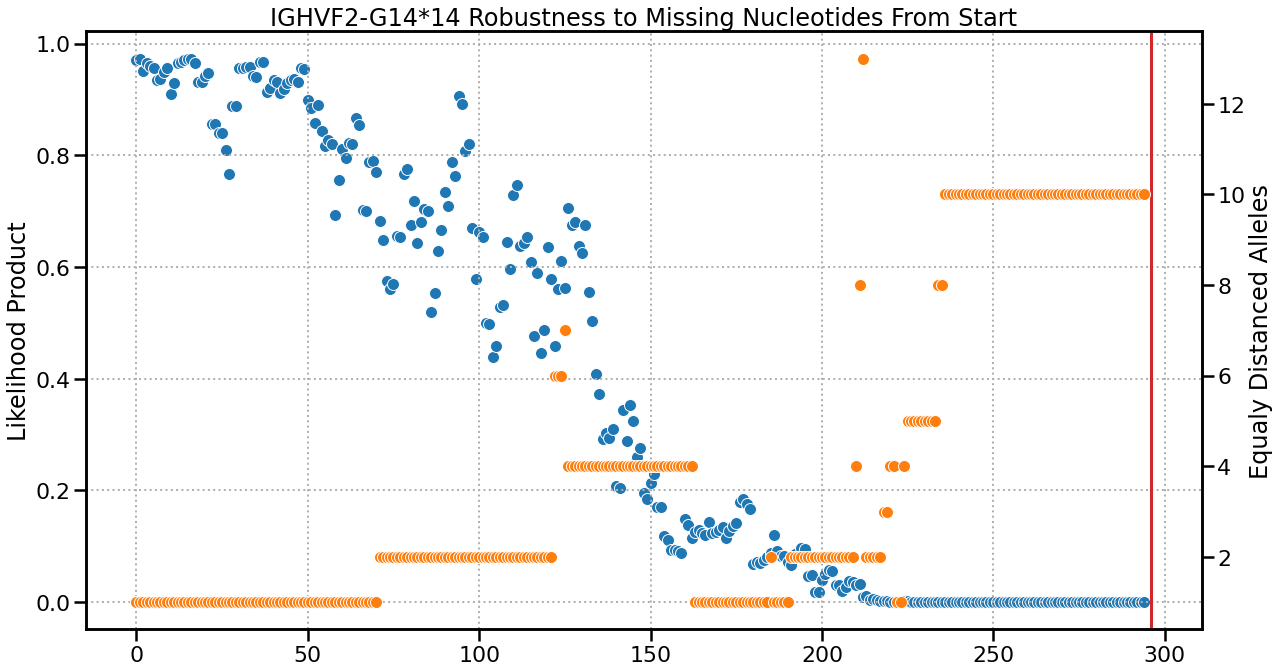

In [948]:
liklihood = v_family_proba*v_gene_proba*v_allele_proba
vlength = np.array(list(range(0,len(allele)-1)))
ax = sns.scatterplot(x=vlength,y=liklihood)
plt.axvline(x=len(allele),color='tab:red',label=f'{allele_name} Length')

plt.title(f'{allele_name} Robustness to Missing Nucleotides From Start')
plt.ylabel('Likelihood Product')
plt.grid(lw=2,ls=':')


_target_allele = allele_name
tl = V_Alleles[_target_allele]
neq = []
for z in range(0,len(tl)-1):
    _t = pd.Series([distance(tl[z:] ,V_Alleles[i]) for i in V_Alleles])
    _t = _t[_t==_t.min()]
    neq.append(len(_t))
    
ax2 = ax.twinx()

sns.scatterplot(x=list(range(0,len(tl)-1)),y=neq,color='tab:orange')
ax2.set_ylabel('Equaly Distanced Alleles')


In [945]:
liklihoods=[]
lengths = []
o_lengths = []
for allele_name in tqdm(list(V_Alleles)):
    allele_name = random.choice(list(V_Alleles))
    _family,_gene,_allele = decompose_call(allele_name)
    allele = V_Alleles[allele_name]
    rseq = generate_sequence(locus,load_data())
    #rseq = allele+rseq.ungapped_seq[rseq.v_seq_end:]
    all_vs = []
    for i in range(0,len(allele)-1):
        all_vs.append(allele[i:]+rseq.ungapped_seq[rseq.v_seq_end:])
    predicted,v_family_proba,v_gene_proba,v_allele_proba = get_modeL_eval(all_vs,_family,_gene,_allele)
    liklihood = v_family_proba*v_gene_proba*v_allele_proba
    vlength = np.array(list(range(0,len(allele)-1)))
    
    liklihoods.append(liklihood)
    lengths.append(vlength)
    o_lengths.append(len(allele))

  0%|          | 0/280 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Simple Beggining Corruption + Replace With Noise

In [229]:
alignment = allign_sequences(list(V_Alleles.values()))

<<class 'Bio.Align.MultipleSeqAlignment'> instance (280 records of length 310) at 209aa7a5f10>

In [315]:
alignment = AlignIO.read(r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", "fasta")
adf = pd.DataFrame(data=[list(str(i.seq)) for i in alignment])
fdf = adf.apply(lambda x: x.value_counts(),axis=0).T.fillna(0)
fdfn = fdf.apply(lambda x: x/x.sum(),axis=1)
ent = fdfn.apply(lambda x: entropy(x[x!='-']),axis=1)
#ent = ((ent-ent.min())/(ent.max()-ent.min())).values.reshape(1,-1)

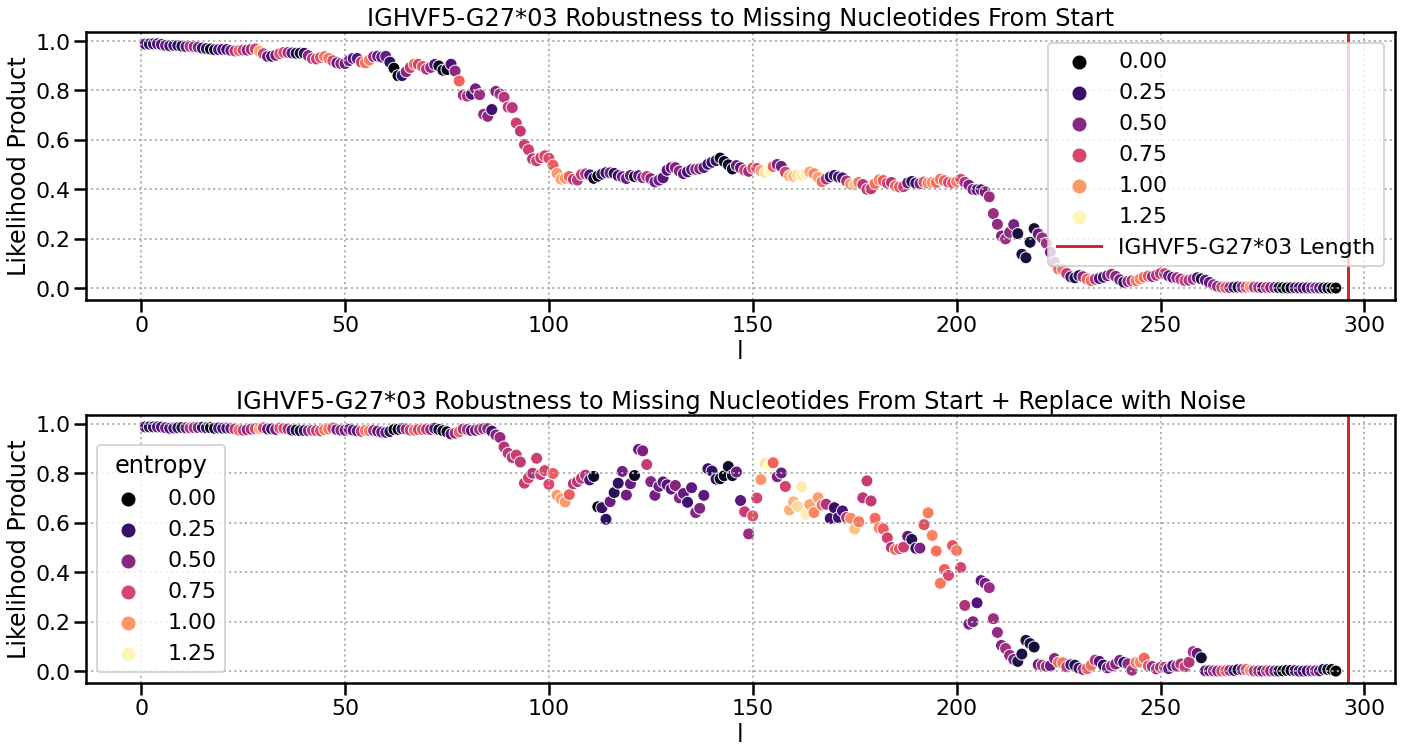

In [319]:
allele_name = random.choice(list(V_Alleles))
_family,_gene,_allele = decompose_call(allele_name)
allele = V_Alleles[allele_name]
rseq = generate_sequence(locus,load_data())
#rseq = allele+rseq.ungapped_seq[rseq.v_seq_end:]
plt.subplot(2,1,1)
all_vs = []
for i in range(0,len(allele)-1):
    all_vs.append(allele[i:]+rseq.ungapped_seq[rseq.v_seq_end:])

    
predicted,v_family_proba,v_gene_proba,v_allele_proba = get_modeL_eval(all_vs,_family,_gene,_allele)
liklihood = v_family_proba*v_gene_proba*v_allele_proba
vlength = np.array(list(range(0,len(allele)-1)))
temp = pd.DataFrame({'l':vlength,'liklihood':liklihood,'entropy':ent.iloc[:len(vlength)]})
temp = temp.rolling(window=3).mean()
sns.scatterplot(data= temp,x='l',y='liklihood',hue='entropy',palette='magma')
plt.axvline(x=len(allele),color='tab:red',label=f'{allele_name} Length')

plt.title(f'{allele_name} Robustness to Missing Nucleotides From Start')
plt.ylabel('Likelihood Product')
plt.grid(lw=2,ls=':')
plt.legend()
plt.subplot(2,1,2)
all_vs = []
for i in range(0,len(allele)-1):
    all_vs.append(''.join(np.random.choice(['A','T','C','G'],size=i))+allele[i:]+rseq.ungapped_seq[rseq.v_seq_end:])

    
predicted,v_family_proba,v_gene_proba,v_allele_proba = get_modeL_eval(all_vs,_family,_gene,_allele)
liklihood = v_family_proba*v_gene_proba*v_allele_proba
vlength = np.array(list(range(0,len(allele)-1)))
temp = pd.DataFrame({'l':vlength,'liklihood':liklihood,'entropy':ent.iloc[:len(vlength)]})
temp = temp.rolling(window=3).mean()
sns.scatterplot(data= temp,x='l',y='liklihood',hue='entropy',palette='magma')
plt.axvline(x=len(allele),color='tab:red',label=f'{allele_name} Length')

plt.title(f'{allele_name} Robustness to Missing Nucleotides From Start + Replace with Noise')
plt.ylabel('Likelihood Product')
plt.grid(lw=2,ls=':')
#plt.legend()
plt.tight_layout()

### GradCAM

In [586]:
import tensorflow.keras.backend as K

rev_tokenizer_dictionary = {
            1:"A",
            2:"T",
            3:"G",
            4:"C",
            5:"N",
            0:"P",  # pad token
        }


def call_hierarchy_loss(family_true, gene_true, allele_true, family_pred, gene_pred, allele_pred):
    if family_true != None:
        family_loss = K.categorical_crossentropy(
            family_true, family_pred
        )  # K.categorical_crossentropy
    gene_loss = K.categorical_crossentropy(gene_true, gene_pred)
    allele_loss = K.categorical_crossentropy(allele_true, allele_pred)

    # family_loss_mean = K.mean(family_loss)
    # gene_loss_mean = K.mean(gene_loss)
    # allele_loss_mean = K.mean(allele_loss)

    # Penalty for wrong family classification
    penalty_upper = K.constant([10.0])
    penalty_mid = K.constant([5.0])
    penalty_lower = K.constant([1.0])

    if family_true != None:
        family_penalty = K.switch(
            K.not_equal(K.argmax(family_true), K.argmax(family_pred)),
            penalty_upper,
            penalty_lower,
        )
        gene_penalty = K.switch(
            K.not_equal(K.argmax(gene_true), K.argmax(gene_pred)),
            penalty_mid,
            penalty_lower,
        )
    else:
        family_penalty = K.switch(
            K.not_equal(K.argmax(gene_true), K.argmax(gene_pred)),
            penalty_upper,
            penalty_lower,
        )

    # Compute the final loss based on the constraint
    if family_true != None:
        loss = K.switch(
            K.not_equal(K.argmax(family_true), K.argmax(family_pred)),
            family_penalty * (family_loss + gene_loss + allele_loss),
            K.switch(
                K.not_equal(K.argmax(gene_true), K.argmax(gene_pred)),
                family_loss + gene_penalty * (gene_loss + allele_loss),
                family_loss + gene_loss + penalty_upper * allele_loss,
            ),
        )
    else:
        loss = K.switch(
            K.not_equal(K.argmax(gene_true), K.argmax(gene_pred)),
            family_penalty * (gene_loss + allele_loss),
            gene_loss + penalty_upper * allele_loss,
        )

    return K.mean(loss)

In [714]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
def generate_colored_html(characters, values, colormap='viridis'):
    # Normalize values between 0 and 1
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    cmap = plt.get_cmap(colormap)
    colors = [cmap(val) for val in normalized_values]
    colors = [(int(r*255), int(g*255), int(b*255)) for r, g, b, _ in colors]  # Unpack RGBA
    
    html_parts = [
        f"""
        <span class='char-tooltip' tabindex="0" style='color: rgb{color}; font-size: 20px; margin-right: 5px; cursor: pointer;' data-value='{value}'>
            {char}
            <span class='tooltip-content'>Pos: {value}</span>
        </span>
        """ for char, color, value in zip(characters, colors, list(range(0,len(characters))))
    ]
    js_script = """
        <script>
            let isMouseDown = false;

            document.addEventListener('mousedown', function() {
                isMouseDown = true;
            });

            document.addEventListener('mouseup', function() {
                isMouseDown = false;
            });

            let charTooltips = document.querySelectorAll('.char-tooltip');

            charTooltips.forEach(function(span) {
                span.addEventListener('mouseover', function() {
                    if (isMouseDown) {
                        this.style.border = '2px solid #000';
                    }
                });
            });
        </script>
    """
    
    # CSS for styling
    css_js = """
        <style>
            .char-tooltip {
                position: relative;
            }

            .char-tooltip:active {    /* Apply border on active state */
                border: 2px solid #000;
                box-sizing: border-box; /* To prevent layout shift */
            }

            .char-tooltip .tooltip-content {
                visibility: hidden;
                background-color: #555;
                color: #fff;
                text-align: center;
                border-radius: 5px;
                padding: 5px;
                position: absolute;
                z-index: 1;
                top: 100%;
                left: 50%;
                margin-left: -50px;
                opacity: 0;
                transition: opacity 0.2s;
            }

            .char-tooltip:hover .tooltip-content {
                visibility: visible;
                opacity: 1;
            }
        </style>
    """
    combined_html = "".join(html_parts)
    return f"<div style='background-color: black; padding: 10px;'>{combined_html}</div>" + css_js+js_script


In [860]:
allele_name = random.choice(list(V_Alleles))
print(allele_name)
_family,_gene,_allele = decompose_call(allele_name)
allele = V_Alleles[allele_name]
rseq = generate_sequence(locus,load_data())
#rseq = allele+rseq.ungapped_seq[rseq.v_seq_end:]


IGHVF2-G15*03


In [952]:
all_vs = [allele[0:]+rseq.ungapped_seq[rseq.v_seq_end:]]

eval_dataset_ = utrainer.train_dataset.tokenize_sequences(all_vs)
eval_dataset = {'tokenized_sequence': eval_dataset_, 'tokenized_sequence_for_masking': eval_dataset_}

In [953]:
from tensorflow.keras.layers import Flatten
def get_gradcam_hmap(_allele):
    with tf.GradientTape() as tape:
        #y_pred = utrainer.model(eval_dataset, training=False)  # Forward pass

        # STEP 1 : Produce embeddings for the input sequence
        input_seq = utrainer.model.reshape_and_cast_input(eval_dataset["tokenized_sequence"])
        concatenated_input_embedding = utrainer.model.concatenated_input_embedding(input_seq)
        concatenated_input_embedding = utrainer.model.initial_embedding_attention(
            [concatenated_input_embedding, concatenated_input_embedding]
        )

        # STEP 2: Run Embedded sequence through 1D convolution to distill temporal features
        conv_layer_1 = utrainer.model.conv_layer_1(concatenated_input_embedding)
        conv_layer_2 = utrainer.model.conv_layer_2(conv_layer_1)
        conv_layer_3 = utrainer.model.conv_layer_3(conv_layer_2)
        last_conv_layer = utrainer.model.conv_layer_4(conv_layer_3)

        # STEP 3 : Flatten The Feature Derived from the 1D conv layers
        concatenated_signals = last_conv_layer
        concatenated_signals = Flatten()(concatenated_signals)
        concatenated_signals = utrainer.model.initial_feature_map_dropout(concatenated_signals)

        # STEP 4 : Predict The Intervals That Contain The V,D and J Genes using (V_start,V_end,D_Start,D_End,J_Start,J_End)
        v_start, v_end, d_start, d_end, j_start, j_end = utrainer.model._predict_intervals(
            concatenated_signals
        )

        # STEP 5: Use predicted masks to create a binary vector with the appropriate intervals to  "cutout" the relevant V,D and J section from the input
        v_mask = utrainer.model.v_call_mask([v_start, v_end])
        d_mask = utrainer.model.d_call_mask([d_start, d_end])
        j_mask = utrainer.model.j_call_mask([j_start, j_end])

        # Get the second copy of the inputs
        input_seq_for_masked = utrainer.model.reshape_and_cast_input(
            eval_dataset["tokenized_sequence_for_masking"]
        )

        # STEP 5: Multiply the mask with the input vector to turn of (set as zero) all position that dont match mask interval
        masked_sequence_v = utrainer.model.v_mask_extractor((input_seq_for_masked, v_mask))

        # STEP 6: Extract new Feature
        # Create Embeddings from the New 4 Channel Concatenated Signal using an Embeddings Layer - Apply for each Gene
        v_mask_input_embedding = utrainer.model.concatenated_v_mask_input_embedding(
            masked_sequence_v
        )


        # Pass The Embeddings Generated Above Thorough 2D Convolutional Feature Extractor Layer
        v_conv_layer_1 = utrainer.model.conv_v_layer_1(v_mask_input_embedding)
        v_conv_layer_2 = utrainer.model.conv_v_layer_2(v_conv_layer_1)
        v_conv_layer_3 = utrainer.model.conv_v_layer_3(v_conv_layer_2)
        v_feature_map_nf = utrainer.model.conv_v_layer_4(v_conv_layer_3)
        v_feature_map = Flatten()(v_feature_map_nf)

        v_family_middle = utrainer.model.v_family_call_middle(v_feature_map)
        v_family_middle = utrainer.model.v_family_dropout(v_family_middle)
        v_family = utrainer.model.v_family_call_head(v_family_middle)

        v_gene_middle = utrainer.model.v_gene_call_middle(v_feature_map)
        v_gene_middle = utrainer.model.v_gene_call_family_gene_concat(
            [v_gene_middle, v_family_middle]
        )
        v_gene_middle = utrainer.model.v_gene_dropout(v_gene_middle)
        v_gene = utrainer.model.v_gene_call_head(v_gene_middle)


        v_allele_middle = utrainer.model.v_allele_call_middle(v_feature_map)
        v_allele_middle = utrainer.model.v_gene_call_gene_allele_concat(
            [v_family_middle, v_gene_middle, v_allele_middle]
        )
        v_allele_middle = utrainer.model.v_allele_dropout(v_allele_middle)
        v_allele_middle = utrainer.model.v_allele_feature_distill(v_allele_middle)
        v_allele = utrainer.model.v_allele_call_head(v_allele_middle)


        family_true = np.repeat(utrainer.train_dataset.get_ohe('V','family',[_family]),len(all_vs),axis=0)
        gene_true   = np.repeat(utrainer.train_dataset.get_ohe('V','gene',[_gene]),len(all_vs),axis=0)
        allele_true = np.repeat(utrainer.train_dataset.get_ohe('V','allele',[_allele]),len(all_vs),axis=0)

        family_true = utrainer.model.c2f32(family_true)
        gene_true = utrainer.model.c2f32(gene_true)
        allele_true = utrainer.model.c2f32(allele_true)

        family_pred, gene_pred, allele_pred = v_family,v_gene,v_allele

        # Compute the loss value
        # (the loss function is configured in `compile()`)
        # loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        #loss = call_hierarchy_loss(family_true, gene_true, allele_true, family_pred, gene_pred, allele_pred)

        # Forward pass
        target_class = v_allele[0][label_num_sub_classes_dict['V']['allele'][_allele]]

        # Get the gradients of the target class with respect to the output feature map of the target layer
        grads = tape.gradient(target_class, v_feature_map_nf)

        # Compute the importance of each feature map: weights are given by the average of the gradient values
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

        # Multiply each channel in the feature map array by its "importance" 
        heatmap = np.dot(v_feature_map_nf[0], pooled_grads)

        # ReLU the heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)  # normalize
    return heatmap/

In [954]:
heatmap = get_gradcam_hmap(_allele)
inseq =  eval_dataset['tokenized_sequence'][0]
input_sequence_length = len(inseq)
heatmap_rescaled = np.interp(np.arange(input_sequence_length), np.linspace(0, input_sequence_length - 1, len(heatmap)), heatmap)

heatmap_rescaled = heatmap_rescaled[inseq!=0]
inseq = inseq[inseq!=0]
inseq = [rev_tokenizer_dictionary[i] for i in inseq]

html_content = generate_colored_html(list(inseq), heatmap_rescaled, colormap='coolwarm')
display(HTML(html_content))

In [864]:
hmps = []
for i in tqdm(list(label_num_sub_classes_dict['V']['allele'])):
    heatmap = get_gradcam_hmap(i)
    inseq =  eval_dataset['tokenized_sequence'][0]
    input_sequence_length = len(inseq)
    heatmap_rescaled = np.interp(np.arange(input_sequence_length), np.linspace(0, input_sequence_length - 1, len(heatmap)), heatmap)
    heatmap_rescaled = heatmap_rescaled[inseq!=0]

    hmps.append(heatmap_rescaled)

  0%|          | 0/35 [00:00<?, ?it/s]

In [865]:
allele_name

'IGHVF2-G15*03'

<AxesSubplot:title={'center':'IGHVF2-G15*03'}>

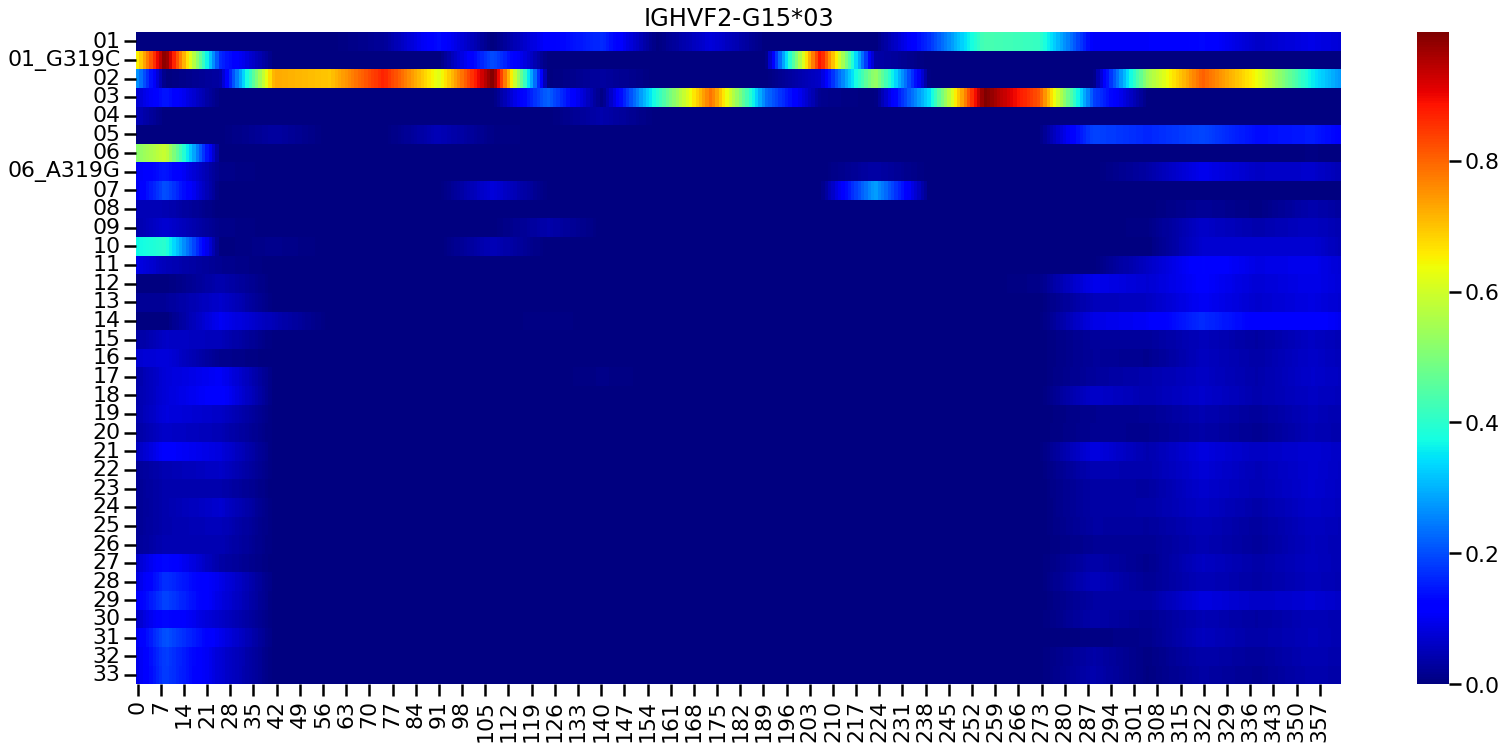

In [866]:
plt.figure(figsize=(27,12))
plt.title(allele_name)
sns.heatmap(np.vstack(hmps),yticklabels=list(label_num_sub_classes_dict['V']['allele']),cmap='jet')

#### Oclusion Mismatch Analysis

In [868]:
eval_dataset_ = utrainer.train_dataset.tokenize_sequences(mismatch_df.loc[[33],'sequence'].to_list())
eval_dataset = {'tokenized_sequence': eval_dataset_, 'tokenized_sequence_for_masking': eval_dataset_}

In [871]:
hmps = []
for i in tqdm(list(label_num_sub_classes_dict['V']['allele'])):
    heatmap = get_gradcam_hmap(i)
    inseq =  eval_dataset['tokenized_sequence'][0]
    input_sequence_length = len(inseq)
    heatmap_rescaled = np.interp(np.arange(input_sequence_length), np.linspace(0, input_sequence_length - 1, len(heatmap)), heatmap)
    heatmap_rescaled = heatmap_rescaled[inseq!=0]

    hmps.append(heatmap_rescaled)

  0%|          | 0/35 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'IGHVF2-G15*03'}>

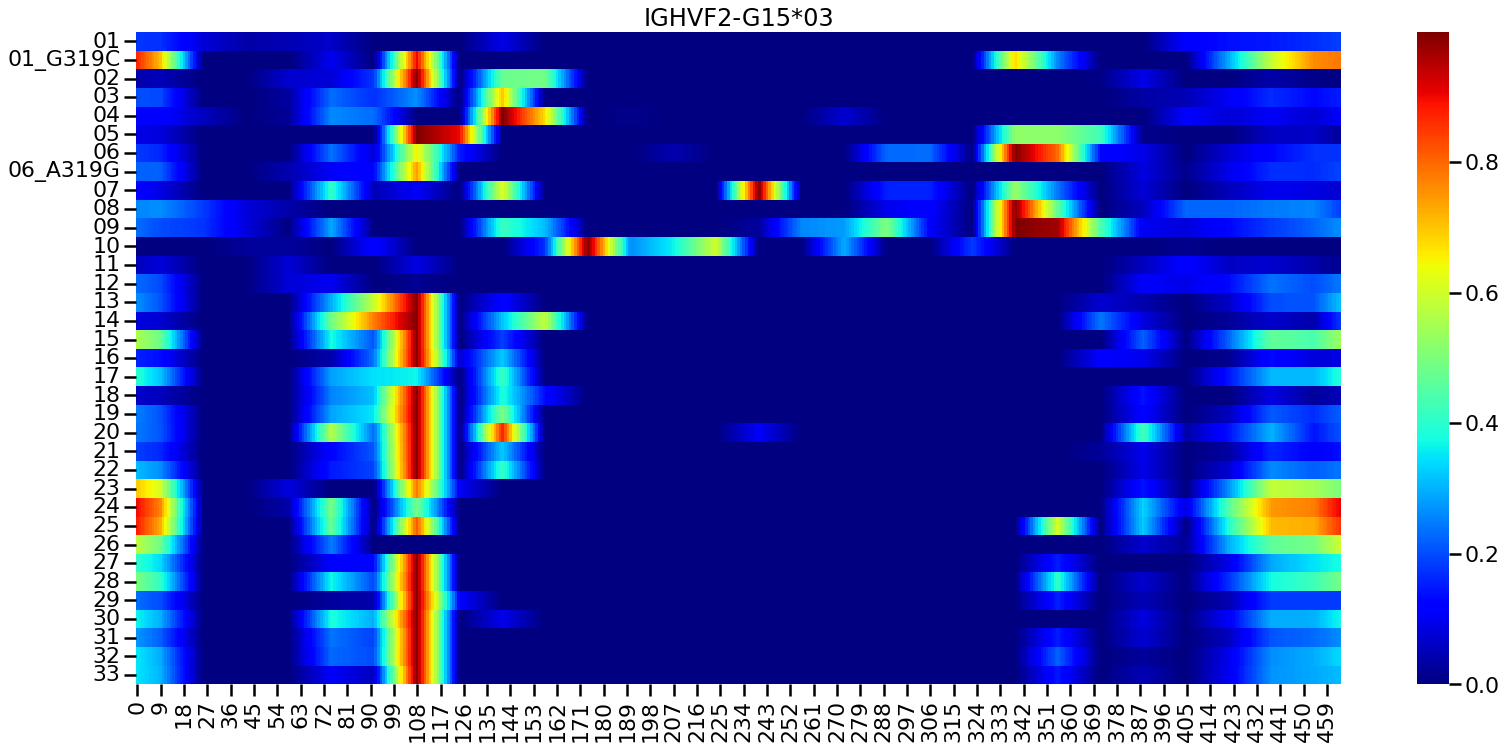

In [872]:
plt.figure(figsize=(27,12))
plt.title(allele_name)
sns.heatmap(np.vstack(hmps),yticklabels=list(label_num_sub_classes_dict['V']['allele']),cmap='jet')

In [1010]:
_names =[]
_hmaps = []
va = None
i = 0
seq = mismatch_df.iloc[i,0]
for call in mismatch_df.iloc[i,4]:
    _names.append(call)
    f,g,a = decompose_call(call)
    eval_dataset_ = utrainer.train_dataset.tokenize_sequences([seq])
    eval_dataset = {'tokenized_sequence': eval_dataset_, 'tokenized_sequence_for_masking': eval_dataset_}
    heatmap = get_gradcam_hmap(a)
    inseq =  eval_dataset['tokenized_sequence'][0]
    input_sequence_length = len(inseq)
    heatmap_rescaled = np.interp(np.arange(input_sequence_length), np.linspace(0, input_sequence_length - 1, len(heatmap)), heatmap)
    
    heatmap_rescaled = heatmap_rescaled[inseq!=0]
    inseq = inseq[inseq!= 0]
    inseq = inseq[int(np.round(mismatch_df.iloc[i]['v_sequence_start_ar'],0)) :int(np.round(mismatch_df.iloc[i]['v_sequence_end_ar'],0))]
    heatmap_rescaled = heatmap_rescaled[int(np.round(mismatch_df.iloc[i]['v_sequence_start_ar'],0)) :int(np.round(mismatch_df.iloc[i]['v_sequence_end_ar'],0))]
    va = (seq[int(np.round(mismatch_df.iloc[i]['v_sequence_start_ar'],0)) :int(np.round(mismatch_df.iloc[i]['v_sequence_end_ar'],0))])

    _hmaps.append(heatmap_rescaled)

In [1014]:
impc = pd.DataFrame({'base':list(va),'imp':_hmaps[0],'pos':list(range(len(va)))})
#impc = impc[impc.imp != 0].sort_values(by='imp',ascending=False)
impc

,base,imp,pos
0,A,0.175276,0
1,G,0.165795,1
2,G,0.156314,2
3,T,0.146832,3
4,G,0.137351,4
...,...,...,...
296,G,0.000000,296
297,G,0.000000,297
298,G,0.000000,298
299,G,0.000000,299


In [1017]:

html_content = generate_colored_html(list(va), _hmaps[0], colormap='coolwarm')
display(HTML(html_content))

In [1021]:
arc = mismatch_df.iloc[i,:]['v_call']
igbc = mismatch_df.iloc[i,:]['v_call_ar']

In [1031]:
alignment = allign_sequences([va,V_Alleles[arc[0]], V_Alleles[igbc[0]]])
adf = pd.DataFrame(data=[list(str(i.seq)) for i in alignment],index=['input',arc[0],igbc[0]])

In [1046]:
top95 = impc[impc.imp > impc.imp.quantile(0.92)]

In [1048]:
adf[top95.pos].T

,input,IGHVF8-G36*09,IGHVF8-G36*07
47,N,G,C
48,A,A,A
49,C,C,C
50,C,C,C
134,G,G,G
135,G,G,G
136,A,A,A
137,G,G,G
138,T,T,T
139,G,G,G


## Alignment Mismatch Analysis

In [1266]:
allele

'IGHVF8-G45*06'

In [1267]:
from Bio import SeqIO
ihgv_map = {}
#IGHV = SeqIO.read(r"C:/Users/Tomas/Downloads/IGHV.fasta", "fasta")
for record in SeqIO.parse(r"C:/Users/Tomas/Downloads/IGHV.fasta", "fasta"):
    ihgv_map[record.id.split('|')[1]] = str(record.seq).upper()

In [1268]:
add_ref ={
    allele:V_Alleles[allele],
    allele_2:V_Alleles[allele_2]

}

In [1269]:
add_ref

{'IGHVF8-G45*06': 'CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGCAGTAGTAGTTACTACTGGGGCTGGATCCGCCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATTATAGTGGGAGCACCTACTACAACCCGTCCCTCAAGAGTCGAGTCACCATATCCGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCTGTGTATTACTGTGCAAGA',
 'IGHVF8-G45*07': 'CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGCAGTAGTAGTTACTACTGGGGCTGGATCCGCCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATTATAGTGGGAGCACCTACTACAACCCGTCCCTCAAGAGTCGAGTCACCATATCCGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCTGTGTATTACTGTGCGAGACA'}

In [1335]:
single_call_mss = single_call.copy()
S = single_call_mss[(single_call_mss.v_call_ar == allele) &(single_call_mss.v_call == allele_2) ].copy()
S.loc[:,'sequence_igb'] = S.apply(lambda x: x['sequence'][(x['v_sequence_start']-1):(x['v_sequence_end']-1)],axis=1)
S.loc[:,'sequence_ar'] = S.apply(lambda x: x['sequence'][(x['v_sequence_start_ar']):(x['v_sequence_end_ar'])],axis=1)
S = S[['sequence_ar','sequence_igb','v_call','v_call_ar']]
S = S[S.sequence_ar.str.len() > 1]

for c in ['sequence_ar','sequence_igb']:
    for k in add_ref:
        S.loc[f'true_{k}',c] = add_ref[k].replace('.','')
        S.loc[f'true_{k}',c] = add_ref[k].replace('.','')
        S.loc[f'true_{k}',c] = add_ref[k].replace('.','')

S

,sequence_ar,sequence_igb,v_call,v_call_ar
1835,AGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4109,CTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4505,TGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGAC...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
6315,GCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
7312,CTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGA...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
...,...,...,...,...
4934646,GCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4934718,TCCCAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTT...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
4934721,CCCAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTC...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHVF8-G45*07,IGHVF8-G45*06
true_IGHVF8-G45*06,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,NaN,NaN


In [1336]:
S.sequence_igb.str.len().max()

324

In [1304]:
# Write sequences to a FASTA file
sequences = [
    SeqRecord(Seq(seq), id=f"seq{en}")
    for en,seq in enumerate(S.sequence_igb)
]
SeqIO.write(sequences, r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta", "fasta")

# Define Clustal Omega command
clustalomega_cline = ClustalOmegaCommandline(infile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta",
                                             outfile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", verbose=True, auto=True,force=True)
clustalomega_cline.program_name = r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\clustalo.exe"
stdout, stderr = clustalomega_cline()

alignment = AlignIO.read(r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", "fasta")

In [1305]:
# Write sequences to a FASTA file
sequences = [
    SeqRecord(Seq(seq), id=f"seq{en}")
    for en,seq in enumerate(S.sequence_ar)
]
SeqIO.write(sequences, r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta", "fasta")

# Define Clustal Omega command
clustalomega_cline = ClustalOmegaCommandline(infile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\sequences.fasta",
                                             outfile=r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", verbose=True, auto=True,force=True)
clustalomega_cline.program_name = r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\clustalo.exe"
stdout, stderr = clustalomega_cline()

alignment_ar = AlignIO.read(r"C:\Users\Tomas\Downloads\clustal-omega-1.2.2-win64\clustal-omega-1.2.2-win64\aligned.fasta", "fasta")

In [1337]:
adf = pd.DataFrame(data=[list(str(i.seq)) for i in alignment_ar])
adf.index = S.index
adf

,0,1,2,3,4,5,6,7,8,9,...,506,507,508,509,510,511,512,513,514,515
1835,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4109,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4505,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
6315,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
7312,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4934646,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4934718,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4934721,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
true_IGHVF8-G45*06,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [1314]:
list(add_ref)[1]

'IGHVF8-G45*07'

In [1315]:
m1 = adf.progress_apply(lambda x:  sum( x.iloc[:-2].apply(lambda y: y == x.iloc[-1] ) ) ,axis=0)
m2 = adf.progress_apply(lambda x:  sum( x.iloc[:-2].apply(lambda y: y == x.iloc[-2] ) ) ,axis=0)

  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

In [1316]:
m1.mean()

6677.2959183673465

In [1317]:
for col in adf.columns:
    adf.loc[:,col] = adf.loc[:,col].map({"-":0,'A':1,'T':2,'G':3,'C':4,'N':5})

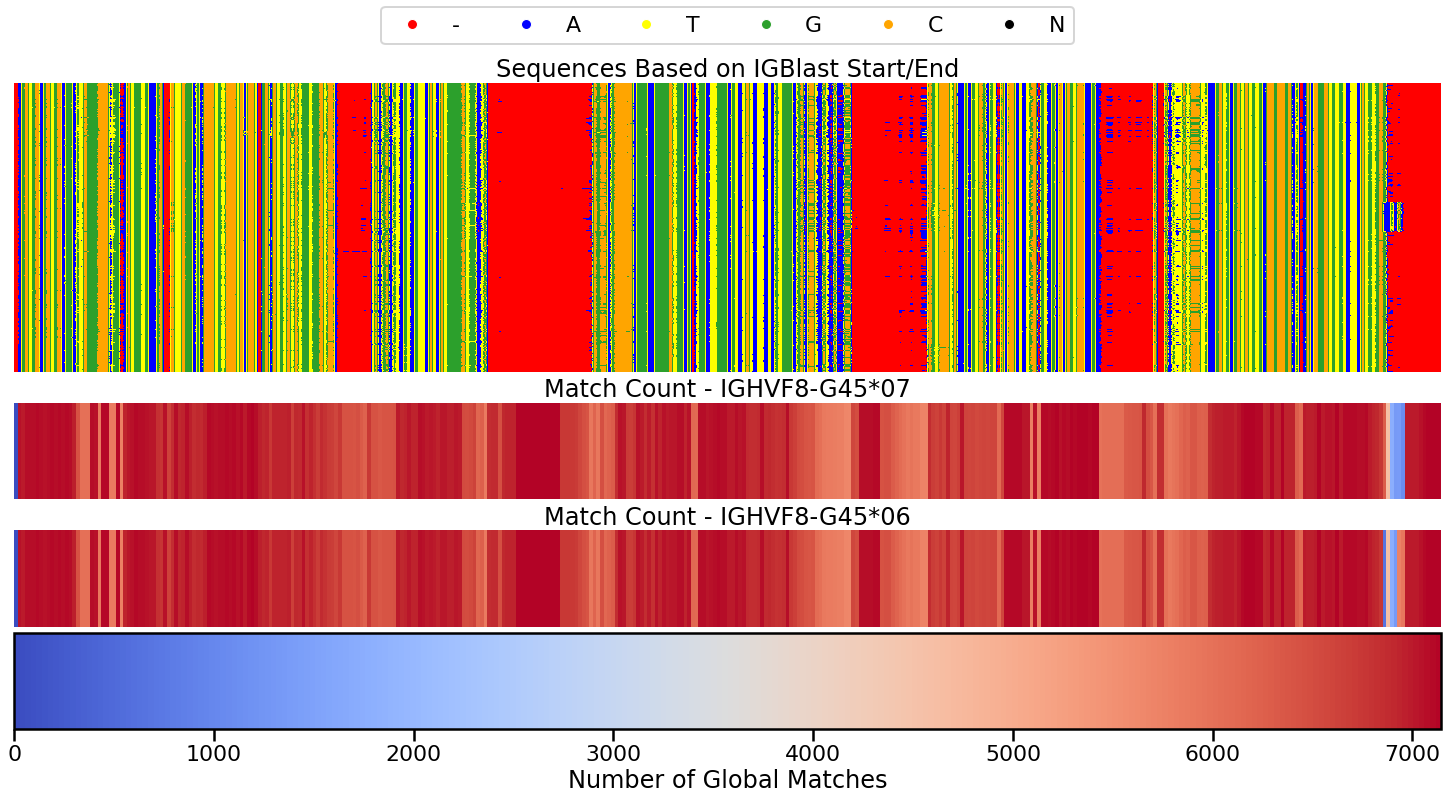

In [1319]:

from matplotlib.colors import ListedColormap

# Define the custom colormap based on the given dictionary
custom_colors = ['red', 'blue', 'yellow', 'tab:green', 'orange','black']
cmap = ListedColormap(custom_colors)


fig = plt.figure(layout="constrained")


ax_dict = fig.subplot_mosaic("""AA
                                AA
                                AA
                                BB
                                CC
                                DD""")



colors = custom_colors

im0 = ax_dict['A'].imshow(adf,cmap=cmap, aspect="auto")
ax_dict['A'].set_title('Sequences Based on IGBlast Start/End')
im1 = ax_dict['B'].imshow(np.stack([m1.values]*30),cmap='coolwarm', aspect="auto")
im2 = ax_dict['C'].imshow(np.stack([m2.values]*30),cmap='coolwarm', aspect="auto")
ax_dict['A'].axis('off')
ax_dict['C'].axis('off')
ax_dict['B'].axis('off')
ax_dict['B'].set_title(f'Match Count - {list(add_ref)[1]}')
ax_dict['C'].set_title(f'Match Count - {list(add_ref)[0]}')

fig.colorbar(im2, cax=ax_dict['D'], orientation='horizontal',label='Number of Global Matches');


labels = ['-', 'A', 'T', 'G', 'C','N']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, labels)]
ax_dict['A'].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(labels))


In [745]:
V_Alleles['IGHVF2-G18*02'][:12]

'GAGGTGCAGCTG'

In [761]:
adf[16].value_counts()

T    27169
-      394
G        9
C        1
Name: 16, dtype: int64

# Emperical Start and End via IGB

In [378]:
qallele = 'IGHVF2-G6*02'

In [379]:
Q = single_call[single_call.v_call.apply(lambda x: x == qallele)].copy()
Q['igb_v_length'] = Q["v_sequence_end"] - Q["v_sequence_start"]
Q['ar_v_length'] = Q["v_sequence_end_ar"] - Q["v_sequence_start_ar"]
Q['seq_len'] = Q.sequence.str.len()
Q

,sequence,v_sequence_start,v_sequence_end,v_call,v_call_ar,v_sequence_start_ar,v_sequence_end_ar,igb_v_length,ar_v_length,seq_len
45863,ACTGGTTACAGCATGAGCTTGGTCCAGCATGCTTCACAACAGGGAT...,160,203,IGHVF2-G6*02,IGHVF2-G17*01,-22,244,43,266,334
69239,GACTGGTTACAGCATGAGCTTGGTCCAGCATGCTTCACAACAGGGA...,161,209,IGHVF2-G6*02,IGHVF1-G1*01,-13,274,48,287,344
94459,NNACGGGGACAGCATGAGCTTGGTCCAGCACGCTTCACAACAGGGA...,161,209,IGHVF2-G6*02,IGHVF1-G4*03,-11,222,48,233,304
185226,GCGCGAGACGCTACCTTATACGGGGACAACAGGGATAGGTGTGGGT...,150,193,IGHVF2-G6*02,IGHVF2-G7*03,-9,215,43,224,296
216388,GGAGCTTGGTCCAGCACGCTTCACAACAGGGATAGGTGTGGGTGCC...,147,190,IGHVF2-G6*02,IGHVF6-G33*01,-43,227,43,270,313
...,...,...,...,...,...,...,...,...,...,...
4832525,AGCACTGAACACAGAGGACTCGCCATGGAGTTTGGGCTGAGCTGGG...,82,376,IGHVF2-G6*02,IGHVF2-G7*03,82,383,294,301,459
4842558,GATTCAGTGATCAGCACTGAACACAGAGGACTCGCCATGGAGTTTG...,94,389,IGHVF2-G6*02,IGHVF2-G12*02,95,394,295,299,475
4848728,GAGTGATCAGCACTGAACACAGAGGACTCGCCATGGAGTTTGGGCT...,90,378,IGHVF2-G6*02,IGHVF2-G18*03,84,382,288,298,455
4857749,GAGATTCCCAGGAGTTTCCACTTGGTGATCAGCACTGAACACAGAC...,112,391,IGHVF2-G6*02,IGHVF1-G3*04,109,406,279,297,468


In [380]:
reference = ihgv_map['IGHV3-20*04'].replace('.',"")
reference_b = ihgv_map['IGHV4-4*08'].replace('.',"")


In [193]:
a = Q.loc[34273,'sequence'][141:189]
b = reference
c = reference_b

In [221]:
alignment = allign_sequences([c,a,b])
#alignment = pd.Series(map(lambda x: str(x.seq),alignment))
adf = pd.DataFrame(data=[list(str(i.seq)) for i in alignment])
# for col in adf.columns:
#     adf.loc[:,col] = adf.loc[:,col].map({"-":0,'A':1,'T':2,'G':3,'C':4,'N':5})

In [222]:
adf

,0,1,2,3,4,5,6,7,8,9,...,286,287,288,289,290,291,292,293,294,295
0,C,A,G,G,T,G,C,A,G,C,...,G,T,G,C,G,A,G,A,G,A
1,-,-,-,-,-,-,-,-,-,-,...,G,T,G,A,G,T,G,A,-,-
2,G,A,G,G,T,G,C,A,G,C,...,G,T,G,C,G,A,G,A,G,A


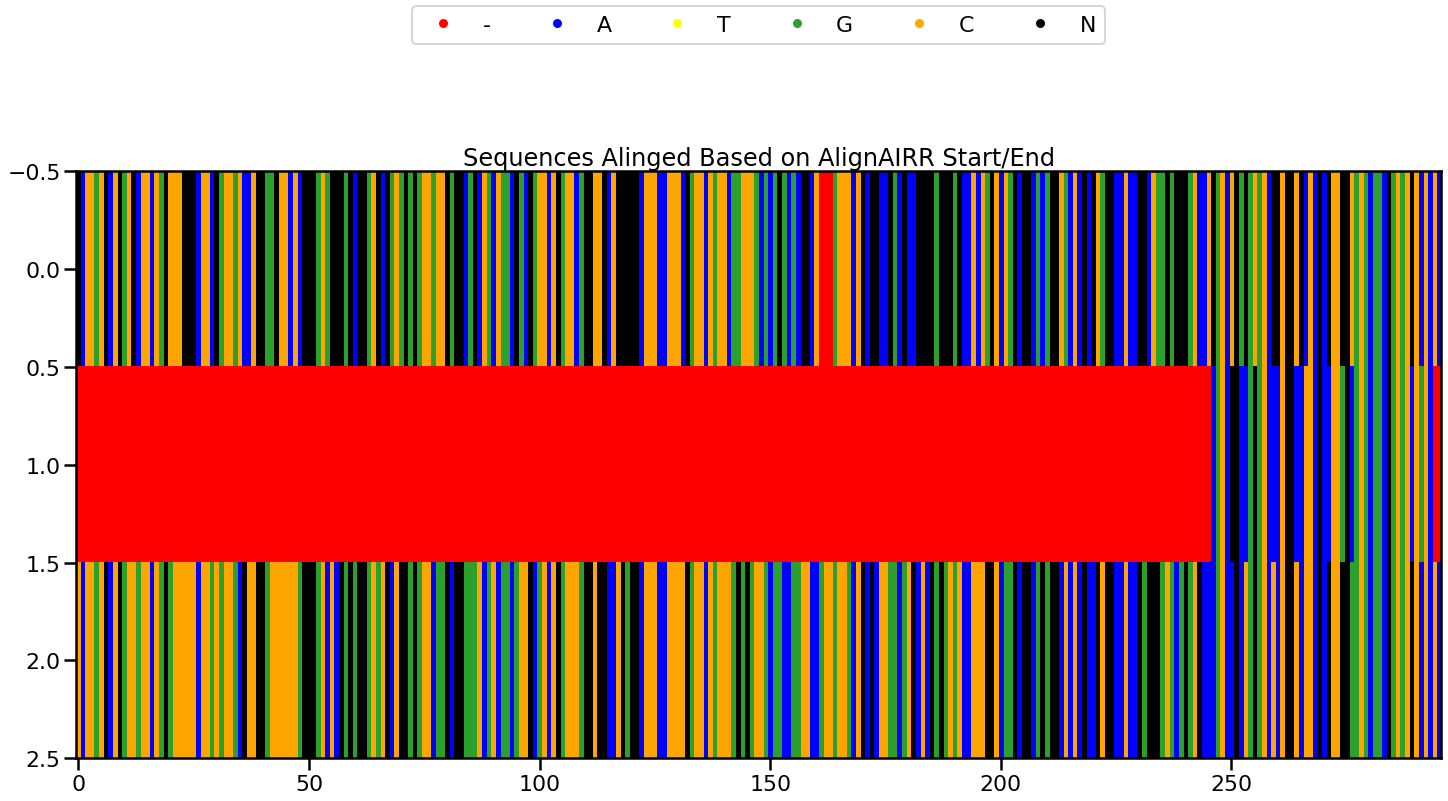

In [195]:
from matplotlib.colors import ListedColormap

# Define the custom colormap based on the given dictionary
custom_colors = ['red', 'blue', 'yellow', 'tab:green', 'orange','black']
cmap = ListedColormap(custom_colors)


fig = plt.figure(layout="constrained")


ax_dict = fig.subplot_mosaic("""AA
                                AA
                                AA
                                """)



colors = custom_colors

im0 = ax_dict['A'].imshow(adf,cmap=cmap, aspect="auto")
ax_dict['A'].set_title('Sequences Alinged Based on AlignAIRR Start/End')



labels = ['-', 'A', 'T', 'G', 'C','N']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, labels)]
ax_dict['A'].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(labels))


In [219]:
adf.apply(lambda x: x[0] != x[2],axis=0)

0       True
1      False
2      False
3      False
4      False
       ...  
291    False
292    False
293    False
294    False
295    False
Length: 296, dtype: bool

In [214]:
VDJ
V = x[0]

0    39
1    36
dtype: int64

In [225]:
L = igb_predicted['v_sequence_end']-igb_predicted['v_sequence_start']

<AxesSubplot:ylabel='Count'>

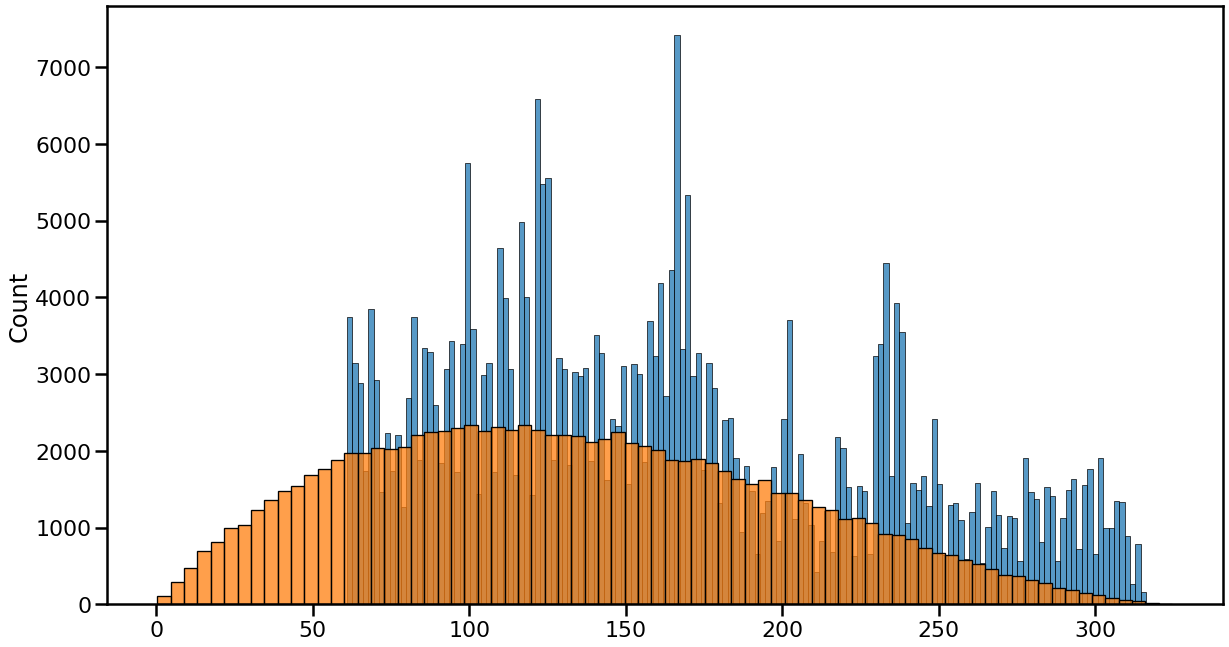

In [277]:
import scipy.stats as st
sns.histplot(330-L[L<270],bins=150)
sns.histplot(st.beta(2, 3).rvs(100000)*330)

<AxesSubplot:xlabel='v_sequence_start', ylabel='Count'>

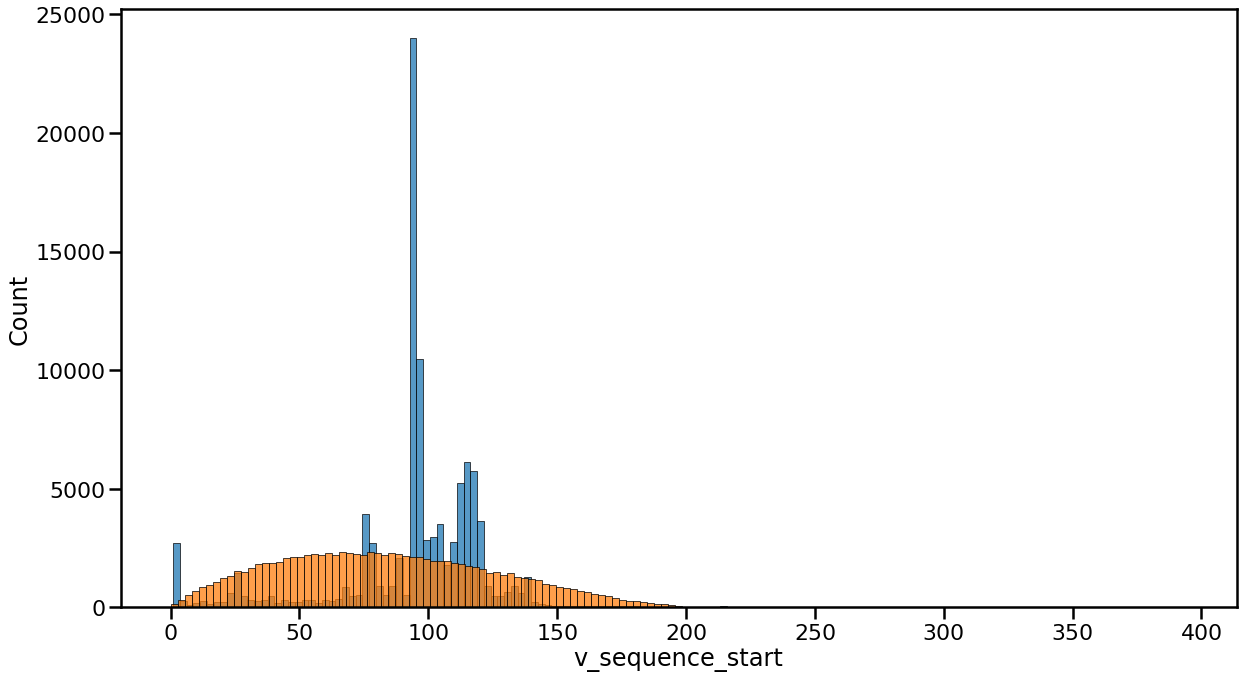

In [332]:
import scipy.stats as st
sns.histplot(igb_predicted['v_sequence_start'].sample(100000),bins=150)
sns.histplot(st.beta(2, 3).rvs(100000)*210)

In [296]:
st.t(1).rvs(50000)+100

array([ 99.74163746, 100.88844158,  98.47923966, ...,  99.75114728,
        99.52866636, 103.42721683])

In [292]:
st.t(2).rvs(100)

array([ 3.10994177,  1.62403859, -0.27190512,  0.60163219, -2.05004944,
       -0.54930168,  0.93619506,  0.71486865,  0.27317081,  3.34607865,
       -1.39482095,  0.54245171, -0.11473253,  0.61537704,  1.80370699,
       -0.02974746,  1.09998995,  0.32223997, -0.0705479 , -0.71126966,
       -0.58511634, -0.29683934, -0.16463268,  0.65247694,  0.54828485,
        0.95475064, -0.44874708, -3.9146651 , -1.08398069, -0.34728477,
       -0.33949822,  0.16533535, -0.35185362,  0.65046104,  0.8534609 ,
       -0.58085533, -1.17744272, -0.94875465, -0.2762946 ,  0.77406457,
       -0.51094005,  0.29715022, -0.41856399,  0.23143512,  0.89844648,
        0.67695804, -0.31292569, -0.84274273, -0.60567341, -0.63421402,
        0.34308854, -0.83848381,  1.28124969,  0.03983929, -0.33834324,
       -0.91693117,  0.0726316 ,  2.16256973,  0.52153288, -1.20309465,
       -0.56976257,  1.15142252, -2.94157148,  0.01369218,  1.32175766,
       -1.42113955,  0.81339714, -0.73918676, -1.3545271 , -1.38